<a href="https://colab.research.google.com/github/cerr/octave-colab/blob/master/Lung_and_Heart_SubStructures_Dropbox_IDC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heart SubStructure CT Segmentation

In [ ]:
#Dropbox download 
condaenv_gz = 'https://www.dropbox.com/s/ddr4swgovjrhj4m/condapack_CT_Heart_DeepLab_hdl35_linux.tar.gz?dl=0'
heartdeeplab_gz = 'https://www.dropbox.com/s/vtcg3ja0yo1ojiy/CT_Heart_DeepLab.tar.gz?dl=0'

lung_condaenv_gz = 'https://www.dropbox.com/s/2n8yhbivhvpxh75/condaenv_jj1_CT_LungOAR_incrMRRN_linux.tar.gz?dl=0'
lungoar_gz = 'https://www.dropbox.com/s/0rxc6mrskx0qe1t/model_CT_LungOAR_incrMRRN.tar.gz?dl=0'

manifest_url = 'https://www.dropbox.com/s/der2wlkwdk6vn8u/bq_QIN-LUNG-01-0007.csv?dl=0'

manifestLocalPath = '/content/bq_QIN-LUNG-01-0007.csv'

dataPath = '/content/inputDICOM'

### Connect to Google Cloud Platform and transfer of IDC data to Colab VM

In [ ]:
#cohortBQTable = "manifest_cohort_405_20211026_043915"
myProjectID="sixth-radar-330114"

from google.colab import auth
auth.authenticate_user()

### Download software and set up dependencies
CERR, GNU Octave, condapack Python files, heart DeepLab segmentation network

In [ ]:
import os, subprocess, urllib.request, json
from glob import glob

In [ ]:
%%capture
! apt-get update
! apt-get install libgraphicsmagick++1-dev libsuitesparse-dev libqrupdate1 libfftw3-3 gnuplot zsh
! pip install oct2py octave_kernel

In [ ]:
!apt list --installed | grep -i qt5 | awk -F/ '{ print $1 }' | xargs echo



libqt5concurrent5 libqt5core5a libqt5dbus5 libqt5gui5 libqt5network5 libqt5printsupport5 libqt5sql5 libqt5svg5 libqt5test5 libqt5widgets5 libqt5xml5 qt5-default qt5-qmake qt5-qmake-bin


In [ ]:
%%bash
cd /usr/lib
ldd libqscintilla2-

ldd: ./libqscintilla2: No such file or directory


In [ ]:
# download compiled octave package (latest)
def get_CERRoctave(root_path):
  os.chdir(root_path)
  with urllib.request.urlopen("https://api.github.com/repos/cerr/octave-colab/releases/latest") as url:
      data = json.loads(url.read().decode())
  fname = data['assets'][0]['name']
  requrl = data['assets'][0]['browser_download_url']
  urllib.request.urlretrieve(requrl, fname)
  # unzip, identify octave folder name
  !tar xf {fname}
  top_folder = !tar tf {fname} | head -1
  octave_folder = top_folder[0][:-1]
  octave_path = os.path.join(root_path,octave_folder)
  !git clone https://github.com/cerr/CERR.git
  !cd CERR && git checkout octave_dev
  cerr_path = os.path.join(root_path,'CERR')
  return octave_path, cerr_path


octave_path,cerr_path = get_CERRoctave('/content')
os.environ['OCTAVE_EXECUTABLE'] = octave_path + '/bin/octave-cli'
os.environ['PATH'] = octave_path + '/bin:' + os.environ['PATH']

Cloning into 'CERR'...
remote: Enumerating objects: 27261, done.
remote: Counting objects: 100% (3014/3014), done.
remote: Compressing objects: 100% (1354/1354), done.
remote: Total 27261 (delta 2043), reused 2519 (delta 1657), pack-reused 24247
Receiving objects: 100% (27261/27261), 524.42 MiB | 30.86 MiB/s, done.
Resolving deltas: 100% (18964/18964), done.
Checking out files: 100% (3418/3418), done.
Branch 'octave_dev' set up to track remote branch 'octave_dev' from 'origin'.
Switched to a new branch 'octave_dev'


In [ ]:
import oct2py
import octave_kernel
from oct2py import octave
%load_ext oct2py.ipython

In [ ]:
!mkdir  -p /content/{condaenv/{heart,lung},data}
#! wget {condaenv_gz} -O /content/condaenv/heart/CT_Heart_DeepLab_hdl35_linux.tar.gz & 
#! wget {heartdeeplab_gz} -O /content/condaenv/heart/CT_Heart_DeepLab.tar.gz &
#! wget {lung_condaenv_gz} -O /content/condaenv/lung/CT_LungOAR_jj1_linux.tar.gz &
! wget {lungoar_gz} -O /content/condaenv/lung/CT_LungOAR_incrMRRN.tar.gz
#! wget {manifest_url} -O {manifestLocalPath}

--2021-11-02 22:10:43--  https://www.dropbox.com/s/0rxc6mrskx0qe1t/model_CT_LungOAR_incrMRRN.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/0rxc6mrskx0qe1t/model_CT_LungOAR_incrMRRN.tar.gz [following]
--2021-11-02 22:10:43--  https://www.dropbox.com/s/raw/0rxc6mrskx0qe1t/model_CT_LungOAR_incrMRRN.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca62b33374ed622aba048a31bc6.dl.dropboxusercontent.com/cd/0/inline/BZMG6BDRI4pQ9CSKf4OKXrAXHX1cyeGa3NswrM4ljdWeTKmJowVsOIaDH57rQ6HgXK39jHiCbscf0ilcS18EwoCs16IrJo-xCIYdMBDodA2G5E1-kdeztKj1WKmpyB9RjKukxQ6hfhyG35WzNWgDBxyH/file# [following]
--2021-11-02 22:10:44--  https://uca62b33374ed622aba048a31bc6.dl.dropboxusercontent.com/cd/0/inline/BZMG6BDRI4pQ9CSKf4OKXrAXH

In [ ]:
import pandas as pd

def cohort_as_df(manifest_filename):
  df = pd.read_csv(manifest_filename, header=0)
  return df

cohort_df = cohort_as_df(manifestLocalPath)

cohort_df = cohort_df.join(cohort_df["gcs_url"].str.split('#', 1, expand=True).rename(columns={0:'gcs_url_no_revision', 1:'gcs_revision'}))
cohort_df["gcs_url_no_revision"].to_csv("gcs_paths.txt", header=False, index=False)

!mkdir {dataPath}
!cat gcs_paths.txt | gsutil -u $myProjectID -m cp -I {dataPath}

Copying gs://idc-open/ca61cb78-b552-4703-9269-ed13e960c3f8.dcm...
Copying gs://idc-open/89981ccd-2a5a-4ebc-9f78-e55a4291ded1.dcm...
Copying gs://idc-open/0c6a7296-e97b-4079-be5d-875e180cc1ed.dcm...
Copying gs://idc-open/3511b24b-9c28-4ad0-9483-931a235f87a6.dcm...
Copying gs://idc-open/ad00001e-addd-43e1-bfd2-8af9b341a9e2.dcm...
Copying gs://idc-open/f36d0dfd-5549-494f-bc18-6c2e9d076b7a.dcm...
Copying gs://idc-open/907a57af-07cc-44ea-8e03-0ae35b1863fd.dcm...
Copying gs://idc-open/dff86716-244f-4d29-9222-7eb9f9c1fdf9.dcm...
Copying gs://idc-open/c6c5018e-78dd-4a21-8b01-2f9b0b00d150.dcm...
Copying gs://idc-open/62101730-be7c-4eb4-99bc-a113293d2eb5.dcm...
Copying gs://idc-open/836db843-21bb-42b3-b744-fbe5fc6ab849.dcm...
Copying gs://idc-open/9d3516b6-c67d-4f9b-bb95-86e83954757f.dcm...
Copying gs://idc-open/fb280291-2211-4b91-8441-a7e175699eab.dcm...
Copying gs://idc-open/a490a8a5-45d6-49e5-85f3-d25ec389f8ea.dcm...
Copying gs://idc-open/a02beaaa-6e29-4408-a336-b4c4506a3f03.dcm...
Copying gs

In [ ]:
%%capture
for env in ['heart','lung']:
  gz_list = glob('/content/condaenv/' + env + '/*.tar.gz')
  for g in gz_list:
    subprocess.run('tar xf ' + g + ' --directory /content/condaenv/' + env,shell=True)

In [ ]:
%%bash
source /content/condaenv/lung/bin/activate
conda-unpack
python -c "import h5py; print(h5py.__file__)"


/content/condaenv/lung/lib/python3.6/site-packages/h5py/__init__.py


In [ ]:
for g in gz_list:
  os.remove(g)

Initialize Octave with oct2py bridge

In [ ]:
%%octave

pkg load image
pkg load io
pkg load statistics

warning('off','all')

In [ ]:
cerrPath = r'/content/CERR'
octave.addpath(cerrPath)
octave.addToPath2(cerrPath)

Adding to path ... /content/CERR/CERR_Data_Extraction
Adding to path ... /content/CERR/CERR_core
Adding to path ... /content/CERR/IMRTP
Adding to path ... /content/CERR/Jupyter_Notebooks
Adding to path ... /content/CERR/ML_Dicom
Adding to path ... /content/CERR/Python_packages
Adding to path ... /content/CERR/Unit_Testing


Run segmentation routine

In [ ]:
%octave_push dataPath

In [ ]:
%%octave
setenv('JAVA_HOME','/usr/lib/jvm/java-11-openjdk-amd64/lib/server')
init_ML_DICOM

ans = 1

In [ ]:
%%capture
%%octave
planC = importDICOM(dataPath);

In [ ]:
%%capture
%%octave

sessionPath = '/content/session_lung';
cmdFlag = 'condaEnv';
condaEnvName = '/content/condaenv/lung';
algorithm = 'CT_LungOAR_incrMRRN';
wrapperFunction = '/content/condaenv/lung/model_wrapper/run_wrapper_Jue.py';
batchSize = 1;

[activate_cmd,run_cmd,userOptS,outFile,scanNumV,planC] = prepDataForSeg(planC,sessionPath,algorithm,cmdFlag,condaEnvName, {wrapperFunction});

In [ ]:
%%octave
[outStrListC,labelMapS] = getAutosegStructnames('',userOptS);

In [ ]:
%octave_pull outFile run_cmd

In [ ]:
!chmod 777 {outFile}

In [ ]:
print(outFile)

/content/session_lung/segScript/CT.2112021.22101.0279863.1411826.sh


In [ ]:
q = subprocess.Popen(outFile,stdout=subprocess.PIPE,stderr=subprocess.PIPE)
s,err =q.communicate()
print(s)
print(err)

b"['/content/condaenv/lung/model_wrapper/run_wrapper_Jue.py', '/content/session_lung/inputH5', '/content/session_lung/outputH5', '1']\n/content/condaenv/lung/model/LUngOARSeg_Model_net.pth\n1024\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 512)\n(1, 1, 512, 

In [ ]:
%%octave
planC = processAndImportSeg(planC,1,sessionPath,userOptS);

 Resampling masks...

Elapsed time is 18.4624 seconds.

Creating raster-scan representation of lung_left contour.

Creating raster-scan representation of lung_left contour.

Creating raster-scan representation of lung_right contour.

Creating raster-scan representation of lung_right contour.

Creating raster-scan representation of heart contour.

Creating raster-scan representation of heart contour.

Creating raster-scan representation of esophagus contour.

Creating raster-scan representation of esophagus contour.

Creating raster-scan representation of cord contour.

Creating raster-scan representation of cord contour.

In [ ]:
%%octave
save_planC(planC,[],'PASSED','planC_lung_colab.mat')

CERR>>  Saving planC_lung_colab.mat...

CERR>>  Saved planC_lung_colab.mat. Ready. (02-Nov-2021 22:19:42)

ans =

{

  [1,1] =

    scalar structure containing the fields:

      archive =

      tapeStandardNumber =

      intercomparisonStandard =

      institution =

      dateCreated =

      writer = CERR DICOM Import

      sponsorID =

      protocolID =

      subjectID =

      submissionID =

      timeSaved =

      {

        [1,1] = 02-Nov-2021 22:19:41

      }

      lastSavedInVer = 6.0

      CERRImportVersion =

      anonymizedID =

  [1,2] =

    1x0 struct array containing the fields:

      imageNumber

      imageType

      caseNumber

      patientName

      writer

      commentDescription

      dateWritten

      fileOfOrigin

      unitNumber

      headInOut

      comment

  [1,3] =

    scalar structure containing the fields:

      scanArray =

ans(:,:,1) =

       Columns 1 through 12:

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0    23

           0     0     0     0     0     0     0     0     0     0     0    25

           0     0     0     0     0     0     0     0     0     0    20    30

           0     0     0     0     0     0     0     0     0    26    21    26

           0     0     0     0     0     0     0     0    27    26    22    23

           0     0     0     0     0     0     0    21    27    24    20    23

           0     0     0     0     0     0     0    21    20    19    21    24

           0     0     0     0     0     0    24    28    20    14    21    24

           0     0     0     0     0    18    26    31    25    14    19    22

           0     0     0     0    17    17    20    27    27    22    19    16

           0     0     0     0    24    16    18    25    29    27    22    14

           0     0     0    21    29    24    21    23    22    27    29    16

           0     0    17    14    29    34    21    18    26    22    25    21

           0    19    26    14    18    31    27    16    24    27    20    14

          16    12    20    20    15    23    26    24    20    22    22    19

          20    21    14    14    16    25    26    25    21    25    24    19

          24    25    23    16    14    21    21    27    24    23    29    21

          22    22    28    24    16    19    21    20    24    23    25    28

          20    21    31    24    22    22    24    20    21    22    20    25

          21    22    32    23    19    25    27    22    25    23    15    19

          22    17    26    29    22    20    23    24    22    24    18    15

          27    18    15    24    28    23    22    22    19    22    19    19

          24    18    16    21    22    24    24    22    22    21    19    18

          25    20    18    21    19    24    23    22    23    23    22    18

          27    20    20    22    21    26    21    19    21    24    30    21

          26    21    21    24    25    27    20    18    24    25    29    26

          25    21    22    25    23    29    24    22    24    23    23    21

          28    28    23    23    21    27    26    26    26    20    19    19

          21    26    22    26    24    27    28    18    25    25    16    16

          20    15    15    26    27    26    32    19    19    23    23    21

          23    21    16    14    23    27    32    27    23    17    21    24

          27    25    23    18    14    19    31    34    28    20    16    22

          28    29    25    26    17    13    21    26    30    27    23    23

          21    29    28    25    23    19    19    15    24    23    22    26

          20    21    32    26    23    19    19    23    26    22    18    16

          28    24    31    27    24    21    19    21    23    29    25    17

          24    25    28    26    27    24    18    23    24    24    26    21

          26    24    25    26    24    23    19    23    32    23    21    22

          31    25    27    26    27    25    20    17    28    28    22    22

          25    18    24    30    28    28    29    21    21    25    23    25

          21    23    14    23    26    22    27    33    28    27    28    21

          18    28    21    15    17    19    25    32    32    29    34    29

          19    20    22    20    18    15    18    24    26    31    31    33

          22    17    19    21    26    21    12    16    19    23    29    32

          25    20    24    22    20    24    17    14    22    24    19    24

          28    17    25    30    20    15    21    23    23    25    20    24

          27    25    21    23    27    23    20    23    26    24    19    23

          24    18    16    19    20    24    24    29    30    26    18    20

          36    24    16    13    14    18    21    27    33    32    20    16

          35    35    29    20    11     9    22    25    27    29    20    17

          29    36    32    34    25     8    12    19    23    27    22    15

          25    32    30    34    31    28    21    11    12    14    26    28

          18    21    25    29    31    29    30    24    18    17    16    22

          17    10    21    25    34    29    28    28    22    24    20    20

          23    17    16    22    31    31    29    27    20    28    22    16

          21    30    20    20    25    30    28    27    19    27    32    23

          24    22    18    22    25    26    29    28    24    20    24    28

          29    25    13    11    23    32    28    30    27    20    21    25

          25    26    19    10    13    29    26    25    29    25    19    24

          33    33    21    12    12    20    27    20    24    26    22    24

          31    44    35    20    13    14    18    22    29    26    17    27

          23    34    42    32    21    19    10    18    34    32    18    19

          19    16    31    34    29    30    19    19    34    31    22    19

          14    14    18    28    35    33    22    20    34    31    21    19

          16    13    18    25    33    31    24    15    20    35    26    20

          24    16    19    25    24    22    24    22    17    27    25    26

          34    22    23    26    18    25    27    15    21    26    23    25

          34    26    21    30    23    22    33    24    22    22    22    24

          27    36    22    22    29    27    27    24    24    31    29    27

           7    25    26    17    25    37    32    25    20    19    26    32

          15    14    15    12    16    30    36    31    28    22    17    23

          20    24    18    14    13    17    26    22    26    33    29    21

          29    24    23    24    23    19    19    16    16    28    35    27

          33    33    29    26    28    22    18    20    19    17    24    29

          23    32    29    29    34    26    18    22    25    22    20    18

          14    22    21    13    24    36    31    24    27    27    27    27

          11    14    21    17    12    24    28    24    25    30    29    30

          20    18    16    15    11    21    25    14    13    27    36    29

          24    22    23    21     9    11    23    19     9    14    28    28

          29    25    21    25    20    16    20    19    15    14    14    23

          21    30    29    22    19    19    28    28    19    14    10    18

          12    18    28    26    22    17    22    32    27    15    10    16

          16    12    13    21    29    19    14    27    31    25    16    16

          23    22    22    14    18    23    14    15    25    24    20    22

          19    19    25    31    28    24    18    15    21    20    15    19

          27    18    16    18    27    27    26    26    23    21    22    20

          34    26    17    14    15    21    22    27    32    29    31    27

          33    30    15    13    14    22    23    20    25    26    32    37

          26    28    22    20    16    15    21    27    19    12    17    26

          28    21    22    26    30    18    11    18    23    20    16    14

          31    33    31    22    23    23    23    20    18    14    18    23

          23    29    36    35    27    19    23    33    33    17    11    19

          24    30    26    22    29    34    25    21    30    36    28    23

          23    25    29    23    25    32    31    22    24    28    27    25

          15    16    26    25    26    29    30    26    29    28    28    22

          14    12    17    19    22    30    29    25    26    26    29    24

          24    21    13    14    19    28    28    20    23    27    25    26

          24    30    25    19    19    23    27    22    18    26    28    24

          20    28    28    23    20    21    29    28    20    24    30    30

          19    27    33    22    19    20    23    24    18    26    32    25

          22    20    30    26    21    22    23    23    16    15    25    29

          25    31    34    28    20    21    24    26    27    17    13    14

          10    24    31    26    23    23    28    29    32    23    19    13

          15    19    24    16    16    20    22    31    37    31    26    18

          26    18    23    20    19    17    12    17    32    34    32    24

          28    20    22    23    25    18    12    13    21    25    32    28

          26    26    21    19    24    19    11    11    19    22    29    24

          17    27    27    28    31    23    15    13    11    13    25    26

          17    20    20    23    23    22    23    27    22    13    12    16

          21    26    29    29    20    15    17    15    25    28    22    14

          16    18    28    35    33    25    20    17    21    24    26    25

          18    15    15    25    35    35    23    19    28    24    22    26

          18    19    21    22    19    28    34    26    29    24    22    25

          15    16    22    25    21    19    26    23    23    25    22    24

          29    23    27    18    17    24    29    25    15    23    19    18

          31    29    37    32    27    27    23    30    20    18    24    21

          16    18    27    32    35    35    27    28    25    23    28    25

          18    18    13    15    28    33    35    31    20    17    31    29

          22    28    27    18    14    18    25    34    32    20    26    23

          18    20    33    35    24    20    14    26    33    33    33    26

          20    15    18    29    30    31    18    20    22    25    32    28

          27    26    18    22    28    29    27    28    29    20    24    27

          26    31    27    26    26    23    21    21    28    32    35    41

          22    21    17    21    24    31    26    18    14    18    29    34

          25    23    21    21    14    22    22    20    24    22    24    21

          37    27    25    32    22    23    14     9    26    25    27    28

          28    27    28    38    33    28    21    12    18    24    23    31

          26    24    19    26    36    36    29    21    12    25    22    26

          22    25    25    20    29    36    33    30    18    22    18    16

          22    22    24    23    24    24    21    30    33    32    25    17

          16    23    27    30    33    26    12    17    19    26    36    32

          22    19    20    22    28    32    22    19    18    15    23    32

          23    26    19    18    18    25    24    19    22    19    19    22

          11    19    24    20    21    24    25    19    19    22    25    24

          15    16    19    20    21    24    25    25    22    15    16    16

          13    14    20    27    30    26    24    27    35    29    23    18

          26    15    12    13    22    23    21    17    26    32    30    30

          29    30    34    29    22    24    24    10     8    14    17    21

          20    19    19    33    40    36    33    25    16    13    10     9

          10    15    16    18    26    28    23    29    25    24    25    17

          12    14    20    26    30    26    19    20    23    22    27    31

          10    10    16    20    25    22    21    23    22    22    24    24

          13     6    10    14    18    21    18    19    22    20    26    27

          18    11    10     9     9    16    19    17    19    18    19    19

          18    13    11     7    12    13    11    13    20    21    15     9

          23    24    20    13    12     8     8    11    16    16    18    15

          12    23    26    22    21    12    10    13    14     7    11    11

          19    17    16    22    32    28    18    13    12     9    12    15

          17    19    19    15    24    32    33    26    20    12     9    15

           9     5     9    14    15    18    23    22    24    31    23    20

          21    16     7     7    15    15    16    14    15    20    21    30

          14    17    14     8     9    11    13    11    15    15     7    11

          16    17    17    11    12    14    14    10     5    13    18    19

          18    18    22    22    18    16    20    19    10     9    14    21

          25    23    21    27    30    27    26    23    13     7    10    21

          22    16    16    19    25    27    30    34    28    22    12    15

          41    34    29    17    14    19    19    16    25    34    30    24

          40    38    48    47    38    33    30    21    26    34    32    27

          24    25    33    36    39    36    32    24    22    37    42    30

          10     9    16    23    31    36    39    36    21    20    33    26

          23    17     9     8    10    16    17    28    34    28    28    33

          13    19    23    14    11    11    13    17    17    21    23    29

           9     6    16    22    18     7     7    14    17    15    15    16

          11     2     2    11    17    14     6     5    10    18    16     8

          16     4     1     5    16    16    12    14    11    12    21    17

          21    18     6     3    11    12     8    13    15    10    16    16

          35    37    29    21    21    18    10    10    11    11    14    16

           9    19    25    25    30    30    21    17    13    13    16    10

           6     3     8    15    24    24    19    20    22    31    38    27

          23    16    11    10    18    15     4     4    14    23    30    27

          20    22    25    21    23    27    11     0     5    13    16    22

          13    13    12    16    19    31    31    18    19    23    17    14

          15    13     9     8     8    14    15    16    23    29    29    26

          16    13    12     9     7     6     2     2     8    12    12    16

          16    12    17    21    18    19    12    10    13    12     9    12

          27    20    15    18    20    18    16    15    28    22    10     5

          26    24    19    21    23    22    11     4    23    34    32    20

          25    25    20    23    26    28    17     2     1    10    27    26

          15    14    15    19    20    26    36    25    10     8    18    16

          12     7     8    15    11    10    23    28    25    16    24    27

           9    12     7    10    12     9    11    17    26    13    12    14

          12    11    13    15    13    12    11    11    26    32    26    17

          31    22    21    23    21    27    26    18    17    24    27    23

          19    17    15    16    13    21    28    20    20    22    25    23

           9    13     9     4     1     6    14    12     4     2     5     5

          15    20    16     7     3     3     7    14    19    12    10     3

          13    15    17    13    16    22    31    17    11    19    20    11

          11    12    12     8     6     6    26    26    12    19    28    18

           8     9    12     6     4     2     9    19    15    14    14    16

          15    18    26    22    17     9     6     8     8     9    11     8

          17    11    19    23    21    25    22    13     7     9     9    10

          15     5     2     8    11    13    19    23    12    17    25    23

          17    12     6     8     5     3     5    11    11    14    17    13

          32    23    14    21    21    17    21    23    14    17    25    19

          45    33    21    23    23    21    28    35    23    23    22    22

          21    22    22    28    28    23    29    33    25    20     6     5

           8     3     1    10    13    11    15    19    27    37    22    15

          12     9     4     9     7     4     8     5    10    17    23    20

           9     9     5     6    16    18    17    10     4     2     3     2

           2     0     0     0     4    11    18    21    18     9     6     2

          18    11     2     0     2     2    14    13    11     9    11    16

          32    20     6     4     6     3    10    10     4     0     2    38

          40    31    13     9     8     8    12    12     5     4    13    70

          34    32    23    26    20    14    13    11     8     9    35   128

          34    37    29    35    33    25    18     9     9    30    83   206

          17    24    19    26    25    25    20    13    24    65   147   302

          10     8     6    10     9     9     7     6    24    85   192   381

          21     6     0     3     3     3     6    16    57   153   288   496

          24    15     3     2     2     2    11    35    79   192   359   585

          26    19     3     5     9     7    21    51   119   249   446   690

          19    15     0     0     3     4    24    71   162   318   539   774

          20    21     3     0     0     6    36    96   215   408   643   850

           9    14    12    12    20    39    85   147   290   521   752   909

          12     4     0     5    19    62   127   216   401   647   840   934

          16     6     0     0     9    61   152   287   517   759   907   939

           6     6     0     0    23    97   221   397   644   854   947   944

          11     8     0     0    23   110   280   511   755   917   960   941

           9    11     0     2    51   170   372   626   846   948   955   933

          11     8     0    18    73   223   463   725   902   961   954   931

          17     9     6    44   127   302   568   812   929   950   939   923

          26    13     9    64   187   406   679   884   947   938   928   916

          13     8    15    83   240   504   775   934   960   941   931   918

          13    23    55   141   323   610   855   961   958   933   917   911

          13    20    63   181   405   696   894   957   940   921   910   910

          25    42    96   249   521   804   945   970   946   920   909   904

           5    29   109   286   592   856   947   945   928   910   908   899

           5    40   130   327   655   907   965   947   926   913   923   925

          13    75   183   399   725   946   972   952   936   921   921   921

          11    74   201   445   757   934   943   920   918   920   920   908

          40   113   250   512   810   952   950   923   904   893   898   897

          26   100   260   551   846   958   945   925   917   907   905   908

          33   113   295   607   886   967   950   935   932   939   936   926

          33   120   311   623   892   967   953   938   931   938   937   939

          35   145   364   684   920   969   950   928   918   911   906   913

          30   137   359   692   920   965   946   923   917   911   917   914

          46   147   352   693   922   959   940   922   918   910   919   911

          64   168   376   717   939   972   942   918   908   903   913   908

          70   158   364   706   923   950   937   926   903   895   903   909

          82   150   341   696   927   953   935   927   922   911   903   899

          84   165   345   690   928   957   941   928   923   918   917   910

          89   164   334   685   940   967   937   929   919   910   918   922

          81   145   306   650   929   966   926   924   923   915   909   909

          73   131   278   619   914   973   940   923   909   904   904   900

          64   118   239   564   884   968   941   917   913   908   913   903

          94   127   219   528   867   977   953   923   914   914   917   917

         107   123   186   477   835   971   956   936   924   924   925   924

         109   133   179   440   814   984   967   950   942   933   934   929

          96   111   140   370   749   959   958   933   924   915   914   918

         103   111   116   318   700   935   953   926   912   904   907   916

         102   115   108   279   659   937   977   958   949   932   923   925

         107   116    96   243   615   939  1004   966   956   941   923   912

         112   118    83   194   537   889   989   949   928   917   908   903

         115   112    68   148   460   838   988   959   929   918   917   917

         114    95    42   107   394   787   994   992   957   931   927   936

         120    95    37    67   303   698   962   988   940   909   902   904

         118    82    21    28   213   601   929  1000   950   914   905   900

         125    82    17    13   140   492   877  1019   979   929   916   910

         116    73    15     6    92   379   782   999  1002   957   940   930

         140    98    39    14    55   269   658   956  1011   966   935   926

         130    71    10     0     8   158   514   873   999   968   929   912

         125    60     5     0     2    99   402   790   979   970   930   912

         140    78    23     4     1    62   311   704   969   994   945   912

         120    54    15     8     0    28   222   597   932  1028   995   951

         117    52    18     9     0     6   139   477   868  1032  1008   953

         119    54    16     9     2     3    76   359   772  1009  1028   980

         110    56    26    19    11    13    64   279   678   987  1050   992

         102    55    37    31    25    33    58   203   560   925  1055  1014

          72    33    38    52    52    55    56   141   421   801  1005  1010

          45    18    51    76    80    84    77   122   317   668   952  1020

          49    29    61   101   107    94    86   120   269   583   901  1026

          60    47    81   127   118    73    60   100   238   524   851  1043

          58    45    88   137   122    64    33    59   177   424   760  1002

          48    34    76   127   111    57    21    19    89   298   635   931

          37    32    66   113   123    68    15     2    51   231   553   878

          30    21    36    82   116    76    29     8    37   181   467   820

          31    14    22    61   104    87    31     4    28   148   390   745

          27     7    20    60   108    93    41    24    40   139   332   661

          55    33    44    76   114    97    42     7    19   101   270   576

         106    73    70    94   119    95    36     4    22    98   239   511

         122   112   109   120   123    78    22     0    21    97   210   438

         106   123   137   126    95    51    11     4    27    88   168   342

          69    88   104    93    61    33    21    16    19    74   142   275

          35    42    53    49    40    35    27    21    29    83   128   211

          33    41    42    34    30    31    30    35    46    82    95   144

          37    34    36    28    26    26    24    19    34    69    71    91

          35    26    31    20     6     5     7    22    50    87    86    77

          20    22    31    31    22    26    34    46    73   104    85    46

          32    37    44    43    36    34    32    55    88   114    83    29

          13    23    31    28    28    37    41    61    99   124    76    21

          27    38    43    43    38    38    37    56   101   116    56     8

          32    35    29    28    22    13    17    53   108   121    67    12

          33    40    35    32    28    20    31    63   117   123    59    14

          12    20    22    16    20    15    19    48   108   108    53    19

          19    31    33    26    22    13    22    59   118   119    54    10

          19    22    25    30    28    20    29    58   118   133    74    20

          24    28    38    40    34    24    24    50   120   139    80    29

          13    14    17    11     8    14    22    43    96   123    84    29

          19    20    22    21    20    25    28    36    77   126   119    59

          19    21    24    23    25    29    31    36    64   115   140   103

          22    20    20    15    17    27    27    18    29    66   112   119

          33    36    35    23    20    20    15    15    22    37    77   114

          26    22    21    28    34    30    21    19    21    25    50    93

          27    15    16    30    32    23    12    12    26    38    45    50

          17    10    14    22    23    23    26    31    31    26    20    20

          17    12    10    16    13    14    18    17    15    12    11     6

          28    29    28    32    28    25    23    18    14    15    14    14

          24    24    27    27    23    23    27    26    20    17    22    23

           9    15    20    25    38    53    53    49    48    50    43    29

          15    15    23    41    70    88    96    96   101   103    92    69

          27    27    26    46    83    92    80    66    74    90   105   100

          32    28    26    49    89    94    57    29    32    53    78    94

          28    26    23    38    72    90    74    45    31    37    46    69

          38    39    31    38    64    83    80    52    28    16    15    21

          28    31    27    30    45    53    59    67    59    45    41    34

          17    14    18    23    32    41    51    61    67    73    72    62

           9    14    21    22    23    32    36    39    59    83    90    89

           6    11     9     9    19    31    35    35    44    56    66    73

           3     2     2     8    19    23    21    25    31    44    60    64

          15    19    15     7     7    12    21    26    20    21    24    30

          41    40    26    17    22    19    11     2     0     2     7    15

          36    30    29    28    21    10     3     1     0     0     0     0

          31    30    36    26    14    23    18     9     3     2     2     0

          46    46    48    46    50    57    53    50    51    58    52    40

         170   183   192   192   196   196   199   197   200   213   217   217

         361   370   375   379   389   396   406   417   421   426   428   416

         358   353   350   351   352   357   368   379   372   379   388   385

         209   203   195   191   185   176   176   175   173   177   184   192

         100    94    93    89    92    92    92    81    75    82    87    99

          72    73    71    67    67    64    58    58    70    75    74    74

          69    71    71    65    54    46    56    62    62    62    53    46

          60    59    54    50    49    52    58    57    55    59    60    58

          47    45    59    70    68    67    70    75    73    80    79    74

          57    67    79    79    80    83    89    98    92    79    69    74

          73    75    78    81    84    76    71    70    54    50    61    71

          89    86    82    73    74    62    51    47    46    54    61    66

          87    80    72    68    63    57    57    64    69    66    68    75

          81    77    67    61    60    75    76    70    69    69    75    79

          71    66    63    68    70    73    67    67    72    73    74    74

          75    76    77    71    72    73    68    74    78    74    74    76

          77    75    66    64    72    67    69    75    79    78    78    71

          81    75    65    68    80    81    74    73    83    84    83    79

          84    74    70    76    88    82    74    80    78    77    73    68

          77    71    74    82    84    73    65    63    66    78    72    71

          79    82    87    89    80    69    70    70    76    84    74    73

          94    97   100    94    85    86    79    67    73    83    76    78

          93    98    94    89    87    78    70    71    79    81    78    73

          91    89    88    82    80    76    82    84    78    72    77    80

          83    80    78    87    96   100   100    90    86    87    85    78

          75    78    81    90    88    93    92    86    87    93    90    89

          71    78    75    73    74    93   101   100    97   108   112    94

          70    75    73    67    74    81    92    95    92    97    94    80

          69    71    61    64    66    68    78    80    75    85    90    98

          63    81    84    86    81    81    80    75    73    85    84    96

          46    62    74    76    81    85    85    82    77    72    71    78

          26    35    44    45    63    80    90    85    81    76    74    72

          37    36    32    36    47    59    64    66    75    71    70    68

          38    33    32    43    45    44    33    33    30    32    47    59

          61    53    51    48    51    46    48    46    46    52    54    56

         189   176   162   157   155   148   147   145   155   152   156   170

         355   351   352   349   342   347   343   339   357   387   427   464

         317   324   331   327   333   334   338   406   529   653   750   823

         128   134   147   146   140   138   206   404   668   878  1015  1096

          34    40    41    29    23    28   134   425   786  1031  1160  1227

          14     5     4     4     2     2    78   325   629   836   985  1126

           6     0     2     4     7     6    29   143   291   414   574   830

          14    19    62   115   125    78    30    40    62    92   208   499

          23    82   237   410   423   252    72     1     0     0    42   288

          38   151   441   767   802   515   172     0     0     0     7   222

          49   201   592   996  1067   777   355    87     0     0    40   293

          53   228   642  1067  1200  1002   623   301   136   114   237   526

          37   220   653  1091  1264  1175   935   675   502   482   610   844

          29   222   654  1085  1272  1263  1156  1020   926   921   990  1105

          23   204   638  1064  1247  1273  1238  1184  1158  1169  1201  1247

          13   198   628  1052  1246  1272  1240  1219  1229  1243  1252  1286

          28   199   597  1033  1239  1261  1245  1248  1247  1241  1250  1305

          19   172   558  1001  1235  1280  1273  1264  1242  1226  1253  1310

           6   132   511   976  1228  1281  1277  1253  1234  1231  1260  1306

           4    97   452   925  1200  1272  1276  1258  1252  1249  1274  1311

           1    66   377   847  1178  1285  1287  1264  1251  1252  1267  1292

           3    52   306   762  1150  1293  1295  1269  1251  1247  1240  1271

           2    34   230   666  1090  1269  1291  1268  1252  1243  1234  1280

           2     8   160   550   996  1236  1283  1276  1264  1242  1247  1290

           0     6   113   439   900  1205  1291  1286  1263  1248  1261  1281

           8     9    63   324   774  1139  1278  1280  1265  1254  1249  1263

          12     2    23   215   612  1039  1253  1279  1264  1244  1244  1266

          11     5    11   115   446   901  1184  1268  1273  1262  1270  1285

          19     9     1    51   300   716  1080  1258  1289  1287  1282  1274

          16     4     2    20   168   520   950  1217  1293  1296  1275  1263

          11     4     2     1    68   338   770  1128  1269  1284  1274  1266

          13     3     0     0     8   181   551   967  1218  1286  1286  1264

          15     1     0     0     0    64   326   758  1120  1273  1285  1268

           6    11    15     5     0     6   158   511   921  1189  1278  1293

           0    23    14     3     0     0    48   280   672  1043  1245  1289

           0     0     2     1     3     0     2   122   416   814  1125  1256

           0     0     0     1     1     0     0    26   197   528   905  1172

           0     0     0     0     0     0     0     3    64   274   631   983

           0     0     0     0     0     0     0     0     2    88   350   701

           0     0     0     0     0     0     0     1     0     0   129   395

           0     0     0     0     0     0    10     0     0     0    11   151

           0     0     0     0     0     0     0    14     4     0     0     7

           0     0     0     0     0     0     0    17     8     0     0     0

           0     0     0     0     0     0     0     0     7     8     3     0

           0     0     0     0     0     0     0     0     0     9    11     6

           0     0     0     0     0     0     0     0     0     0    11     3

           0     0     0     0     0     0     0     0     0     0     0     8

           0     0     0     0     0     0     0     0     0     0     0    15

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

       Columns 13 through 24:

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0    28

           0     0     0     0     0     0     0     0     0     0    17    25

           0     0     0     0     0     0     0     0     0    20    15    18

           0     0     0     0     0     0     0     0    20    24    21    19

           0     0     0     0     0     0     0    27    23    22    25    21

           0     0     0     0     0     0    17    31    28    18    23    22

           0     0     0     0     0    21    13    24    26    19    22    23

           0     0     0     0     0    22    17    19    17    21    27    23

           0     0     0     0    24    24    22    21    15    22    25    23

           0     0     0    22    15    24    24    22    23    29    22    15

           0     0    27    32    17    12    22    28    24    29    30    19

           0    20    24    28    26    15    19    24    25    20    30    29

          26    22    21    22    23    25    24    17    17    23    28    30

          23    22    20    20    22    21    21    22    19    21    24    27

          24    22    20    19    24    20    23    24    24    22    21    24

          29    24    23    22    20    21    26    21    17    25    28    27

          30    27    23    29    24    14    21    19    14    20    26    28

          27    31    25    25    35    16    11    16    13    18    19    29

          25    30    31    27    32    28    15    17    14    17    21    28

          28    31    25    25    29    28    27    24    17    13    16    22

          26    27    25    25    28    23    24    30    28    19    15    20

          19    21    25    30    25    26    20    24    34    24    22    22

          17    18    25    30    27    21    27    23    27    22    20    23

          21    20    20    23    29    24    23    30    30    20    13    23

          16    23    22    19    23    30    28    29    29    26    17    17

          14    24    27    22    20    26    27    25    30    27    30    23

          16    25    26    26    19    23    26    19    25    30    34    28

          21    23    22    24    26    22    25    24    18    23    33    29

          20    22    22    24    24    21    22    28    26    18    20    31

          15    19    22    28    24    21    22    25    29    23    18    24

          28    18    13    26    26    19    25    23    26    25    25    26

          32    25    14    22    23    13    20    25    29    23    25    31

          22    29    26    24    23    16    14    18    23    26    25    29

          16    25    31    26    24    22    18    14    12    24    27    29

          23    21    26    31    30    21    18    20    12    20    23    25

          21    26    28    25    24    29    22    22    21    17    21    18

          16    22    25    25    20    29    31    23    27    20    24    17

          16    19    20    19    26    29    29    22    23    27    32    21

          23    19    17    21    20    21    23    21    22    22    33    33

          28    30    19    19    18    16    17    16    22    25    26    31

          25    29    27    25    17    17    16    16    16    24    28    23

          25    29    23    29    25    17    15    13    16    21    24    24

          20    25    21    26    26    19    21    18    12    18    23    22

          20    22    21    19    23    22    25    25    19    18    22    25

          18    19    28    22    24    27    21    22    22    25    26    26

          18    16    25    28    27    27    22    20    21    23    26    24

          29    18    18    26    26    22    26    20    18    18    23    27

          24    24    22    26    29    18    20    25    21    18    24    28

          14    20    27    27    31    21    14    25    25    21    26    25

          19    21    23    17    23    26    21    21    25    20    20    21

          20    20    23    18    14    22    25    27    27    21    18    19

          25    24    15    20    19    23    20    30    27    22    22    19

          26    22    21    22    19    27    16    20    21    20    27    22

          27    24    21    25    18    20    24    22    14    17    32    27

          20    24    25    22    18    18    27    32    18     9    24    41

          28    24    22    22    21    24    19    22    29    18    13    26

          31    30    27    23    19    19    20    16    25    22    23    21

          29    25    29    33    34    17    16    21    22    14    18    26

          27    21    19    21    36    35    24    23    22    18    11    17

          24    21    19    16    23    31    32    33    27    22    16    12

          20    22    18    19    22    23    24    31    34    28    26    19

          16    20    23    22    26    21    18    23    28    33    34    27

          17    19    27    27    29    27    16    15    21    22    28    31

          20    24    26    25    25    30    22    17    17    21    22    22

          17    19    29    31    23    24    19    20    20    24    21    17

          18    22    23    25    27    30    23    19    24    26    20    17

          17    16    19    17    24    35    31    20    24    28    23    15

          21    16    14    12    22    33    31    24    22    26    30    18

          19    21    21    11    13    25    30    25    20    21    31    31

          23    28    31    14     5    16    22    19    23    24    30    31

          19    26    31    25    10    12    19    15    23    26    25    27

          26    18    20    28    22    16    22    16    17    21    22    29

          31    23    22    24    22    23    22    14    11    19    22    23

          34    22    22    32    26    22    20    16    12    19    25    16

          29    30    26    28    28    26    22    19    18    22    20    14

          21    31    30    25    22    25    26    23    25    31    25    14

          19    29    30    26    16    20    27    28    25    30    29    24

          17    20    29    35    23    15    20    27    26    30    25    24

          26    18    18    30    33    27    19    19    18    21    28    26

          30    24    21    23    27    30    27    23    20    12    20    21

          19    20    27    27    26    30    28    23    21    18    18    17

          24    13    16    26    26    27    29    26    24    16    19    26

          34    24    13    18    28    23    20    23    31    29    17    17

          25    29    25    21    27    27    23    21    24    33    31    15

          20    27    26    24    29    24    24    29    30    22    22    21

          16    23    29    29    29    23    19    28    35    26    19    22

          27    20    23    30    28    28    27    28    25    25    23    23

          23    23    25    30    27    25    28    29    29    28    21    16

          20    14    19    26    26    25    29    25    28    34    30    23

          34    24    15    19    25    22    26    30    26    27    33    36

          34    36    27    16    19    21    20    23    27    27    32    36

          28    34    37    28    23    24    23    15    18    21    27    41

          24    22    27    32    34    37    35    25    21    17    13    27

          28    25    23    25    27    31    31    34    34    29    23    21

          21    20    21    30    31    26    23    32    35    28    30    26

          15    18    14    19    29    33    29    26    34    28    20    28

          21    19    15    12    17    26    36    31    31    32    21    23

          22    18    17    15    17    17    31    38    33    33    26    24

          19    18    15    11    16    18    25    31    32    33    32    25

          19    14    18    13    11    14    21    24    26    27    32    32

          32    20    14    13    10    14    16    14    23    27    30    31

          34    34    28    21    15    15    21    16    16    22    27    26

          22    26    23    24    30    25    24    26    21    15    13    22

          25    23    17    14    21    28    26    26    29    27    14    13

          25    21    20    15    15    29    25    24    29    33    28    18

          24    18    20    19    10    23    23    27    32    30    28    27

          26    30    28    20    16    18    21    27    30    26    30    26

          18    29    31    19    19    23    27    31    28    16    25    28

          23    29    26    23    21    16    20    29    36    26    20    21

          27    31    24    20    24    24    16    18    25    26    30    31

          26    31    24    21    18    22    19    25    27    19    18    26

          31    27    23    22    21    18    21    25    28    32    26    22

          29    31    32    24    20    17    23    28    20    18    25    33

          32    28    32    29    21    19    23    30    22    14    16    27

          25    33    35    29    24    18    19    28    26    22    19    22

          15    24    32    24    26    29    22    23    27    26    26    24

          18    22    19    14    16    23    21    27    34    29    30    28

          23    32    27    13    17    24    17     9    19    29    37    32

          28    34    34    22    17    20    24    14    10    12    24    28

          22    30    35    27    26    29    27    17    14    12    17    23

          17    18    30    26    23    27    30    29    25    13    12    21

          18    21    32    28    23    21    18    25    34    30    17    15

          10    11    23    30    28    26    16     9    17    22    21    18

          21     7    11    18    21    30    32    23    12    10    10    16

          28    16    17    19    11    15    23    33    34    22    11    16

          27    26    24    23    20    18     9    17    29    32    23    30

          25    27    27    23    24    28    15    14    19    21    18    25

          22    23    26    28    28    29    23    26    26    17     9    15

          16    15    18    24    27    25    22    28    33    33    22    12

          22    18    22    20    21    19    19    25    24    24    29    21

          29    24    31    30    22    23    21    25    28    22    24    17

          26    25    26    32    29    24    24    30    30    28    28    23

          23    25    23    24    27    26    24    37    33    31    30    25

          26    31    27    22    17    19    19    34    39    32    27    26

          18    21    26    27    17    17    19    29    35    35    26    21

          35    26    20    21    17    14    16    24    31    38    34    34

          41    41    37    27    16     8    20    24    20    24    29    33

          24    35    45    44    32    13    13    26    22    17    19    23

          24    24    32    41    37    26    16    24    27    22    21    18

          30    24    27    41    42    33    16    22    25    25    23    19

          29    25    22    32    37    38    25    32    36    25    18    13

          24    25    26    29    34    35    19    21    32    33    26    18

          20    17    22    31    32    41    35    30    29    28    27    24

          27    20    15    18    21    28    31    31    36    32    32    26

          32    27    27    18    22    28    27    26    27    22    27    29

          25    18    19    17    25    34    32    32    31    22    19    16

          32    32    23    16    17    22    27    36    38    29    27    24

          22    23    22    33    35    25    11    23    33    29    31    31

          19    18    16    22    30    28    17    24    30    24    24    30

          33    25    19    24    32    26    12    16    23    21    20    20

          36    34    23    17    22    29    22    24    22    17    16    12

          21    32    40    32    21    19    14    23    25    24    28    12

          11    22    33    33    21    17    15    23    25    25    31    25

          22    26    37    43    33    20    12    17    24    27    24    24

          23    18    24    33    42    39    25    25    28    31    30    27

          32    13     6     9    22    34    24    23    32    30    26    20

          36    35    20    10     4    14    19    21    26    25    23    10

          20    34    33    32    25    21    20    19    25    22    15     9

          15    25    25    23    23    29    31    31    35    33    20     9

           9    22    29    26    18    16    18    25    36    38    38    31

          10    12    20    31    19    13    11    12    19    27    32    29

          13    10    12    30    28    22    20    14    12    14    21    21

          14    12     9    15    19    18    21    17    24    23    13    16

          26    19    20    18    19    26    22     9    20    26    18    21

          18    14    13    15    10    21    25    15    21    26    24    30

          16    10     8    15    13    12    17     7    10    17    19    33

          21    14     8    14    17    12    23    11     3     6     3    21

          17    11    14    10    10     9    23    20    11     8     1     5

          12     7    17    17    11     8     9    10     7     4     0     1

          17    10    12    14    15    19    19    14    14     8     3     3

          29    24    16    15    12    15    14    11    15    16    12    12

          30    33    26    26    26    26    25    22    12    16    15    17

          22    20    14    14    17    22    27    30    21    19    15    14

          37    30    15     7     3     4     6    12    12    17    18    15

          44    50    41    36    24    16    12    17    13    10    11    16

          23    39    43    40    35    32    30    35    32    29    22    23

           6    11    22    30    28    33    30    32    34    32    25    15

          10     7     8    11     7    16    26    23    31    39    39    33

          11    13    12    12     8     6    15    13    22    32    34    32

          16    12    10    16    19    12    10     9    14    21    27    30

          16    18    14    13    24    20    11    14    19    21    20    18

          17    16    20    17    20    23    17     9    11    23    23    13

          17    17    22    21    22    23    25    17    11    23    21    11

          15    16    19    19    19    17    21    21     8    10    18    20

          15    16    11    19    17    10    12    18    13     4     5    12

          20    18    11    11    13     9     9    19    26    12     9    20

          25    27    16    14    14     9     3     5    18    13    16    61

          20    23    17    16    22    22     9     9    17    32    61   110

           9    13    12     9    12    14    13    16    24    59   130   179

          16    19    14     6     6     5     8    18    39    96   171   210

          27    34    31    23    24    16     8    18    46   115   178   203

          17    25    30    20    24    20    13    29    73   129   153   147

          26    28    27    22    22    25    20    33    87   140   135    89

          20    32    27    21    22    27    29    55   112   158   139    71

          14    24    21    16    20    23    19    52   115   159   142    80

          20    20    25    20    18    18    15    41   106   139   108    58

          27    31    30    24    24    19    13    33    96   135   101    56

          11    29    33    29    31    28    19    35    84   114    89    47

           1     2     1     9    11     9    10    30    74   109   107    64

           9     3     1     4     5     1     4    13    39    72    92    74

          15    11     8     9     6     4     9    20    43    79   112   130

          23    25    25    21    11     3     1     8    37    90   158   268

           8     8    21    24    19    13     7    14    51   133   257   477

           7     2     1     2     1     3     8    21    91   235   456   736

          17    11     8     7     5     8    22    52   166   393   690   922

           8     4     6     9    16    37    71   144   320   615   886  1006

          11     3     3     7    28    70   149   290   523   806   975  1005

          22    14    10    18    63   145   294   509   743   922   987   985

          14    19    30    51   126   268   487   731   902   956   951   941

          12    13    31    87   227   448   695   899   987   969   942   930

          21    39    81   182   387   643   857   975   988   962   941   932

           7    51   133   296   546   794   942   971   942   917   911   911

          12    87   214   434   696   896   974   963   937   910   897   893

          58   162   329   570   805   945   958   931   922   914   903   895

         133   278   483   722   907   976   957   920   905   908   906   903

         206   395   629   852   974   986   965   938   922   918   917   915

         291   501   728   908   978   967   947   933   928   926   926   930

         399   637   840   950   961   937   919   899   890   897   899   913

         518   762   933   989   966   936   935   922   904   906   905   906

         622   851   969   985   955   920   920   917   905   903   905   909

         747   936   993   985   956   927   917   907   903   911   911   915

         811   935   957   949   936   926   921   913   904   908   908   910

         883   953   950   937   931   928   919   908   899   890   890   892

         918   950   940   926   921   926   916   910   911   893   890   891

         939   942   926   917   915   926   915   915   927   911   903   907

         956   949   934   923   914   926   916   910   921   916   914   911

         946   933   929   913   904   914   919   923   926   918   919   911

         926   918   916   900   893   893   903   914   929   916   914   916

         916   914   913   910   907   904   909   903   908   895   900   910

         920   915   906   911   917   916   912   908   903   887   891   894

         916   916   908   908   915   912   914   911   909   905   909   911

         920   920   923   928   933   927   937   932   925   929   932   929

         909   907   913   926   927   924   924   921   917   916   918   920

         910   897   899   914   913   917   913   908   905   901   902   906

         916   902   896   902   911   919   921   917   911   904   903   898

         912   907   905   899   908   908   908   910   910   917   919   917

         922   929   932   926   927   920   913   916   906   909   915   918

         912   929   943   941   939   935   919   918   915   908   918   926

         901   904   919   929   937   946   931   919   924   921   926   927

         926   915   925   928   922   920   920   909   905   908   913   916

         922   915   917   920   918   907   914   920   913   916   927   932

         899   902   891   892   897   888   893   896   894   894   900   909

         890   903   900   889   889   892   898   895   886   879   876   884

         909   912   923   926   929   930   924   923   917   909   905   905

         927   920   922   924   932   942   937   929   919   921   932   933

         939   935   933   927   922   923   912   907   910   906   909   916

         916   924   923   926   921   910   898   897   907   905   903   904

         911   914   914   906   906   911   911   906   900   907   913   910

         923   921   919   912   907   910   921   930   925   924   925   921

         917   919   915   908   905   900   898   912   908   903   910   915

         910   914   905   902   911   913   892   891   890   897   913   920

         901   906   907   903   916   930   927   921   911   913   923   921

         908   903   902   900   912   925   919   918   917   926   925   917

         925   919   919   913   909   909   904   907   909   914   917   913

         914   913   912   917   917   904   902   913   910   906   908   907

         900   898   898   906   921   915   907   914   925   927   921   922

         888   882   878   882   895   889   881   891   905   917   914   910

         907   907   905   914   924   913   899   897   897   909   918   917

         920   923   931   941   949   945   941   927   917   927   929   921

         918   914   910   912   913   913   927   920   913   917   915   911

         910   904   902   901   902   904   916   923   923   917   902   904

         914   915   920   919   923   922   916   917   916   912   903   912

         921   917   921   922   927   925   923   918   921   927   929   915

         905   907   909   910   909   912   915   903   903   911   919   906

         901   903   897   896   892   902   916   916   915   909   912   920

         920   924   923   928   923   913   917   929   930   919   911   912

         939   939   938   944   936   920   919   920   921   930   922   913

         905   905   903   912   912   904   906   905   904   921   921   913

         900   904   903   899   899   897   911   909   910   921   918   918

         907   904   904   899   898   898   907   903   903   904   900   908

         919   917   908   905   911   913   911   913   909   908   905   906

         910   910   908   902   898   899   900   904   910   913   908   905

         895   905   920   923   923   923   919   904   898   889   886   907

         902   898   903   904   915   910   909   913   916   918   918   932

         898   902   905   897   907   900   903   916   920   918   916   911

         924   920   914   908   913   906   908   907   909   907   900   895

         914   907   910   912   919   918   918   920   924   923   915   914

         935   925   925   916   920   918   917   921   926   916   921   926

         952   940   935   927   930   912   902   905   915   910   910   911

         959   927   924   922   919   911   914   918   922   916   916   918

         947   905   906   914   916   918   918   920   929   915   909   907

         964   919   906   911   921   915   906   912   921   913   912   906

         994   942   910   903   914   916   919   915   922   916   907   897

        1043   991   946   930   923   918   919   909   915   908   904   903

        1032   977   927   907   912   913   912   914   919   917   917   914

        1018   972   917   900   907   921   928   933   931   929   927   925

        1015   989   947   924   925   933   930   934   930   921   914   909

        1010  1017   978   937   927   920   909   907   899   903   910   908

         983  1024   970   930   921   910   907   900   895   902   902   905

         947  1024   980   929   908   908   903   906   902   900   898   897

         897  1027  1001   944   915   914   910   922   920   917   916   911

         854  1041  1041   986   945   924   915   907   902   910   920   922

         782  1015  1031   983   952   930   918   907   899   910   922   932

         683   978  1037   981   941   921   921   921   913   916   907   908

         594   930  1032   981   929   910   906   909   904   905   908   909

         493   857  1019   990   937   918   910   909   908   909   911   908

         384   770  1009  1014   963   927   912   912   913   917   912   904

         289   683   987  1038   981   946   941   932   927   925   913   911

         228   589   935  1040   991   956   944   926   914   918   916   922

         140   456   836  1015   998   952   927   914   905   904   914   916

          83   341   724   989  1022   961   923   906   906   911   919   919

          45   228   590   932  1040   992   955   926   916   909   907   902

           4   104   430   834  1040  1035   977   931   917   906   901   892

           3    59   297   698   999  1052   980   916   897   906   911   910

           9    25   163   518   895  1052  1026   969   937   924   919   915

          12    11    78   345   749  1024  1069  1021   970   928   916   916

           2     5    22   183   553   921  1061  1033   985   947   928   925

           6     7     8    78   342   750  1008  1039   995   951   920   907

          18    14    13    28   182   544   896  1031  1016   978   939   922

          20    21    21    15    75   335   723   990  1061  1038   994   950

          26    16    12    16    39   194   531   891  1066  1083  1045   978

          53    25    21    39    59   143   364   690   949  1064  1071  1009

          81    45    32    44    70   111   225   455   750   982  1077  1059

         120   100    73    64    83   120   180   298   522   813  1025  1082

         130   139   123   107   107   133   179   235   358   598   872  1036

          62    94   121   127   139   164   195   211   235   362   644   927

          20    39    84   135   189   216   219   204   180   210   409   733

           2     8    37   104   183   225   212   184   146   121   205   481

          15    15    18    44   107   171   175   142   102    75   103   286

          19    17    14    26    71   136   168   138    87    54    43   121

          25    27    34    36    55    92   137   138    94    47    17    41

          46    40    37    33    45    52    83   114   125   112    82    64

          78    51    25    30    37    32    46    71   104   131   123   101

          97    75    41    20    17    10    13    13    23    54    80    93

          92    81    51    31    24    13     8    12    19    38    55    57

          41    63    76    74    67    58    52    53    64    71    73    61

          37    51    76   110   138   142   116    99   110   121   129   112

          55    57    84   135   195   235   220   183   158   122   106   100

          86    79    87   124   196   274   297   253   170    92    60    68

          76    66    68    92   149   238   305   308   242   155    82    51

          58    44    39    51    80   141   252   335   317   227   121    56

          36    30    29    41    51    86   178   281   317   258   155    80

          26    29    32    34    32    40    82   172   259   260   201   143

           0     3     1     2    15    28    45   103   185   238   234   194

           0     0     0     0     9    11    14    40    95   169   216   230

          33    23    13     2     0     0     0     0     9    69   142   206

         203   177   141   103    65    37    13     3     2    14    54   119

         403   393   384   369   347   320   282   245   201   156   125   107

         399   412   412   427   452   476   486   484   463   428   376   320

         198   207   219   255   285   314   339   372   402   426   454   466

         101   105   107   112   109   112   131   155   165   195   230   265

          68    61    56    56    50    46    54    56    58    77    86    93

          46    48    47    49    51    44    45    52    56    70    77    67

          61    61    55    55    55    48    60    73    75    86    79    58

          73    72    65    73    79    69    72    76    73    77    73    61

          77    76    70    72    71    61    65    66    66    66    64    55

          67    61    65    68    61    61    69    70    67    63    64    58

          72    72    67    66    65    68    67    65    65    64    66    73

          74    65    64    71    72    72    74    72    66    68    80    82

          71    73    77    79    71    71    69    62    71    83    83    70

          80    86    86    73    63    70    71    73    81    84    71    61

          73    68    70    64    69    83    87    83    80    64    54    65

          69    72    73    78    85    84    75    71    75    62    69    89

          81    77    76    79    79    70    62    65    63    70    88    95

          70    73    69    65    64    64    65    69    67    76    85    85

          71    60    57    66    76    78    79    77    68    74    77    83

          76    74    79    82    90    89    78    67    65    71    63    71

          79    84    80    80    86    77    69    65    70    71    62    74

          72    81    78    81    76    65    74    76    85    87    83    88

          83    84    85    88    79    66    71    71    75    77    84    92

          83    94    92    93    77    62    63    65    72    77    87    88

          97    96    89    89    70    67    68    63    72    77    80    82

          80    79    89    90    76    72    69    72    84    97    93    84

          86    93    97    92    79    78    85    90    95    98    85    76

         115   111   101    96    86    83    91    98    90    77    69    68

         110   105   108   105    83    88   108   107    82    72    71    75

          78    84   105   102    90    98    98    92    88    93    85    80

          67    70    69    71    79    95    98    96    97    98    81    78

          65    60    51    58    60    74    81    88    96   100    97    90

          64    59    54    41    31    41    59    75    88    90    83    72

          58    66    76    75    74    75    70    64    54    46    53    67

         184   197   212   216   211   200   179   152   113    86    78    79

         501   536   547   524   513   506   494   461   402   337   278   224

         882   925   931   922   918   908   903   881   838   791   726   641

        1147  1157  1147  1139  1125  1124  1133  1120  1117  1122  1106  1081

        1252  1240  1224  1209  1195  1189  1174  1163  1177  1187  1192  1197

        1226  1247  1242  1227  1213  1216  1206  1189  1170  1149  1150  1151

        1088  1222  1256  1242  1235  1236  1226  1209  1184  1169  1149  1128

         887  1159  1245  1251  1247  1241  1233  1231  1226  1223  1206  1193

         722  1105  1263  1286  1283  1276  1266  1258  1250  1237  1219  1198

         669  1080  1256  1287  1292  1293  1264  1198  1122  1038   976   946

         727  1093  1225  1250  1260  1210  1062   884   728   611   540   506

         891  1147  1239  1235  1143   934   680   473   333   249   207   197

        1081  1234  1262  1139   878   569   337   200   134   108   113   116

        1235  1293  1196   907   549   284   155   105    95    95   105   115

        1304  1283  1038   629   299   142    97    95   108   108   114   119

        1327  1221   847   414   165    98    96   108   119   112   110   108

        1328  1129   682   285   119    93    89   100   110   116   120   132

        1291  1025   568   223   106    93    97   104   115   127   134   147

        1270   965   504   196   111   103   110   113   121   121   131   134

        1254   953   484   182   102    96    96   112   114   112   120   129

        1256   980   512   198    96    86    93   112   117   113   125   135

        1277  1037   583   232   100    88   106   124   126   123   129   133

        1302  1104   656   270   118    92   103   117   121   128   134   136

        1314  1163   745   324   129    84    94   115   124   128   132   128

        1315  1225   859   399   145    92   102   115   121   125   125   117

        1313  1280   976   500   191   100    92   106   110   115   122   126

        1317  1340  1124   666   280   119    90    96   100   120   124   117

        1323  1352  1222   844   415   169    98    95   107   127   122   123

        1284  1326  1299  1032   596   256   115    96   113   125   126   136

        1270  1316  1344  1188   796   372   145   101   107   110   122   131

        1265  1298  1350  1300   996   536   218   111   100   104   118   117

        1256  1279  1346  1372  1176   764   356   143    92    93   105   105

        1268  1283  1332  1376  1307  1019   577   241   108    90    93   102

        1282  1275  1287  1336  1360  1219   863   445   179    96    87    94

        1276  1271  1275  1304  1359  1339  1120   721   343   145    93    91

        1284  1281  1278  1281  1319  1356  1283   999   589   272   133    94

        1270  1277  1271  1278  1305  1353  1365  1229   906   519   243   118

        1188  1264  1281  1291  1298  1319  1364  1356  1173   829   469   216

        1026  1216  1277  1282  1280  1293  1340  1384  1331  1124   769   407

         757  1058  1215  1270  1282  1280  1302  1354  1380  1301  1056   694

         421   753  1044  1208  1257  1272  1290  1315  1344  1351  1269  1023

         140   403   736  1014  1173  1248  1277  1284  1304  1358  1370  1263

          14   143   379   673   946  1127  1228  1266  1289  1334  1369  1365

           2    20   122   314   580   843  1046  1168  1235  1277  1322  1369

           1     0    17    89   245   466   700   905  1059  1173  1244  1302

           2     4    11    15    60   161   317   506   713   914  1059  1164

          21    20     9     6    14    37    82   171   326   514   710   886

          18     7     4     7    16    14    12    32    89   174   310   488

           8     5     9    18    14    13    10     8    14    36    84   160

           0     4    12    18    16    16    13    10     3     5    11    17

           0     0    11    22    20     8    12    11     3     2     6     5

           0     0     0    17    15    12    16    16     8     2     3     8

           0     0     0     0    15    12    18    13     5     4     3     4

           0     0     0     0     0    16    27    20    17     9     2    15

           0     0     0     0     0     8    19    15    14     9    11    23

           0     0     0     0     0     0     6     4     3    10    19    24

           0     0     0     0     0     0     0     3    10    22    18    17

           0     0     0     0     0     0     0     0     1    14    12    15

           0     0     0     0     0     0     0     0     0     7    20    21

           0     0     0     0     0     0     0     0     0     0     7     9

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

       Columns 25 through 36:

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0    32

           0     0     0     0     0     0     0     0     0     0    29    27

           0     0     0     0     0     0     0     0     0    26    23    19

           0     0     0     0     0     0     0     0    24    25    26    20

           0     0     0     0     0     0     0    26    24    23    32    27

           0     0     0     0     0     0    32    25    23    26    25    27

           0     0     0     0     0    26    32    23    19    28    26    25

           0     0     0     0    19    24    33    28    15    20    28    25

           0     0     0    15    22    32    33    29    17    20    23    22

           0     0    21    18    15    31    32    25    21    26    23    16

           0    34    25    21    15    18    26    26    22    24    30    25

          13    23    28    27    21    15    23    26    23    22    33    36

          21    18    24    32    28    20    21    24    25    24    27    29

          28    25    18    29    34    28    22    19    25    24    26    22

          26    24    17    23    33    30    24    19    22    22    28    24

          20    21    27    22    21    29    27    21    20    19    29    23

          20    24    22    21    20    26    30    25    18    16    28    26

          19    29    22    13    19    31    30    30    20    15    25    25

          20    26    30    19    13    29    30    27    31    18    21    21

          16    22    29    28    23    21    27    21    29    27    20    23

          20    20    27    23    27    24    28    20    23    31    25    24

          20    19    28    22    19    29    34    24    23    27    28    27

          13    16    26    27    17    27    33    28    27    27    24    26

          18    17    18    26    21    23    30    30    26    23    26    23

          19    21    22    24    22    24    29    25    24    20    25    26

          20    24    27    24    23    20    32    28    21    22    20    23

          24    23    30    23    24    21    24    33    23    26    21    16

          21    19    28    26    25    28    19    29    24    28    24    14

          20    20    27    34    26    19    19    26    28    33    23    18

          26    18    26    35    31    20    15    21    26    34    27    23

          31    20    20    29    32    23    21    18    20    22    26    31

          26    21    25    27    30    22    20    24    25    20    19    27

          21    18    26    30    27    25    18    18    29    31    16    14

          18    16    17    27    31    27    19    21    27    30    22    16

          22    17    21    28    31    27    17    23    28    28    29    22

          29    21    23    25    27    31    22    18    21    30    32    26

          28    25    18    22    22    29    29    22    21    24    28    30

          18    23    20    19    23    24    29    30    27    20    21    27

          19    18    21    19    21    24    25    24    26    30    21    25

          21    24    23    17    20    20    30    28    18    30    29    25

          29    24    26    20    21    18    27    35    22    19    26    30

          32    22    23    27    29    20    17    25    29    25    22    29

          26    22    21    22    31    27    24    22    23    28    29    26

          25    24    20    14    24    32    33    34    24    18    26    27

          27    27    21    17    16    23    27    35    35    25    18    21

          27    27    27    26    15    13    15    34    35    33    26    19

          26    31    28    30    25    14     8    27    32    31    32    23

          19    30    32    30    29    24    13    20    27    27    26    23

          16    20    30    35    30    23    17    23    27    25    18    18

          16    17    24    28    29    26    16    24    29    23    24    19

          16    16    20    20    24    28    22    23    28    20    25    27

          26    22    18    12    22    28    23    23    25    22    21    24

          23    26    28    20    21    24    22    24    23    23    26    25

          19    19    28    28    28    26    18    23    23    23    26    31

          21    27    22    19    30    38    18    15    27    26    25    22

          18    24    25    16    20    32    24    17    22    28    30    13

          22    17    23    22    18    20    20    22    29    27    26    17

          29    23    19    16    22    26    15    15    26    27    26    23

          27    23    27    18    13    30    30    16    16    18    27    30

          24    25    21    22    18    22    33    23    20    13    19    29

          19    28    24    18    22    22    26    27    29    16    13    25

          21    28    26    26    22    16    27    34    34    24    15    20

          19    28    27    27    32    21    17    28    34    31    23    21

          22    25    27    20    21    25    25    24    27    34    28    22

          25    28    25    18    18    17    26    32    30    31    30    26

          19    27    25    18    23    18    22    29    29    30    27    27

          22    20    25    15    22    19    23    28    23    29    27    27

          30    24    25    24    23    16    13    24    22    30    32    24

          22    20    24    26    25    20    13    20    24    26    33    25

          28    22    18    24    25    19    18    23    22    24    31    24

          26    24    20    19    26    25    20    22    26    22    23    20

          21    20    18    17    25    26    25    21    23    26    23    23

          16    16    16    16    22    23    24    30    25    24    22    27

          22    21    14    12    18    19    24    31    24    23    24    24

          31    27    23    18    16    17    15    23    19    21    28    28

          31    26    28    32    26    22    12    12    12    20    25    29

          26    25    26    35    27    26    24    12     9    16    24    29

          24    30    25    28    23    21    31    28    15    10    19    30

          20    34    28    18    17    20    27    29    26    16    20    26

          10    27    35    27    15    20    21    17    24    22    26    31

          15    17    21    32    24    22    20    13    22    24    20    26

          26    29    23    20    20    22    24    17    21    25    14    15

          25    30    33    28    21    15    19    18    22    27    16    12

          24    27    29    34    33    22    19    14    18    24    23    17

          20    26    30    34    30    27    28    17    11    15    22    22

          14    23    29    33    27    25    26    22    18    13    15    27

          12    16    24    32    31    28    27    24    18    18    20    29

          12    14    16    22    31    32    29    28    20    20    20    24

          21    20    15    12    19    27    31    30    21    19    19    25

          24    31    27    12    11    20    24    23    23    19    16    22

          24    31    34    27    13    14    22    21    21    19    17    19

          23    33    33    34    28    20    20    19    15    18    16    20

          15    28    32    30    31    31    25    18    11    17    17    22

          16    17    27    28    24    27    29    21    17    20    16    24

          21    23    23    22    19    21    24    29    24    25    15    17

          13    20    26    29    17    16    21    25    28    31    23    16

          17    18    19    35    31    19    20    19    19    25    23    19

          20    19    22    30    34    25    20    19    19    21    22    13

          22    22    25    27    30    27    22    18    22    22    25    15

          16    19    24    34    30    26    29    24    20    21    23    19

          14    14    15    22    32    31    27    29    29    24    22    20

          23    14    13    13    20    32    31    31    35    27    18    19

          25    17    21    17    14    17    28    35    37    29    20    19

          30    15    25    25    21    15    18    25    33    37    29    19

          32    22    20    23    25    20    15    19    30    32    31    25

          29    23    17    19    22    19    15    14    26    32    29    21

          26    23    24    32    27    16    14    15    23    20    24    24

          29    22    22    36    40    23    18    15    22    17    11    19

          25    23    30    33    39    31    26    24    20    20    17    12

          27    19    22    32    35    30    29    28    26    17    19    22

          25    26    19    22    33    32    26    24    34    27    14    15

          24    18    21    23    34    36    25    24    27    29    26    22

          28    19    19    23    32    36    23    26    33    27    18    21

          23    24    16    18    31    37    24    21    35    32    23    17

          22    27    26    16    23    34    23    14    30    34    26    24

          13    16    27    30    31    34    18     9    23    29    22    21

          15     6    12    21    33    42    28    14    22    25    13    12

          28    14    12    11    25    31    30    28    27    25    13    14

          29    19    12    15    32    29    21    24    29    26    19    21

          29    22    18    20    28    35    29    20    20    22    23    21

          21    20    26    26    22    34    38    30    26    20    18    18

          23    16    23    24    19    26    31    30    32    30    23    12

          29    21    24    24    24    29    24    20    27    31    29    18

          23    18    24    23    28    34    26    18    21    20    26    29

          32    23    27    31    32    29    23    24    27    19    14    26

          29    23    26    34    40    40    23    21    29    31    20    21

          22    19    22    27    31    43    36    26    23    26    29    26

          20    18    20    28    30    31    31    30    23    31    34    26

          24    16    22    22    32    34    27    29    13    21    37    34

          31    23    22    19    24    29    26    35    24    12    22    28

          31    28    31    32    26    22    20    28    27    17    17    25

          23    18    22    28    34    32    24    26    23    20    15    21

          19    24    28    16    24    31    22    30    25    23    23    23

          17    20    33    29    27    26    17    25    26    22    24    22

          20    24    25    33    41    29    18    22    31    25    15    14

          22    18    14    28    38    31    26    25    35    37    20    15

          21     6     4    24    31    25    25    32    34    41    35    26

          30    12    10    16    22    20    19    25    27    36    38    34

          31    21    22    21    23    17    15    19    19    28    30    25

          23    24    18    18    24    20    22    22    10    20    34    32

          14    22    21    20    21    10    13    21    12    15    27    32

          24    22    17    21    25    16    15    22     8    12    27    30

          21    26    19    22    20    18    22    28    19    14    20    33

          22    20    19    22    23    15    19    28    24    17    17    26

          26    21    21    22    29    20    14    20    20    22    20    22

          29    28    28    25    28    27    23    19    10    17    24    23

          19    21    23    28    34    29    30    29    18    19    27    29

          28    21    15    16    26    24    25    26    15    22    33    36

          34    31    25    22    24    19    27    33    18    12    18    31

          31    27    23    25    29    23    26    32    23    23    19    20

          27    27    23    26    27    23    26    34    27    25    23    24

          23    29    29    29    23    16    18    23    29    28    27    24

          18    27    32    40    36    17    10    11    23    28    28    30

          18    21    17    31    43    31    22    15    22    29    22    22

          26    33    19    19    28    26    29    23    25    29    29    25

          21    29    31    24    21    24    29    25    30    29    26    21

          30    27    27    30    25    18    19    16    28    41    39    25

          18    30    31    34    38    25    17    16    16    24    35    32

          17    17    17    17    33    38    27    24    25    17    16    27

          28    25    21    12    18    23    16    20    34    35    21    26

          34    35    36    29    28    24     8     7    19    29    27    31

          23    26    38    40    41    37    22    14    15    24    21    23

          19    21    25    20    23    38    40    32    22    20    20    34

          13    22    25    20    12    18    35    30    23    23    16    25

          17    25    28    22    15    14    32    28    16    26    21    19

          20    19    28    27    22    20    26    25    18    25    26    19

          26    22    26    18    16    23    20    23    23    21    33    34

          27    36    43    32    18    16    14    17    29    20    19    24

           9    24    46    47    36    21    14    14    26    29    28    22

           6     8    23    34    44    37    31    21    18    26    34    31

           4     8    14    10    28    31    34    32    21    18    24    33

          22    13    19    10    12    13    23    34    34    18    15    23

          34    30    25    22    22    17    13    18    27    23    24    30

          32    32    21    25    25    23    27    27    23    15    13    22

          24    26    16    24    26    17    22    30    29    22    17    19

          24    24    21    26    22    13    15    24    27    20    14    14

          31    23    22    31    33    19    12    27    36    31    24    20

          37    25    17    24    26    22     9    23    38    33    29    26

          35    24    22    28    22    20    12     6    21    30    25    21

          20    24    22    24    25    27    21    12    10    20    20    14

           6    19    19    17    19    21    29    26    19    25    23    17

           4    17    14    10    12    10    14    28    23    25    25    24

           9    19    20    18    16    12    11    17    20    26    26    23

          18    19    11    17    20    13    22    15    16    28    38    40

          16    23    15    19    20     8    20    17    12    17    32    53

           7     7     9    13    20    16    22    19    15    11    19    47

          14     7     8     3     6     7    16    17    18    20    19    43

          26    21    16     7     4     0     6    19    21    23    21    41

          16    27    31    24    14     8     4     4    13    18    27    46

          26    27    23    14    12    12    13     4     5    12    17    39

          34    39    35    30    23    13    13     5     3     5     3    11

          29    31    31    31    39    38    29    19    18    20    17    21

          26    36    35    25    25    34    38    46    37    17    20    40

          19    33    43    39    28    23    30    53    61    41    35    44

          11    17    25    32    36    38    50    62    63    48    37    48

          18    14    18    29    29    40    56    69    69    60    41    44

          36    58    71    86    79    72    72    70    60    54    31    19

          62   112   154   180   168   134   103    87    84    70    29    15

         121   158   196   232   218   154   103    83    86    76    31     9

         145   171   227   275   249   155    86    74    82    58    10     3

         180   210   272   292   228   131    78    77    75    36     0     5

         219   265   306   271   165    86    84    85    54     8     4    67

         218   249   258   196   110    82   104    78    27    12    74   232

         150   155   141   111    92    96    92    38     9    54   220   496

          64    53    40    62   101    92    52    26    75   227   480   766

          23    11    13    59   101    59    16    58   226   498   785   964

          30    13    31    78    85    49    66   195   445   750   965  1017

          28    13    44    96   104   113   230   457   719   917   995   985

          37    11    43   114   189   301   508   757   939   994   974   954

          23     8    75   206   386   574   769   928   985   977   948   922

          21    39   201   450   687   865   956   979   963   940   929   907

          68   180   446   735   903   983   997   963   934   916   910   916

         230   465   749   950   995   974   958   937   917   903   900   901

         499   772   961  1036  1013   956   927   921   910   907   908   895

         751   943  1008  1007   977   935   906   906   898   896   900   898

         929   990   977   959   946   933   920   931   926   910   904   906

         990   971   939   922   913   919   918   923   937   938   925   919

         988   951   929   922   907   911   915   904   908   922   919   920

         966   930   917   921   906   910   918   913   906   902   902   903

         964   936   919   920   907   908   910   910   912   916   911   909

         929   924   913   911   906   910   913   911   915   924   915   916

         925   919   911   905   907   916   913   911   914   916   905   905

         930   924   909   899   893   894   895   902   901   897   897   895

         915   921   916   916   910   897   886   898   902   898   904   898

         901   906   903   911   913   907   896   897   902   893   896   894

         898   903   896   892   903   903   896   900   901   891   895   907

         908   914   909   894   905   909   905   908   906   894   898   905

         914   919   918   913   916   913   909   913   911   907   916   917

         918   906   901   903   924   931   926   925   911   901   905   907

         919   905   896   897   905   914   924   926   916   903   902   906

         913   895   887   897   898   895   907   907   905   902   916   919

         913   906   901   907   911   905   912   914   912   908   917   913

         916   913   917   921   927   923   917   919   922   916   917   921

         914   905   898   900   904   908   898   900   914   917   909   918

         896   889   886   894   905   910   906   896   896   897   895   899

         899   894   892   901   912   911   896   880   875   874   883   897

         918   911   905   916   917   915   910   897   886   871   868   883

         922   922   911   910   913   912   918   921   924   913   897   904

         907   907   910   911   917   915   914   916   924   920   911   914

         908   892   894   900   906   916   919   926   929   920   921   922

         909   899   897   902   905   909   915   920   928   927   924   920

         896   899   898   901   912   903   895   894   913   925   908   910

         912   915   918   922   936   929   923   911   921   936   922   921

         929   923   912   912   911   917   925   912   912   928   929   922

         926   925   915   915   907   904   899   900   907   919   930   921

         912   916   921   920   918   917   903   900   906   906   912   923

         896   892   902   909   909   920   918   906   910   906   899   917

         910   904   911   919   911   914   912   908   913   916   919   928

         910   904   917   930   924   924   921   921   921   921   921   930

         915   917   925   920   915   911   912   918   910   910   907   915

         911   915   912   906   903   907   917   918   917   923   923   915

         903   902   907   923   912   901   906   910   906   911   919   910

         927   912   917   934   928   919   919   927   924   917   922   919

         904   895   900   910   901   901   901   913   923   917   910   918

         884   885   891   896   898   901   897   912   915   910   909   924

         897   897   900   910   922   918   913   924   917   913   910   925

         925   917   920   926   934   915   914   928   915   909   916   945

         927   934   934   929   931   908   912   915   902   898   908   941

         911   929   937   927   925   910   912   905   899   899   903   940

         901   904   904   906   917   914   924   922   925   934   944   979

         920   920   902   900   904   913   931   930   921   912   939   999

         916   910   907   919   920   926   949   943   919   897   918   988

         912   900   900   911   923   937   956   947   932   932   946  1005

         916   912   925   931   931   946   958   939   924   936   949  1004

         921   927   941   942   945   949   947   920   906   917   935   998

         920   941   958   956   962   957   939   918   919   927   943  1000

         903   926   944   943   942   935   920   910   919   920   941   996

         917   927   930   926   918   918   916   914   915   902   920   974

         916   918   911   914   904   903   906   894   897   892   917   958

         906   902   908   921   915   917   939   924   919   917   939   963

         912   912   920   920   903   904   923   921   918   925   931   944

         910   917   929   920   908   905   914   911   917   930   924   925

         907   902   915   929   925   911   922   916   910   918   920   921

         925   929   938   945   941   924   939   944   928   916   915   924

         914   916   920   914   913   908   908   914   909   899   908   919

         899   902   911   912   913   908   902   909   914   912   928   942

         916   913   918   922   925   919   926   935   937   933   933   937

         909   906   920   929   930   924   923   918   915   918   915   912

         911   915   921   916   911   909   903   899   903   902   896   906

         918   922   922   922   922   923   926   924   919   911   897   915

         914   912   915   919   913   911   925   924   925   929   917   926

         897   890   895   908   908   908   916   912   911   913   894   897

         902   898   894   904   910   904   902   908   914   913   899   893

         914   913   901   909   911   904   902   911   913   920   922   914

         912   911   913   918   899   894   904   907   902   917   922   911

         930   931   932   932   920   907   907   914   921   918   915   903

         906   915   911   909   909   908   909   922   924   915   914   918

         908   923   920   921   912   911   916   918   907   909   912   920

         916   920   914   909   904   909   910   908   908   908   906   909

         912   914   909   915   924   920   908   900   903   918   923   923

         911   910   906   921   931   921   918   915   905   913   907   902

         919   913   903   914   916   920   923   920   909   907   908   902

         905   910   902   910   918   918   908   909   906   898   910   906

         912   927   925   926   923   911   910   905   906   902   924   919

         899   907   901   904   915   915   915   905   906   897   910   907

         903   908   894   892   901   895   892   895   905   899   904   898

         917   920   904   901   902   905   911   897   903   909   912   899

         927   924   916   910   911   919   935   926   912   913   920   908

         911   913   912   916   925   924   927   930   931   926   930   930

         916   925   908   905   909   912   921   922   924   913   913   916

         915   913   899   902   903   902   907   905   896   889   886   883

         902   903   894   898   906   905   902   904   904   905   909   920

         908   912   918   917   919   924   925   933   935   933   935   932

         913   904   910   913   922   923   920   924   930   921   917   911

         929   924   921   918   920   905   895   903   908   893   894   904

         919   932   931   923   926   915   905   911   905   879   878   896

         922   936   941   934   926   911   908   913   906   898   907   908

         907   915   914   912   904   901   907   918   920   920   921   916

         894   900   905   913   919   918   920   919   907   892   890   901

         908   911   915   920   921   917   909   900   898   891   897   907

         913   909   906   907   904   905   919   915   913   912   924   929

         904   897   898   905   908   912   924   924   925   924   927   929

         911   901   910   915   917   928   932   931   919   916   921   914

         898   899   910   915   917   919   917   909   906   915   916   916

         895   898   894   886   885   890   901   910   926   941   935   930

         905   903   904   897   898   909   914   928   944   946   930   926

         912   920   928   921   908   904   903   916   926   928   927   930

         917   919   919   916   912   914   916   927   935   939   934   934

         910   898   903   906   916   926   932   938   941   949   942   931

         912   907   914   918   921   924   926   928   932   931   921   916

         923   907   904   914   927   929   919   910   906   902   899   905

         920   910   912   923   937   939   918   905   896   901   893   896

         923   912   913   935   937   927   920   907   905   910   901   906

         943   919   920   927   927   913   903   894   905   907   902   901

         995   945   913   910   917   909   907   902   901   891   882   886

        1031   958   904   890   897   901   900   899   894   897   900   897

        1051   989   925   909   919   920   918   920   913   920   925   916

        1059  1046   977   934   923   927   920   921   928   935   927   910

         999  1063  1011   953   929   934   928   918   924   917   907   902

         842  1052  1070  1008   966   950   938   923   930   923   915   924

         645   977  1098  1058   986   944   924   914   915   915   920   926

         402   806  1050  1077  1012   955   922   910   912   911   910   905

         230   613   957  1084  1035   969   932   924   914   898   908   919

         151   434   822  1059  1076  1008   950   927   914   908   928   931

         125   289   635   958  1085  1046   983   950   929   920   935   938

         103   193   436   771  1019  1068  1022   968   930   925   944   949

          58   103   251   565   903  1059  1053   989   943   932   952   951

          43    57   149   401   758  1019  1078  1036   980   941   936   934

          75    55   102   275   603   928  1072  1064  1009   948   930   920

          98    96   110   189   434   781  1009  1065  1035   981   947   926

          90   100    90   107   263   585   904  1056  1071  1032   989   949

          55    60    51    48   123   378   737   987  1080  1072  1021   962

          36    31    23    16    41   171   446   748   952  1042  1057  1000

          47    29    11     7    14    63   201   439   690   895  1024  1048

          80    33     6    10    30    51    98   213   390   629   884  1041

         134    76    37    36    64    82    93   105   160   347   636   916

         211   167   114    94   103   102    70    41    48   151   379   701

         244   231   183   133   105    74    42    19     3    47   196   460

         186   226   216   163   123   104    82    38     0     8    94   260

         132   186   230   229   208   187   149   105    65    49    65   145

         296   296   298   288   263   237   207   175   143   109    86    96

         477   467   443   408   374   344   313   273   233   192   158   133

         319   359   398   429   451   465   457   429   397   359   310   259

         114   129   184   242   294   355   413   463   492   498   473   450

          53    59    79   106   125   165   209   262   332   401   451   494

          47    51    58    73    75    73    79    94   135   177   219   281

          52    50    55    72    75    67    59    50    55    66    83   106

          53    54    64    75    73    65    53    50    52    52    60    64

          57    62    71    66    63    66    60    47    50    57    68    68

          79    81    67    50    59    67    64    57    54    52    59    65

          76    69    59    49    56    66    60    45    48    57    59    68

          64    70    61    48    58    76    69    70    82    82    77    90

          64    67    66    65    72    81    76    74    84    84    87    86

          75    70    69    72    77    79    82    84    83    73    67    67

          93    86    89    83    77    82    77    71    65    61    67    63

          85    77    74    66    66    71    71    74    68    66    67    61

          81    80    75    68    62    69    71    66    64    68    77    76

          86    80    75    63    45    50    60    66    73    81    79    71

          76    65    66    60    52    69    80    82    80    82    75    58

          80    72    73    76    74    79    76    82    79    68    70    65

          83    75    79    81    67    61    74    74    69    67    75    69

          79    68    74    75    63    62    77    78    79    80    75    66

          73    71    81    84    66    63    83    92    80    81    81    80

          80    85    88    75    68    79    88    81    71    77    77    84

          78    82    82    71    78    80    77    68    71    76    75    81

          75    80    73    72    79    77    83    83    82    90    82    82

          72    78    79    87    87    84    79    72    75    82    73    75

          82    87    87    89    96    86    74    66    66    77    83    81

          79    84    83    96    96    81    74    66    70    85    89    90

          86    90    90    87    79    70    69    77    87    94    94    84

          85    84    79    75    77    73    77    83    84    86    78    70

          77    85    90    93    87    81    77    67    70    71    76    80

          92   105   102    89    77    76    69    64    68    77    86    82

          89    90    91    92    88    82    78    73    73    87    89    81

         178   145   120   102    86    79    71    71    75    75    68    70

         553   459   353   266   197   145   105    81    62    47    39    40

        1028   949   840   711   573   445   325   219   137    87    57    50

        1195  1196  1172  1100  1005   888   744   574   401   256   159   108

        1161  1183  1190  1188  1190  1178  1120   995   797   554   364   265

        1121  1103  1091  1106  1141  1185  1211  1178  1028   756   536   447

        1170  1144  1133  1132  1147  1171  1197  1205  1102   834   578   496

        1178  1197  1219  1226  1231  1240  1251  1252  1181   978   732   599

         941   984  1034  1071  1110  1158  1199  1212  1200  1125  1006   897

         498   525   571   633   696   779   858   920   977  1009  1024  1027

         197   210   228   256   286   347   408   473   538   594   667   749

         118   115   109   115   127   151   165   180   206   231   278   337

         120   109   102   108   117   128   123   121   110   103   119   139

         111   103    98   111   126   130   128   116   111   109   109   109

         113   120   124   136   137   131   123   115   121   121   133   131

         147   149   146   147   139   126   117   116   120   128   137   130

         142   134   139   148   145   134   127   130   136   128   126   129

         125   123   133   146   146   137   137   135   133   127   135   129

         128   127   134   137   135   123   127   127   139   147   139   124

         131   130   138   135   132   122   128   139   142   130   127   127

         132   130   138   136   119   118   128   133   132   133   141   133

         135   133   130   122   115   119   124   129   134   135   139   144

         125   131   128   124   126   124   127   138   138   140   144   138

         123   125   116   110   121   129   133   141   138   132   131   127

         124   118   110   118   132   133   132   130   121   124   132   138

         119   126   126   128   128   119   119   117   120   134   133   129

         125   123   118   119   119   114   120   120   118   127   121   123

         134   125   117   120   121   119   129   128   119   117   113   116

         124   115   116   130   132   136   138   126   124   122   119   119

         106   115   127   135   132   132   124   120   140   147   141   133

         111   125   128   129   137   144   130   129   132   137   138   138

         119   131   125   128   138   143   144   138   118   117   128   137

         105   123   128   131   132   140   136   128   122   123   132   132

         104   111   117   119   128   131   124   130   123   120   126   124

          92    95   104   117   129   125   126   125   126   130   125   121

          90    94   109   114   123   124   123   127   129   123   122   116

         114   107   114   109   107   113   117   118   120   123   127   128

         195   124   100    91    98    96   106   119   126   133   134   136

         369   181   101    92   100   106   124   130   124   124   130   137

         682   383   195   129   116   116   122   123   122   122   131   120

        1029   701   407   226   144   111   109   113   121   124   121   119

        1269  1035   739   462   281   170   124   118   118   114   117   121

        1371  1284  1096   838   576   348   209   145   116   113   113   113

        1346  1368  1321  1173   949   677   422   248   163   133   124   123

        1248  1317  1359  1334  1233  1051   791   531   319   199   148   131

        1030  1153  1225  1237  1255  1259  1149   931   647   416   265   185

         684   840   882   871   952  1131  1266  1237  1041   795   569   392

         283   406   424   386   461   696   980  1177  1244  1173  1000   780

          63   120   105    64    99   248   494   793  1074  1237  1260  1163

          15    13     2     0     0    30   141   348   633   920  1148  1272

           5     0     0     0     0     0     7    89   235   447   728  1003

           5     8     1     0     0     0     1    14    49   141   311   537

          20     6     1     4     1     0     1     9    12    27    73   177

          19     8     8    12     6     0     0     2     1     3     2    24

          33    33    24    18     5     1     1     0     0     0     1     3

          34    33    16    11     6     3     2     3     4     0     0     0

          29    25    19     9     8    15    17    15    10     0     0     0

          23    23    16     3     6    20    19    13     8    14    14     5

          16    17    11     8    16    22    16    17    14    20    16     8

          15    12    13    13    21    15    16    26    20    17    19    12

           0     4     9    13    22    13    20    18    13    20    21    13

           0     0     6    22    19    14    21    16    17    16    17    24

           0     0     1    23    19    19    23    25    24    14    10    16

           0     0     0     4    17    22    22    22    22    11     9    23

           0     0     0     0     0     3     5     7    10    10    16    30

           0     0     0     0     0     0     1     2    10    17    17    16

           0     0     0     0     0     0     0     6    16    20    12     4

           0     0     0     0     0     0     0     0     3    14     7     7

           0     0     0     0     0     0     0     0     0     3     7     9

           0     0     0     0     0     0     0     0     0     0     8     8

           0     0     0     0     0     0     0     0     0     0     0     5

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

       Columns 37 through 48:

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0    25

           0     0     0     0     0     0     0     0     0     0    22    23

           0     0     0     0     0     0     0     0    20    21    23    24

           0     0     0     0     0     0     0    30    25    22    21    21

           0     0     0     0     0     0    34    28    19    22    22    24

           0     0     0     0     0    21    24    29    18    19    29    29

           0     0     0     0    22    21    21    27    25    22    27    28

           0     0     0    21    23    24    25    29    27    23    21    28

           0     0    22    17    19    25    31    30    24    21    18    24

           0    21    19    21    18    24    30    33    23    20    23    19

          24    21    21    26    26    23    22    28    31    25    25    23

          24    22    27    24    23    21    23    26    32    34    20    19

          20    27    26    23    14    18    29    30    23    28    26    20

          22    26    23    31    18    14    27    30    20    23    32    28

          23    23    20    26    27    17    19    27    22    28    29    27

          22    22    19    19    25    28    23    24    20    23    35    28

          28    25    19    19    23    28    26    23    26    21    23    30

          28    24    24    19    24    22    24    22    24    26    22    20

          24    18    27    23    27    23    20    19    24    25    30    23

          27    22    28    26    25    29    24    15    24    28    25    30

          29    32    26    23    20    28    36    23    17    29    25    20

          28    30    26    23    20    21    32    32    20    22    28    17

          32    24    20    27    20    19    20    25    32    25    21    18

          33    28    22    24    19    23    25    18    27    33    28    22

          27    30    31    20    18    26    28    18    17    31    36    33

          22    25    36    31    18    18    27    26    22    28    33    35

          21    23    28    34    20     9    23    31    28    29    26    28

          23    27    24    26    22    15    23    27    28    26    27    24

          28    30    29    26    24    17    27    23    29    24    25    25

          24    27    34    36    27    11    22    26    24    26    25    25

          23    21    29    36    32    19    12    20    24    25    24    23

          25    20    24    33    31    23    18    19    25    23    29    22

          19    21    22    27    30    23    25    24    23    22    23    28

          21    21    25    27    31    24    22    28    29    26    13    23

          26    24    23    26    30    26    17    20    33    30    14    17

          31    28    19    22    28    30    18    14    27    31    21    21

          32    29    23    25    25    25    21    21    30    28    25    24

          24    26    25    31    31    21    19    21    33    33    22    16

          16    25    25    30    30    29    26    17    30    35    28    13

          21    22    23    30    28    25    29    23    25    30    28    21

          25    24    14    26    35    21    20    29    30    31    22    20

          21    25    20    22    30    24    16    21    36    33    24    18

          23    22    28    30    27    18    16    13    27    37    30    20

          27    28    26    31    27    17    20    17    20    31    32    23

          24    26    22    24    26    23    25    22    22    24    30    26

          20    19    22    22    27    28    26    21    23    30    27    23

          21    19    23    20    17    28    28    17    20    34    29    24

          27    21    16    19    22    24    25    24    19    27    28    27

          31    31    18    13    24    20    23    31    24    20    26    26

          28    26    24    18    19    15    16    27    36    28    22    23

          19    20    23    25    23    21    14    17    35    39    25    21

          18    19    21    27    25    19    16    19    25    30    31    26

          25    22    21    22    28    20    16    23    29    23    26    30

          27    22    24    19    22    22    20    21    26    27    22    29

          27    24    27    20    18    20    18    24    23    27    25    24

          26    30    28    20    19    19    13    19    29    29    20    22

          19    27    30    21    18    21    17    18    27    31    22    18

          20    18    21    29    27    22    19    19    26    28    25    21

          27    25    16    24    27    25    26    19    20    29    25    22

          26    30    29    21    14    22    39    30    16    25    27    26

          16    24    34    31    17    19    34    32    24    25    24    24

          17    17    22    30    29    26    26    23    24    30    25    20

          25    20    14    19    32    32    28    25    18    26    29    25

          23    23    23    21    23    27    25    29    27    23    27    26

          25    21    27    31    24    18    20    25    27    30    26    28

          24    24    23    27    30    21    19    26    23    26    24    26

          14    27    27    21    28    31    29    24    22    24    21    19

          15    22    27    22    25    32    32    27    18    24    29    19

          21    20    17    18    23    31    27    29    23    22    30    25

          24    17    15    14    18    31    28    23    25    26    34    30

          27    17    12    21    22    23    24    21    25    27    31    35

          27    19    16    24    25    23    16    17    26    31    28    30

          26    23    18    16    19    30    24    13    18    30    27    25

          18    23    22    11     9    23    31    23    16    21    23    26

          19    19    22    18    13    18    26    25    18    20    25    30

          19    15    25    23    19    17    23    25    18    21    27    33

          24    18    24    26    21    16    18    24    24    21    21    32

          30    23    24    25    21    18    20    24    16    22    22    26

          29    30    27    24    20    17    19    30    22    17    19    27

          24    25    25    26    28    27    17    20    25    21    18    25

          23    27    20    20    29    35    26    23    19    17    21    28

          17    30    32    24    21    26    27    31    25    18    16    24

          17    21    31    36    27    22    15    23    28    27    23    23

          26    23    20    28    30    30    17    10    20    30    33    26

          23    27    23    18    24    26    25    20    19    18    27    28

          22    28    26    15    19    23    26    24    26    20    18    23

          28    25    29    22    18    24    26    23    23    18    19    25

          26    25    26    22    22    25    27    25    23    21    20    27

          24    24    29    22    16    19    25    26    27    25    21    30

          25    21    25    29    17    16    26    26    20    22    19    28

          25    20    24    30    19    13    22    28    18    22    19    23

          32    25    23    31    28    11    10    26    24    25    19    17

          27    35    29    31    31    21    10    20    26    27    24    14

          15    29    30    34    37    31    16    16    22    26    28    19

          15    18    25    29    38    39    23    18    21    23    28    20

          20    18    22    22    30    36    35    24    17    27    30    21

          23    19    25    25    25    25    34    35    17    22    33    24

          28    17    17    25    27    22    27    38    27    18    25    27

          30    26    14    13    26    27    29    33    29    22    23    23

          28    28    19    18    23    22    27    30    31    28    23    17

          29    32    23    25    27    18    19    25    27    27    23    21

          25    29    27    26    28    28    24    18    21    26    20    16

          25    27    24    23    26    27    31    23    19    29    23    14

          24    22    24    20    26    24    25    25    26    34    29    16

          28    21    20    16    25    25    26    27    28    31    31    24

          27    24    24    23    23    15    22    29    29    32    30    26

          19    24    24    28    26    13    14    22    27    30    32    32

          19    23    24    28    24    20    17    15    24    32    28    31

          15    18    25    32    27    22    28    21    14    23    29    33

          15    13    18    28    28    26    33    30    18    15    17    24

          22    17    10    16    22    23    35    36    31    23    18     9

          25    26    15     5    14    16    27    41    38    24    28    22

          27    27    24    11    10     8    16    35    41    25    25    30

          22    20    26    26    19     8     9    24    29    22    31    31

          19    15    22    35    32    19    11    17    19    11    22    26

          25    18    15    27    37    27    18    26    19     8    18    19

          29    29    24    18    27    27    20    32    30    19    15    20

          26    28    29    24    28    21    13    30    35    31    19    20

          23    24    25    25    31    27    12    21    30    30    25    23

          16    22    18    26    29    25    23    23    22    24    31    26

          24    23    15    17    24    17    22    30    26    23    33    31

          28    31    18    18    21    12    15    23    28    27    29    32

          20    26    22    23    23    21    21    16    18    24    25    31

          21    29    26    28    22    23    28    22    15    17    16    24

          15    25    20    27    33    24    25    32    26    20    17    13

          18    24    21    16    29    32    23    30    32    27    27    11

          25    27    27    19    20    33    30    24    20    28    41    26

          25    26    26    24    19    28    29    25    19    16    30    33

          23    22    21    19    19    31    28    19    22    20    23    20

          27    23    21    13    18    34    32    20    20    23    27    21

          28    26    27    13    12    31    33    32    28    24    25    24

          29    27    22    18    14    24    23    32    33    30    24    26

          19    30    28    19    15    26    23    29    31    21    12    23

          11    17    34    28    16    20    24    26    33    23    12    17

          20    16    28    20    13    20    29    24    26    26    24    23

          28    27    29    17     6    11    26    25    24    24    32    33

          22    25    34    28    11    13    14    13    17    17    24    30

          22    21    31    37    24    18    19    17    17     4     7    22

          23    20    28    38    29    28    28    29    30    11     4     8

          31    27    30    33    25    32    32    27    35    26    19    17

          27    28    33    35    28    34    34    24    33    27    21    27

          21    22    23    28    31    36    31    29    39    30    20    25

          25    29    24    14    17    29    25    23    34    35    25    31

          22    26    26    21    20    20    21    17    22    27    15    29

          25    29    20    26    31    23    23    21    27    21    12    22

          17    29    17    19    37    32    18    14    32    27    16    22

          20    22    15     9    28    42    23     9    18    22    16    17

          31    29    13     9    18    37    31    17    21    20    16    10

          39    37    20    20    24    30    32    21    21    28    26    16

          37    38    28    22    22    31    37    37    27    24    30    22

          35    31    26    22    13    17    27    36    38    32    38    29

          34    42    38    27    17    15    18    17    23    28    39    36

          19    25    38    37    31    27    24    16    13    18    28    37

          31    26    25    23    22    30    36    28    22    18    27    35

          28    33    30    29    19    19    32    36    31    26    30    35

          21    27    24    29    27    19    26    39    37    32    29    32

          17    20    20    20    22    21    20    28    34    37    31    26

          17    19    20    22    19    15    11    13    24    35    37    25

          22    23    19    25    29    23    14     9    15    30    36    23

          34    32    19    20    27    26    27    22    15    27    35    24

          27    34    23    23    32    26    22    27    26    28    31    22

          24    29    26    21    30    32    28    24    28    37    38    30

          20    19    18    22    31    29    29    25    19    27    38    43

          27    14     7     8    20    29    27    24    25    27    30    35

          35    27    23    15     8    17    18    14    22    31    29    33

          27    26    31    26    14    19    24    14    15    22    24    27

          24    29    29    19    17    22    27    20    19    20    20    23

          18    24    37    22    14    20    22    24    31    24    22    21

          27    22    38    40    27    17    11    16    34    39    35    28

          27    16    24    37    41    34    14     8    19    33    40    36

          25    16    22    29    33    33    23    12    14    23    32    28

          27    17    23    28    34    32    26    19    20    21    30    27

          23    11    20    23    28    31    24    12    24    23    29    28

          34    16    10    10    16    28    24     7    18    20    25    32

          35    38    28    14    16    27    25    12    11     9    11    27

          20    33    35    25    17    28    35    32    33    12     3     6

          10    29    37    28    22    22    28    29    44    45    28     8

          18    24    36    36    36    29    26    21    25    34    40    39

          29    27    24    21    33    44    38    24    25    26    27    34

          21    16    16    15    16    31    38    25    22    27    29    26

          35    29    20    12     7    14    27    25    22    23    24    25

          41    38    33    26    13     8    14    16    22    23    21    24

          33    35    41    40    28    22    23    17    18    15    11    14

          33    22    24    35    32    27    32    26    19    17    10    11

          38    34    21    23    27    33    39    35    26    22    15    13

          32    30    22    18    12    23    38    40    38    30    24    21

          31    30    27    31    23    21    32    37    39    34    29    35

          29    31    27    26    15    20    34    36    31    30    21    28

          27    33    39    39    24    19    28    43    39    32    27    23

          20    18    25    44    51    53    57    63    54    48    42    32

          11    12    16    42    77    93   101   104    84    65    50    40

          10    14    37    84   121   121   117   122   108    88    70    52

          21    37    83   124   120    95    97   113   111   104    87    67

          31    76   119   115    79    46    56    85   100   111   106    94

          54   100   117    77    48    31    35    59    78   108   128   135

          85   120   114    63    28    19    33    44    49    76   100   118

          85   111   107    69    27     9    20    34    28    41    48    56

          85   101    88    65    39    14    10    20    23    23    24    26

          82    99    78    55    40    18    10    17    19    11     8    18

          79   103    85    47    26    10     4    14    16     3     0     3

          72   101   101    63    33    14     4    13    17     4     0     0

          50    89    87    53    32    13     3     9     9     1    11    59

          46    80    89    60    32     9     0     0     1     9    79   251

          65    91   101    72    35    18     3     0    10    72   260   515

          62    89   114   101    50    19     6    15    85   263   525   768

          56    74   102    89    48    10    13   103   283   535   788   935

          56    77   108    94    48    16    46   220   491   757   936   987

          28    57    90    87    63    75   190   443   721   904   976   980

          15    41    86    81    76   180   422   718   939  1008   985   956

           9    46    96   119   211   435   724   936  1021  1011   960   933

          17    89   165   285   509   762   957  1027  1016   985   945   924

          73   212   394   618   842   971  1008   993   972   956   934   918

         231   469   719   912   998  1002   972   945   931   935   934   925

         487   757   935  1002   988   961   937   920   915   925   929   924

         774   943   976   959   927   915   913   911   913   916   916   918

         944   991   962   933   902   889   884   891   904   914   915   911

         995   970   937   925   915   897   882   881   890   890   895   889

         981   950   932   922   920   920   908   906   912   906   905   887

         945   922   919   920   910   912   915   921   922   923   923   911

         933   911   908   909   900   897   902   903   903   909   910   895

         923   920   923   921   910   897   895   891   878   882   887   878

         896   887   893   900   897   892   890   893   885   877   878   868

         917   910   903   898   901   901   898   902   892   890   899   897

         905   916   917   909   917   920   920   924   920   910   910   909

         897   905   906   901   908   914   903   910   918   916   921   916

         904   913   910   908   901   893   886   884   887   886   897   898

         897   901   904   917   916   903   908   905   890   881   891   895

         905   894   888   900   905   896   902   912   899   888   898   912

         924   921   912   923   928   919   913   921   911   901   893   895

         901   909   919   925   924   918   920   932   930   918   920   917

         899   893   907   905   895   897   911   918   917   913   914   919

         911   900   906   898   886   882   897   905   900   903   905   912

         906   908   906   907   906   896   901   909   901   900   901   902

         898   905   894   896   900   893   897   892   879   889   895   893

         898   910   898   896   901   896   900   899   891   888   905   912

         893   898   900   896   894   894   899   906   900   891   900   915

         912   906   905   909   900   890   901   913   905   908   909   905

         911   905   902   912   904   892   901   903   889   905   920   907

         909   905   904   903   900   897   900   898   892   892   913   917

         898   897   902   899   893   900   902   918   923   913   918   912

         896   893   898   901   904   905   896   907   913   917   914   898

         914   906   898   896   900   898   900   896   887   895   907   904

         912   916   923   931   933   925   927   917   901   894   899   899

         921   909   915   929   930   921   918   916   914   893   887   886

         927   909   901   905   921   923   915   925   947   937   927   932

         899   897   888   880   895   906   899   898   921   929   939   967

         906   903   894   886   891   913   910   891   901   920   942   982

         900   890   879   879   884   910   916   901   900   928   968  1030

         913   913   903   897   892   906   904   898   896   932   983  1046

         912   917   923   924   923   923   905   899   905   958  1008  1050

         919   914   914   915   929   935   924   916   930   992  1056  1081

         923   925   928   922   926   943   946   941   962  1027  1079  1087

         921   922   926   919   917   930   944   950   980  1056  1098  1086

         934   933   923   918   915   908   905   918   966  1050  1098  1101

         922   922   913   919   929   927   925   928   954  1023  1067  1085

         907   906   908   907   917   921   937   950   965  1017  1060  1084

         930   921   930   929   920   918   937   960   973  1018  1064  1071

         938   933   938   945   945   947   978  1007  1018  1048  1079  1069

         926   923   926   931   950   982  1017  1042  1054  1070  1099  1078

         924   916   925   947   985  1025  1057  1066  1056  1064  1107  1098

         915   915   928   976  1022  1052  1081  1075  1053  1055  1086  1093

         911   919   946  1008  1055  1066  1077  1083  1075  1067  1066  1073

         904   931   985  1040  1076  1087  1087  1098  1100  1087  1076  1076

         928   971  1035  1065  1065  1076  1087  1080  1073  1076  1070  1072

         944  1001  1072  1086  1070  1078  1087  1077  1061  1073  1077  1071

         958  1020  1069  1082  1080  1075  1077  1083  1076  1078  1074  1062

         974  1036  1069  1072  1072  1070  1068  1075  1078  1077  1064  1062

        1004  1066  1091  1091  1091  1092  1081  1070  1072  1086  1085  1087

         997  1048  1065  1069  1071  1070  1060  1060  1059  1069  1083  1083

        1008  1054  1071  1074  1075  1070  1066  1071  1060  1062  1082  1089

        1041  1084  1096  1089  1078  1073  1071  1068  1065  1066  1065  1064

        1058  1087  1091  1088  1085  1088  1092  1088  1086  1093  1087  1080

        1057  1087  1089  1087  1082  1082  1083  1078  1075  1082  1085  1092

        1067  1084  1078  1078  1074  1073  1082  1081  1081  1066  1064  1082

        1061  1077  1077  1079  1074  1072  1078  1075  1082  1060  1054  1070

        1056  1074  1075  1081  1078  1076  1087  1084  1080  1075  1061  1059

        1054  1073  1084  1087  1075  1059  1067  1076  1088  1094  1090  1084

        1043  1060  1074  1078  1065  1055  1050  1056  1075  1072  1068  1076

        1030  1055  1074  1074  1060  1061  1062  1054  1058  1055  1048  1055

        1010  1047  1069  1071  1063  1063  1061  1050  1054  1058  1051  1048

        1005  1061  1088  1086  1082  1087  1084  1077  1080  1090  1096  1085

         986  1049  1094  1089  1080  1079  1066  1065  1066  1066  1076  1076

         957  1022  1073  1074  1073  1079  1063  1063  1064  1053  1038  1037

         943  1002  1061  1078  1083  1082  1060  1045  1044  1030   996   979

         933   965  1024  1058  1069  1074  1066  1048  1040  1015   971   963

         929   957  1006  1049  1068  1062  1053  1033  1015   988   963   979

         942   960   979   999  1018  1011   983   968   964   965   975   995

         929   931   932   935   944   949   944   950   969   994  1017  1041

         896   900   900   915   925   927   944   964   998  1022  1041  1056

         900   901   898   909   922   949   982  1014  1044  1056  1068  1064

         924   927   915   908   925   974  1020  1048  1072  1084  1073  1052

         938   939   923   919   938  1003  1052  1068  1084  1083  1067  1054

         920   918   911   932   962  1021  1054  1051  1062  1060  1052  1063

         909   907   914   943   989  1036  1050  1048  1058  1062  1053  1059

         925   932   936   948   995  1058  1073  1075  1080  1072  1063  1062

         910   915   922   944   997  1053  1060  1047  1052  1050  1047  1037

         901   909   926   955  1003  1047  1054  1046  1052  1055  1051  1037

         911   910   931   967  1010  1053  1069  1071  1069  1080  1081  1063

         914   925   961  1004  1039  1062  1075  1074  1057  1063  1068  1059

         912   924   955  1005  1051  1070  1070  1062  1048  1057  1072  1081

         904   906   936   992  1044  1069  1071  1069  1065  1054  1060  1080

         908   920   949  1003  1057  1073  1076  1071  1067  1050  1045  1059

         901   911   943  1004  1054  1064  1073  1071  1061  1067  1073  1059

         894   908   941   994  1038  1050  1061  1062  1049  1062  1078  1062

         906   916   949  1002  1039  1054  1056  1053  1049  1057  1066  1064

         909   921   945   989  1035  1066  1072  1069  1063  1056  1044  1042

         902   911   926   966  1015  1052  1059  1051  1033  1036  1037  1034

         912   925   936   973  1023  1067  1081  1070  1054  1053  1066  1075

         910   916   925   979  1044  1086  1091  1096  1098  1084  1078  1085

         919   917   922   967  1025  1070  1078  1075  1078  1068  1068  1064

         906   899   911   944  1001  1051  1072  1068  1062  1053  1058  1059

         881   892   918   956  1011  1054  1068  1079  1077  1074  1077  1073

         914   919   941   978  1042  1087  1088  1091  1083  1075  1081  1074

         918   922   944   982  1038  1083  1094  1097  1080  1069  1074  1073

         912   919   920   951  1005  1055  1074  1083  1083  1077  1073  1071

         913   927   934   944   995  1052  1074  1060  1052  1059  1061  1061

         904   905   914   923   959  1021  1059  1057  1053  1054  1057  1060

         897   886   895   907   938  1006  1061  1071  1059  1048  1053  1076

         913   910   919   922   946  1010  1054  1069  1060  1059  1075  1085

         908   911   917   931   948  1007  1053  1070  1069  1074  1078  1064

         910   915   914   919   939   977  1019  1061  1074  1081  1078  1072

         920   916   915   917   935   955   991  1033  1052  1061  1069  1073

         926   912   907   918   932   934   955   997  1029  1046  1055  1072

         904   897   897   901   904   907   939   977  1005  1029  1066  1086

         909   911   907   905   906   907   931   948   977  1016  1069  1079

         921   919   922   918   931   940   951   934   927   954  1009  1032

         928   934   938   936   945   954   940   911   891   919   984  1030

         938   945   952   954   943   937   916   906   904   921   953   993

         940   950   946   938   929   915   900   895   889   896   922   960

         928   919   906   902   915   913   893   886   891   910   935   955

         916   904   906   911   917   920   922   924   930   934   938   940

         911   902   903   905   914   920   936   938   936   928   924   915

         894   895   897   894   898   916   928   926   931   934   933   928

         910   920   917   911   911   919   928   931   932   939   936   931

         911   918   918   920   914   908   903   906   910   903   896   878

         894   906   916   912   907   906   903   909   920   912   899   884

         911   915   915   900   904   913   915   918   925   925   929   935

         929   935   928   919   931   945   943   940   935   926   923   927

         914   928   934   926   939   943   936   935   924   911   911   903

         916   929   932   931   930   923   920   915   906   900   903   892

         948   949   930   924   913   908   916   916   912   900   895   900

         927   921   912   908   904   903   902   898   902   905   907   916

         903   908   906   910   912   910   906   917   933   920   909   919

         918   924   920   920   916   916   911   919   930   930   931   946

         921   919   923   917   919   932   926   927   927   933   940   940

         926   934   945   929   925   926   919   925   918   930   938   931

         934   936   932   919   918   916   915   925   928   930   930   943

         928   923   913   905   915   919   917   910   910   916   932   957

         918   909   891   889   905   912   909   907   928   931   936   946

         898   888   885   888   901   905   904   913   923   915   912   923

         906   902   911   914   929   921   909   907   913   912   910   923

         921   905   907   919   918   905   896   895   911   917   919   915

         918   903   902   905   898   897   897   904   906   916   922   905

         942   911   917   918   903   903   903   908   905   906   906   904

        1003   953   934   914   907   901   898   907   911   913   915   913

        1057  1010   968   931   917   905   907   910   904   912   906   899

        1052  1056  1000   952   927   913   913   914   906   909   908   905

         972  1074  1055  1008   960   934   940   932   910   908   903   902

         773   996  1062  1044   996   961   938   906   902   898   888   901

         509   785   981  1056  1053  1018   963   911   907   914   923   929

         288   523   776   967  1057  1063  1008   960   950   937   925   919

         136   258   470   708   909  1018  1040  1016   990   955   934   929

         116   138   253   435   642   849   986  1029  1032  1015   996   976

         199   165   192   258   369   553   756   916  1020  1055  1039  1018

         398   340   279   233   234   295   432   624   807   935  1008  1034

         521   533   492   409   315   250   247   326   461   626   783   881

         373   477   554   558   517   449   364   317   319   362   453   544

         152   231   327   421   500   544   553   532   454   380   338   328

          59    74   113   181   256   348   463   558   578   557   486   388

          59    43    32    56    92   124   211   328   434   532   579   549

          68    55    45    62    59    57    81   123   189   285   393   492

          72    65    71    76    61    61    57    51    66   112   174   258

          83    69    82    84    62    66    68    59    62    77    87    91

          74    70    80    77    60    73    82    69    57    54    66    48

          71    66    69    75    61    66    71    58    50    54    61    54

          61    59    69    73    65    78    83    69    64    61    56    60

          65    74    79    86    81    77    74    72    79    77    69    66

          85    88    84    82    73    69    67    77    92    80    55    58

          69    70    73    74    76    76    70    76    89    69    55    70

          63    73    75    74    83    84    72    69    80    73    69    74

          66    72    70    71    81    75    65    78    82    78    81    82

          64    70    77    82    84    76    80    88    80    80    88    89

          69    79    83    87    80    73    74    84    77    72    82    86

          89    84    81    81    77    77    90    88    78    71    75    81

          87    76    76    75    77    88    93    83    77    72    70    84

          84    67    64    77    83    85    87    83    83    85    78    83

          80    73    74    82    77    78    82    87    86    75    63    66

          77    78    80    76    66    74    85    93    72    57    63    62

          89    89    87    80    76    84    87    76    65    65    73    78

         102    93    85    76    76    74    68    67    73    83    87    81

          81    73    75    75    69    73    78    78    82    88    81    63

          80    78    79    72    68    82    90    86    85    76    73    67

          83    85    81    72    74    88    82    59    71    70    74    70

          85    85    80    83    82    86    70    66    82    72    67    61

          80    83    90    84    79    85    82    74    69    62    67    75

          67    80    85    75    72    76    68    56    58    65    80    74

          40    52    49    40    35    38    49    54    59    60    60    57

          44    48    43    43    49    53    56    53    51    53    65    73

          85    80    76    74    72    71    64    70    73    83    87    81

         204   155   125   104    90    77    73    78    75    79    75    62

         389   314   246   185   147   118   105    99    97    90    78    70

         493   468   427   361   290   223   174   144   128    99    78    78

         566   579   603   583   524   433   341   250   188   133   108    96

         829   802   799   784   756   708   627   525   421   314   236   171

        1026  1017  1006   985   971   954   923   862   767   653   532   401

         806   853   902   947   989  1026  1053  1067  1051  1003   929   807

         390   444   517   591   677   777   881   985  1054  1118  1151  1119

         145   175   226   263   308   377   475   603   743   890  1000  1076

         100   120   129   126   130   155   197   264   357   467   586   701

         127   131   120   105   106   113   111   124   151   202   260   311

         130   128   125   119   125   122   112   118   119   122   125   134

         129   126   127   120   123   137   141   135   126   114   102   103

         127   128   130   123   129   143   141   133   126   123   132   133

         127   130   127   122   136   140   137   129   131   133   140   136

         126   116   120   128   142   150   145   138   138   137   137   142

         124   129   137   137   143   147   143   141   142   149   149   142

         137   131   124   128   146   148   133   131   149   161   152   147

         121   125   129   127   134   136   134   137   149   151   147   144

         129   133   128   129   133   134   139   138   132   130   138   131

         138   133   124   125   133   132   134   139   131   123   129   121

         126   124   116   121   124   123   130   126   125   130   135   135

         121   119   114   116   120   121   118   116   138   138   131   140

         116   109   114   123   126   128   124   131   137   134   136   134

         121   112   120   126   127   132   123   123   133   132   124   124

         125   119   130   129   129   129   120   121   122   112   112   121

         137   130   128   126   134   129   117   107   104   108   120   130

         132   121   125   133   132   124   115   110   125   138   146   144

         124   131   135   134   129   122   120   125   144   151   144   136

         121   124   128   133   129   130   128   135   140   133   130   133

         117   121   126   138   135   135   121   125   122   126   134   125

         114   123   134   133   131   126   110   117   123   134   128   119

         130   132   129   121   129   121   104   115   123   127   127   126

         143   136   123   116   122   114   107   123   126   131   126   119

         129   122   113   110   118   127   127   123   118   122   129   127

         116   122   125   124   136   140   124   111   118   124   130   132

         129   132   132   139   147   127   110   118   130   132   134   127

         121   124   126   133   135   119   117   125   135   131   130   123

         121   120   119   126   127   120   114   122   128   127   135   135

         126   119   127   139   135   126   117   121   121   130   136   128

         130   126   133   140   132   127   124   121   126   137   132   119

         152   136   139   136   119   114   122   123   126   130   128   123

         267   196   157   133   111   114   119   117   120   125   124   124

         556   371   252   184   141   127   123   120   114   127   128   118

         967   735   534   371   253   190   150   121   114   128   122   112

        1266  1158   975   754   539   368   243   174   141   129   127   124

        1208  1308  1284  1171   982   756   554   390   263   202   160   129

         801  1060  1252  1328  1299  1180  1007   790   586   421   282   194

         347   593   859  1085  1270  1346  1316  1202  1031   825   622   441

          92   211   387   624   882  1106  1279  1348  1319  1225  1076   883

           6    29   102   223   404   638   896  1109  1261  1347  1347  1266

           0     0     6    29   110   241   428   647   880  1099  1264  1346

           2     0     0     0     7    48   121   233   402   621   859  1058

           4     5     1     0     0     0     0    28    94   214   384   576

           5    14     9     0     0     0     0     0     0    32    90   178

           6    19    13     3     4     7     0     0     0     0     0    12

          19    24    14    20    20    13    10     3     0     0     0     0

          25    21    17    23    22    27    23     9    12    11     3     0

          20    24    16    19    22    25    16    16    24    19    19    13

          39    34    11    18    26    23    19    20    17    19    29    21

          41    29    17    23    27    28    24    19    23    23    32    28

          11    15    20    26    26    21    25    25    29    25    24    22

           1    11    19    23    16     5    12    18    16    18    23    22

           6    10    15    15     6     6    10    13    20    22    27    17

           3     8     8     9    15    18    10    18    20    20    12     5

           7     4     2    11    22    17    13    19    11    21    17    15

          12     6     6    14    23    18    16    20    15    19    19    24

           2     1     6    10    17    17    15    14    10    20    20    29

           0     0     4     9    13    12    11    10    19    22     8    11

           0     0     2    10     7     8    11    15    17     9     4     7

           0     0     0     8     5     4    11    16    22    18     8     9

           0     0     0     0     0     1     4    19    24    14     7    14

           0     0     0     0     0     1     3    15    19    15    22    21

           0     0     0     0     0     0     0     9    17    23    20    16

           0     0     0     0     0     0     0     2     9    14    17    22

           0     0     0     0     0     0     0     0     0    25    28    27

           0     0     0     0     0     0     0     0     0     8    20    19

           0     0     0     0     0     0     0     0     0     0     4    11

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

       Columns 49 through 60:

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0    31

           0     0     0     0     0     0     0     0     0    14    27    40

           0     0     0     0     0     0     0     0    34    22    18    33

           0     0     0     0     0     0     0    27    35    26    19    23

           0     0     0     0     0     0    26    20    33    26    16    21

           0     0     0     0     0    22    25    21    22    25    20    21

           0     0     0    17    22    28    23    23    19    23    28    22

           0     0    25    22    24    25    29    28    26    20    26    24

           0    26    27    29    25    19    28    34    25    22    20    26

          22    24    28    29    20    22    26    36    22    24    21    22

          21    21    20    27    19    27    29    36    25    21    23    24

          20    18    18    28    24    27    28    38    30    17    21    26

          23    21    20    22    24    29    31    32    33    26    14    23

          27    26    24    22    23    28    31    29    31    32    16    20

          28    27    30    25    19    25    24    31    31    27    19    15

          29    22    30    28    17    24    23    27    29    29    20    17

          27    22    26    27    20    25    23    27    28    32    23    19

          24    22    24    25    26    31    24    27    29    27    24    21

          27    21    26    23    24    34    32    27    27    23    23    25

          26    24    25    22    24    31    34    28    25    26    28    26

          23    21    21    24    29    30    24    25    30    33    30    22

          29    22    15    25    27    27    29    24    34    34    29    21

          28    25    15    20    24    28    39    27    29    29    27    22

          25    21    23    19    20    23    36    31    27    23    25    22

          29    20    20    25    22    18    32    31    32    26    27    22

          21    19    20    25    28    25    27    27    31    31    34    21

          26    21    20    24    32    28    24    25    23    26    34    31

          33    29    16    23    30    27    23    26    25    26    31    30

          23    30    23    21    25    31    26    24    30    29    31    22

          22    20    24    18    23    29    29    28    29    26    29    22

          27    23    21    17    21    30    31    28    30    25    26    30

          22    27    23    17    19    24    34    31    24    27    26    29

          24    28    25    18    21    20    25    28    25    27    25    24

          24    27    25    21    19    21    18    21    26    29    26    25

          20    20    27    24    17    21    22    21    17    27    32    29

          20    14    26    27    21    22    29    25    13    20    29    32

          26    17    22    30    29    25    25    24    20    20    22    32

          26    26    21    23    31    27    23    26    24    28    23    24

          22    26    25    16    27    28    31    33    21    27    27    22

          23    19    26    22    25    31    31    30    22    13    27    27

          23    19    26    30    26    26    25    26    30    17    18    31

          20    25    26    29    28    20    24    26    30    31    20    22

          21    22    26    27    33    23    17    24    27    31    21    16

          26    23    23    24    30    25    18    20    25    28    20    15

          25    27    29    24    24    25    21    24    22    25    23    21

          26    22    30    29    21    26    20    23    25    26    25    27

          26    23    26    28    28    24    25    21    26    28    27    28

          26    27    25    23    28    31    28    23    23    23    27    24

          15    26    26    27    27    30    26    22    24    22    22    22

          12    15    27    32    35    22    20    20    24    24    23    24

          25    16    18    26    34    24    20    20    21    25    29    28

          21    23    16    20    32    31    20    21    21    24    33    27

          15    21    24    20    27    34    25    18    20    27    30    24

          24    21    21    20    24    34    30    23    21    25    27    22

          25    25    19    16    28    34    30    29    27    18    21    23

          20    23    24    16    23    30    30    26    32    24    18    19

          18    19    21    21    23    26    29    25    33    32    27    18

          23    23    21    19    24    29    25    21    29    30    35    27

          24    33    26    14    20    26    24    17    26    31    31    34

          23    33    25    12    18    27    26    20    23    31    23    30

          21    28    23    13    16    27    30    24    23    26    28    24

          25    22    20    16    18    24    28    29    23    24    31    24

          26    19    22    21    20    25    24    28    27    24    28    23

          26    23    27    24    17    19    26    27    31    25    16    16

          28    26    26    18    17    18    25    28    33    28    15    14

          26    26    26    21    15    20    23    22    32    33    24    19

          25    27    23    29    23    14    16    21    25    28    25    24

          25    25    26    25    25    18    10    18    23    25    21    25

          24    22    28    25    20    23    20    12    18    30    28    25

          20    24    28    25    21    24    29    17    15    26    31    24

          23    23    24    26    23    22    26    20    24    25    19    22

          27    25    17    24    26    22    25    18    19    31    22    26

          27    26    18    22    22    17    25    27    16    28    30    28

          20    28    25    27    18    15    24    31    22    24    31    27

          22    27    22    29    24    16    25    29    21    20    25    25

          22    27    26    25    25    17    27    30    23    18    20    23

          17    28    33    32    27    14    28    32    21    19    24    27

          10    21    35    37    33    19    21    27    24    21    25    25

          13    14    28    32    36    28    19    26    28    24    26    26

          14    17    22    19    32    33    21    29    30    21    22    30

          19    17    21    16    24    29    24    31    29    21    24    31

          27    28    22    13    22    27    20    28    35    26    24    30

          26    33    31    17    20    20    16    26    32    28    25    35

          21    26    35    29    30    17     4    21    32    26    28    37

          18    18    34    34    31    24     7    11    26    26    34    34

          19    16    28    30    27    27    18    15    21    18    27    39

          25    25    24    20    20    28    23    20    23    15    14    32

          23    30    27    19    19    27    24    22    26    18    14    22

          23    23    27    26    23    24    21    23    31    24    16    24

          26    25    23    24    22    24    21    24    32    22    21    34

          22    23    27    25    16    22    24    22    27    23    22    36

          22    21    22    25    18    20    22    21    23    23    26    35

          20    20    21    23    24    21    19    20    26    25    22    29

          24    20    20    20    21    26    23    18    21    24    23    27

          28    32    23    18    16    23    24    21    23    21    23    31

          25    32    29    24    22    21    24    24    17    22    29    22

          25    28    28    23    21    25    29    25    13    19    29    20

          22    23    30    21    18    21    30    31    18    17    22    20

          21    16    29    28    22    20    24    32    28    20    20    17

          27    22    23    28    28    23    23    33    26    25    26    20

          26    23    20    23    30    28    27    38    30    20    20    25

          27    24    13    17    27    30    32    37    33    22    19    22

          15    26    19    13    18    26    32    39    36    25    23    23

           9    18    25    21    19    17    23    36    31    34    34    22

          15    25    24    18    20    22    21    28    24    26    35    32

          15    25    29    15    15    20    25    30    25    22    22    26

          14    19    32    25    13    15    22    33    24    30    23    15

          20    13    27    37    26    12    17    31    22    31    28    18

          22    21    25    26    29    28    21    19    21    29    28    23

          14    27    29    22    20    28    34    20    15    27    27    27

          14    22    30    24    21    22    31    27    18    25    23    22

          20    24    28    23    17    22    32    28    20    24    22    15

          18    29    29    23    15    20    30    32    29    29    13    13

          16    25    25    23    20    22    27    29    25    33    20     9

          14    22    25    22    22    23    28    28    22    27    22    16

          19    22    29    26    20    18    22    25    28    32    25    15

          28    22    22    27    26    21    17    17    26    33    31    21

          28    23    23    20    24    30    25    19    23    26    28    25

          27    23    27    25    22    25    21    26    36    27    26    25

          30    30    29    24    24    25    21    18    35    28    31    34

          18    26    27    24    26    26    28    21    26    21    25    31

          15    17    20    19    20    24    22    23    30    26    25    21

          28    26    26    21    16    21    18    15    23    24    29    26

          27    32    34    28    24    24    18    10    16    18    25    27

          26    29    33    32    29    30    28    10    13    16    26    32

          16    24    33    27    27    31    29    17    21    25    27    32

          13    11    26    28    25    30    24    15    16    25    33    37

          21    13    16    20    28    34    26    20    13    12    17    31

          25    16    24    19    20    30    30    24    18    14    13    20

          23    17    23    28    27    26    29    24    16    18    23    24

          22    21    21    24    29    29    28    24    17    22    25    29

          18    21    30    30    29    30    28    19    15    26    26    23

          22    18    28    31    27    30    35    33    18    23    26    23

          29    18    26    28    24    23    28    36    27    29    33    28

          26    20    22    26    22    25    30    29    19    26    41    31

          15    24    24    29    20    17    31    36    21    14    32    36

           9    18    23    28    28    15    21    30    30    24    28    30

          21    21    25    24    25    19    19    16    23    28    32    32

          18    27    33    35    25    19    18    13    17    18    23    27

          11    21    27    38    33    25    20    15    18    15    18    18

          15    22    17    21    30    32    30    25    30    25    14     6

          22    23    20    23    25    22    27    24    34    40    32    15

          35    32    20    21    25    25    27    22    25    29    34    35

          28    37    30    18    15    24    33    26    29    29    24    24

          21    31    35    24    14    15    27    31    34    29    28    26

          24    23    30    31    23    17    15    24    36    33    27    23

          27    33    33    30    29    28    20    18    26    29    27    27

          20    26    31    34    34    28    26    27    32    29    20    23

          11    19    25    30    32    28    25    24    29    33    31    27

           9     7    19    30    27    26    22    21    23    24    29    35

          22     9    11    26    28    24    17    23    23    23    20    26

          26    15    13    22    30    27    11    18    27    28    21    22

          35    20    19    25    23    20    14    18    19    23    30    25

          38    32    24    28    25    18    14    23    25    18    21    23

          31    33    30    27    25    21    19    19    20    21    20    16

          28    33    32    28    30    31    29    29    21    12    18    20

          17    33    38    24    21    25    31    38    38    30    26    21

           5    17    37    28    25    17    18    28    26    31    42    37

           9    10    25    23    22    20    24    27    21    25    30    30

          16    18    20    21    20    18    24    23    16    27    33    30

          22    29    24    22    20    15    21    24    18    18    22    34

          21    31    29    29    30    21    13    13    17    22    17    22

          19    25    31    31    37    38    22    14    16    15    15    14

          21    16    21    24    31    41    33    21    27    20    14    12

          28    30    27    17    17    34    35    27    31    33    22    20

          27    28    36    31    14    24    30    20    20    32    31    31

          31    29    35    40    28    23    31    26    18    18    16    21

          27    25    29    40    35    27    23    30    29    32    26    20

          21    30    30    32    30    30    25    31    23    28    33    30

          14    20    24    31    25    23    19    38    37    30    29    28

          20    26    20    26    25    26    13    19    30    40    37    28

          19    25    21    16    29    29    18    17    23    41    39    32

          36    32    29    14    26    24    15    17    16    35    44    42

          33    32    39    27    29    31    20    23    12    12    29    46

          33    30    41    34    29    26    29    36    26     8     8    25

          26    22    37    39    36    21    18    33    38    22    14    17

          18    13    24    29    28    27    25    24    32    30    19    15

          14    14    30    32    23    19    24    31    33    33    19     9

          12    12    24    30    19    17    26    24    29    34    27    19

          16    16    26    28    21    10    19    19    18    31    28    19

          17    19    26    29    30    18    22    23    13    20    22    18

          19    24    22    20    27    24    32    32    29    20    15    19

          21    36    36    15    11    21    33    31    39    30    19    20

          23    35    50    32    10    20    25    21    36    36    28    26

          23    30    46    40    26    32    30    14    16    32    29    27

           5    19    35    36    31    36    39    30    20    28    21    22

           2     5    22    27    19    26    31    27    22    32    27    20

          26    15    22    27    20    22    22    27    23    26    28    28

          32    27    31    25    23    28    22    23    23    23    24    35

          22    24    33    24    21    24    23    25    25    23    17    22

          22    18    26    24    18    19    19    22    24    21    20    23

          30    30    26    23    14    13    17    22    22    15    19    28

          26    36    34    31    25    18    17    23    18    14    21    28

          18    30    18    22    37    30    26    29    16    14    32    31

          17    32    16    15    27    23    28    29    13    15    30    29

          13    22    17    13    26    19    26    19    12    28    31    22

          32    32    28    21    34    28    37    20     5    19    33    23

          33    31    28    28    29    30    40    32    13     9    16    23

          23    32    25    27    28    22    21    22    23    16    17    17

          23    28    14    17    31    24     6     5    15    22    36    58

          35    32    14    14    31    33    23    25    44    72   106   131

          44    38    17    15    36    39    59    97   127   165   197   187

          51    42    39    51    88   106   146   191   210   226   231   194

          77    82    82   101   139   169   204   236   242   241   233   205

         123   135   138   136   144   159   185   222   249   253   238   253

         116   115   106   106   110   126   148   186   229   263   294   377

          57    55    50    55    72   106   138   170   211   294   415   569

          24    25    29    36    55    80   133   208   315   477   657   814

          17    14    19    41    93   163   279   429   602   789   922   996

           8    18    61   149   299   473   654   807   918   989  1002  1002

          23   104   255   449   663   844   966  1022  1023  1003   973   961

         181   371   592   775   908   978  1004  1007   985   963   954   956

         480   718   888   956   969   963   956   949   940   933   936   947

         737   904   983   980   962   954   946   929   923   918   923   935

         896   960   972   952   933   930   937   929   921   912   910   915

         973   973   951   935   924   913   918   915   913   918   918   919

         973   960   932   919   911   914   916   907   901   908   906   919

         955   940   911   901   900   909   908   899   898   909   909   906

         931   922   910   906   908   911   901   896   897   905   906   905

         919   908   893   884   897   907   894   889   892   903   903   903

         918   911   905   894   888   895   882   877   886   894   892   891

         920   912   913   915   908   917   909   896   897   900   895   899

         935   933   918   905   897   909   916   913   907   898   894   900

         932   941   929   913   915   920   917   911   911   909   898   887

         915   914   912   902   910   919   917   906   902   913   909   896

         911   901   901   897   895   893   892   896   901   914   918   900

         894   902   899   896   899   902   889   885   883   895   904   891

         879   890   891   892   897   907   894   896   896   900   910   900

         918   923   912   900   889   898   889   895   908   919   918   894

         900   907   914   913   905   905   895   897   906   910   916   905

         880   879   884   882   880   887   893   900   900   896   898   892

         863   868   883   885   879   883   891   895   895   900   904   899

         888   891   891   889   877   875   882   885   890   893   891   903

         909   915   908   902   900   902   901   879   873   892   883   885

         903   912   913   907   902   901   908   894   879   886   890   890

         895   905   898   903   910   916   916   909   901   888   884   887

         895   912   895   885   886   900   916   921   918   916   912   911

         911   925   920   895   880   896   904   907   900   898   896   900

         895   894   901   892   882   904   907   903   908   901   889   892

         917   911   912   911   904   913   911   901   905   892   879   879

         916   914   918   914   914   918   910   896   903   902   893   890

         916   906   910   911   916   924   920   911   919   926   920   921

         921   911   909   912   911   916   917   918   922   931   931   937

         901   893   894   897   897   901   907   907   903   909   919   922

         907   895   893   902   910   901   905   917   921   918   914   905

         928   933   919   908   911   905   907   916   929   936   930   919

         912   918   913   913   916   903   891   885   893   910   927   949

         905   907   896   901   917   920   919   915   928   957   983  1021

         908   916   919   920   930   922   929   950   986  1019  1048  1075

         895   899   913   919   922   927   962   999  1036  1065  1084  1078

         894   897   898   908   926   966  1026  1072  1090  1084  1084  1080

         904   900   905   927   961   998  1030  1058  1086  1089  1077  1075

         892   906   938   982  1025  1055  1061  1065  1082  1094  1094  1091

         885   928   989  1038  1081  1105  1096  1087  1081  1088  1094  1092

         947   996  1050  1068  1079  1091  1086  1087  1081  1077  1082  1082

        1004  1061  1096  1093  1079  1078  1078  1076  1074  1081  1096  1098

        1019  1063  1079  1083  1073  1069  1086  1090  1081  1080  1086  1070

        1072  1097  1102  1091  1079  1079  1094  1099  1089  1079  1075  1061

        1084  1092  1114  1113  1103  1096  1096  1097  1089  1091  1091  1082

        1066  1064  1064  1059  1057  1061  1074  1089  1092  1099  1111  1117

        1074  1070  1072  1070  1065  1058  1064  1080  1087  1091  1098  1114

        1088  1083  1089  1103  1106  1099  1087  1076  1078  1087  1088  1083

        1086  1080  1068  1078  1098  1108  1107  1088  1080  1094  1099  1082

        1085  1078  1071  1059  1062  1077  1089  1075  1063  1083  1103  1093

        1075  1066  1076  1068  1056  1069  1090  1088  1075  1075  1086  1082

        1089  1088  1099  1085  1077  1083  1088  1092  1082  1067  1070  1082

        1077  1086  1094  1074  1067  1074  1090  1094  1082  1070  1076  1095

        1067  1072  1083  1076  1077  1081  1089  1087  1083  1090  1101  1124

        1058  1060  1074  1082  1091  1086  1078  1068  1074  1086  1084  1093

        1072  1073  1079  1087  1095  1090  1078  1071  1078  1080  1062  1068

        1083  1085  1091  1088  1085  1084  1080  1082  1092  1105  1109  1109

        1075  1088  1105  1091  1080  1102  1099  1085  1096  1099  1104  1104

        1068  1070  1074  1065  1072  1104  1095  1088  1090  1088  1084  1059

        1063  1060  1067  1069  1079  1092  1070  1084  1108  1107  1101  1042

        1070  1067  1078  1080  1073  1079  1068  1085  1100  1086  1060   999

        1060  1057  1065  1087  1081  1077  1083  1090  1089  1077  1023   958

        1066  1064  1058  1075  1081  1071  1072  1078  1076  1056   991   926

        1086  1076  1064  1061  1065  1064  1059  1057  1037   999   957   911

        1087  1092  1095  1100  1101  1102  1103  1071  1028   982   939   924

        1089  1094  1097  1098  1105  1112  1119  1086  1021   960   923   929

        1054  1065  1083  1077  1083  1079  1085  1063   989   936   921   927

        1063  1067  1090  1090  1091  1089  1077  1032   950   899   899   914

        1093  1092  1097  1082  1073  1080  1066  1020   967   930   932   961

        1101  1104  1105  1094  1088  1083  1058  1021   975   948   950   988

        1080  1084  1090  1092  1091  1080  1043  1021   986   964   993  1031

        1059  1064  1069  1062  1051  1031   985   958   942   957  1018  1067

        1069  1073  1080  1067  1035   992   945   923   936   981  1020  1067

        1068  1073  1079  1074  1053   999   957   943   966  1024  1047  1060

        1058  1072  1073  1054  1013   958   928   931   967  1014  1041  1055

        1052  1055  1051  1027   984   937   924   929   973  1019  1043  1053

        1065  1034  1020  1014   980   940   950   981  1035  1069  1072  1064

        1054   996   970   978   955   928   946   998  1066  1097  1088  1083

        1014   977   958   971   961   940   942   981  1042  1071  1063  1072

         961   955   964   977   983   976   968   991  1042  1073  1075  1086

         960   969  1003  1002  1007  1010  1012  1022  1051  1078  1077  1066

        1001  1012  1046  1045  1039  1030  1027  1019  1036  1069  1073  1067

        1030  1045  1068  1074  1066  1055  1043  1022  1037  1065  1065  1060

        1072  1088  1098  1102  1103  1097  1072  1039  1044  1068  1072  1074

        1072  1081  1084  1087  1085  1084  1076  1058  1047  1059  1073  1082

        1063  1073  1073  1081  1083  1073  1071  1055  1030  1040  1056  1068

        1058  1071  1075  1080  1085  1078  1072  1051  1025  1019  1042  1058

        1058  1054  1056  1061  1055  1049  1055  1056  1042  1040  1060  1072

        1071  1058  1055  1055  1044  1044  1055  1061  1059  1065  1072  1074

        1076  1069  1064  1067  1049  1049  1051  1050  1059  1062  1065  1062

        1073  1064  1054  1079  1076  1065  1056  1046  1058  1062  1062  1058

        1049  1058  1060  1079  1072  1064  1052  1043  1057  1057  1056  1060

        1041  1052  1059  1069  1064  1059  1053  1051  1071  1076  1071  1061

        1052  1058  1057  1058  1074  1071  1060  1064  1074  1069  1061  1054

        1065  1072  1063  1057  1067  1069  1058  1063  1069  1056  1053  1053

        1088  1075  1054  1055  1065  1055  1055  1065  1062  1065  1068  1057

        1089  1069  1049  1063  1072  1056  1062  1073  1066  1068  1068  1070

        1070  1062  1053  1072  1072  1052  1052  1051  1046  1049  1048  1055

        1054  1060  1057  1068  1069  1056  1056  1053  1048  1051  1056  1061

        1061  1073  1068  1078  1075  1066  1080  1071  1059  1054  1058  1064

        1070  1071  1063  1068  1067  1064  1083  1074  1063  1073  1077  1081

        1060  1059  1058  1062  1062  1070  1084  1082  1069  1079  1075  1060

        1039  1041  1050  1059  1067  1069  1064  1070  1054  1046  1042  1039

        1077  1070  1069  1072  1080  1071  1056  1067  1064  1063  1067  1064

        1094  1087  1082  1077  1081  1070  1063  1073  1078  1071  1067  1080

        1068  1081  1086  1064  1071  1069  1060  1064  1059  1050  1052  1064

        1061  1073  1080  1056  1052  1055  1060  1061  1051  1052  1059  1061

        1063  1070  1071  1062  1054  1055  1073  1076  1061  1068  1085  1089

        1076  1093  1086  1086  1077  1081  1088  1086  1076  1080  1087  1084

        1070  1073  1064  1069  1076  1084  1086  1081  1080  1072  1075  1075

        1074  1080  1069  1072  1083  1095  1091  1079  1083  1071  1066  1065

        1062  1078  1073  1063  1069  1090  1088  1077  1078  1070  1069  1065

        1061  1053  1045  1042  1051  1060  1053  1057  1062  1051  1046  1036

        1088  1077  1060  1054  1056  1050  1051  1048  1061  1058  1048  1042

        1081  1060  1046  1047  1052  1052  1060  1061  1075  1078  1074  1073

        1058  1052  1048  1054  1064  1062  1057  1062  1060  1059  1064  1071

        1079  1093  1084  1070  1080  1084  1067  1049  1051  1065  1061  1057

        1081  1085  1078  1077  1080  1078  1071  1058  1064  1083  1066  1060

        1076  1078  1071  1064  1057  1063  1068  1054  1051  1066  1053  1056

        1087  1076  1067  1055  1053  1062  1052  1036  1042  1063  1051  1055

        1071  1060  1050  1047  1055  1057  1058  1053  1064  1072  1059  1067

        1043  1043  1051  1057  1061  1062  1071  1081  1086  1087  1091  1090

        1054  1069  1082  1079  1062  1047  1051  1062  1063  1052  1048  1053

        1023  1043  1064  1072  1056  1043  1045  1053  1053  1039  1040  1046

        1009  1041  1070  1084  1076  1069  1068  1067  1062  1059  1067  1075

         982  1012  1050  1082  1090  1083  1091  1094  1082  1064  1060  1066

         945   951   988  1021  1032  1038  1049  1055  1063  1057  1058  1071

         903   894   925   960   988  1015  1038  1057  1077  1079  1079  1080

         920   911   923   935   953   985  1021  1047  1059  1069  1074  1079

         934   927   914   918   922   931   962   978   998  1020  1037  1051

         874   877   887   904   908   904   922   940   964   974   983  1000

         880   890   905   916   916   913   920   914   921   935   944   948

         939   935   923   912   915   922   925   906   907   920   922   902

         920   919   919   918   916   916   915   918   918   924   924   910

         903   913   916   909   901   891   898   919   924   926   924   931

         883   888   901   909   905   896   905   930   928   924   923   934

         903   901   904   913   914   920   924   934   926   923   929   946

         925   921   913   921   922   926   929   936   931   931   925   934

         928   918   912   912   903   917   934   941   930   913   904   915

         952   933   927   921   909   924   920   923   913   906   901   902

         927   907   906   913   911   909   908   922   921   917   908   911

         917   915   912   918   933   930   924   932   924   920   929   933

         937   933   926   934   942   930   933   937   921   917   922   907

         943   912   902   907   913   907   913   920   909   905   899   890

         926   901   911   918   906   911   914   921   916   919   917   918

         914   913   928   926   925   935   930   927   928   927   921   917

         927   929   925   922   927   940   935   932   927   908   898   893

         915   923   922   919   918   925   930   933   924   901   892   888

         903   907   908   913   916   915   916   920   915   911   903   906

         914   918   911   918   916   902   911   910   917   939   951   949

         924   924   913   911   904   901   904   911   934   953   948   927

         914   912   910   904   900   906   912   907   918   923   914   902

         911   909   908   903   903   899   900   896   910   897   893   902

         894   888   897   888   885   876   883   893   896   888   896   910

         893   889   890   887   886   891   894   893   901   900   901   920

         916   901   894   900   892   898   903   908   909   902   909   926

         911   901   908   920   902   906   912   915   917   915   913   906

         928   914   917   927   913   918   928   923   909   900   900   895

         958   940   933   923   912   913   914   898   894   911   912   906

         984   958   938   918   912   918   910   905   913   933   910   896

        1018   999   989   983   981   978   958   952   955   947   919   908

         943   987  1013  1029  1037  1017  1000   997   991   971   957   952

         644   753   852   923   957   961   970   989  1018  1027  1026  1021

         363   423   513   604   672   719   768   833   907   961  1011  1062

         318   290   311   348   386   421   459   512   593   690   805   913

         492   425   354   302   269   255   256   268   293   351   435   544

         554   563   508   433   354   274   223   181   143   153   192   238

         362   452   515   538   507   433   350   258   190   163   143   102

         127   194   292   393   477   532   530   480   409   331   245   151

          59    87   116   170   248   342   438   524   557   541   494   405

          64    73    72    80   104   144   208   289   392   493   574   598

          69    76    73    72    77    69    74    95   153   242   368   475

          70    73    71    69    75    69    66    77    80   102   151   213

          72    70    66    70    82    78    75    81    71    77    95   105

          79    79    77    82    84    78    82    78    70    86    84    70

          77    82    86    94    84    75    80    84    84    84    72    66

          76    75    81    90    88    81    84    87    77    70    79    72

          76    74    79    79    90    92    79    77    75    79    84    90

          78    73    76    81    91    88    72    74    77    82    87    94

          86    80    73    75    74    82    80    71    70    71    79    80

          93    86    72    65    59    73    79    73    63    65    71    78

          82    74    66    60    62    69    75    67    58    74    86    92

          73    80    84    78    75    59    58    71    76    77    76    86

          78    93    87    71    56    48    66    82    85    78    74    76

          81    89    81    67    61    68    68    72    73    68    59    57

          69    66    68    69    72    72    53    54    68    68    67    73

          57    52    70    72    61    66    59    59    69    82    83    77

          62    62    78    75    67    78    70    66    75    81    78    70

          64    59    66    70    73    71    69    71    77    68    66    72

          52    64    75    74    74    72    75    80    77    65    74    79

          72    77    81    82    83    79    80    87    82    72    82    87

          71    84    88    83    81    84    98   102    92    80    86    86

          61    64    72    75    79    85    84    79    76    68    65    61

          67    63    70    71    65    61    64    72    73    60    58    59

          74    73    73    64    63    67    80    84    73    65    61    65

          65    67    70    64    72    68    69    75    73    69    76    81

          74    84    85    79    79    72    77    79    71    64    75    77

          80    80    85    86    86    84    78    77    73    78    88    82

          83    71    69    72    74    72    66    71    77    87    87    82

         122    97    93    83    76    67    64    66    74    75    72    67

         292   226   178   136   103    87    83    69    60    62    58    61

         664   523   385   279   200   145   117    95    75    70    73    76

        1051   940   788   622   462   336   244   177   128   101    88    77

        1136  1158  1126  1037   905   741   559   405   282   196   145   102

         833   965  1063  1128  1152  1102   980   828   650   477   330   222

         404   529   648   785   942  1070  1137  1134  1045   889   711   530

         164   206   258   355   506   676   842   983  1079  1116  1080   960

         119   135   140   163   207   284   392   535   706   897  1045  1130

         138   129   115   120   125   132   153   206   294   439   620   831

         140   134   127   128   124   107   100   113   136   187   256   393

         143   134   126   125   135   126   128   129   131   132   134   171

         129   123   124   128   145   145   150   154   153   139   120   124

         138   132   137   139   139   136   143   150   152   138   120   126

         135   133   142   136   137   145   147   143   136   126   130   139

         124   131   137   140   146   160   159   152   138   134   135   140

         129   140   141   135   132   148   150   143   140   138   142   151

         145   143   133   123   116   130   131   136   139   146   152   156

         143   131   124   119   115   131   131   124   131   141   146   152

         127   121   115   111   117   127   121   119   135   138   139   139

         121   115   111   115   122   126   126   127   135   134   130   132

         116   121   125   123   125   128   126   129   135   135   136   144

         130   132   123   121   128   131   128   126   130   135   137   134

         136   138   122   123   141   143   128   124   126   122   119   114

         141   138   121   138   151   140   124   123   116   107   116   123

         132   126   131   144   135   128   118   122   128   127   133   130

         118   120   129   131   128   126   128   138   144   142   133   129

         120   123   133   140   137   134   132   128   126   124   126   134

         118   129   143   139   127   121   114   115   115   113   126   133

         121   135   122   116   111   108   111   112   115   118   126   125

         124   124   118   114   116   115   115   119   125   115   114   120

         126   129   123   126   127   120   120   121   117   113   119   120

         124   129   129   124   117   121   120   112   108   113   105   107

         127   128   126   128   116   110   104   109   111   107   112   118

         131   129   130   129   118   113   112   122   121   122   128   128

         118   118   116   118   126   128   130   128   131   130   134   137

         118   115   116   131   133   131   138   135   131   133   137   144

         125   121   125   127   125   126   136   140   136   133   134   131

         127   126   124   129   132   130   131   140   134   127   126   118

         121   128   126   134   131   127   132   139   132   130   124   118

         116   115   114   126   118   125   127   124   126   125   127   134

         117   114   116   122   119   123   113   121   124   129   140   140

         118   114   111   113   117   118   121   133   140   134   127   131

         153   125   117   115   114   128   137   140   138   127   125   125

         304   212   166   139   126   126   136   134   129   125   121   118

         661   477   340   239   171   144   134   127   128   126   122   113

        1092   905   702   498   348   255   181   151   138   127   127   116

        1331  1267  1125   939   752   557   384   273   200   154   129   127

        1211  1321  1356  1312  1191  1009   793   598   425   300   217   171

         791  1016  1202  1325  1367  1324  1215  1050   858   671   488   346

         330   534   755   974  1157  1285  1347  1339  1267  1120   926   732

          65   157   297   468   673   896  1090  1252  1346  1357  1296  1182

           0     0    44   114   238   406   598   819  1040  1211  1326  1375

           0     0     0     2    31    85   179   336   533   750   977  1174

           3     0     0     0     0     0    10    65   152   278   457   687

          17    17    16    13     0     0     1     0     4    29   107   242

          15    25    40    36    14     6    12     5     0     0     3    40

          14    18    23    27    20    17    23    11     4     5    13    12

          17    11    12    12     9    12    14    12    12    18    23    23

           5     7     9    15    12     6    21    17     9    19    24    14

          10    16    16    27     9     4    12    14    16    19     9     5

          22    23    29    23    10     6     8    20    16    17     9     9

          31    32    25    25    20    18    19    12    11    24    22    19

          31    17    14    22    19    12    15    10    16    23    24    30

           8     2     8    18    13    10    17    10    13    11    15    27

           5     4    10    13     9    11    14    16    26    18    15    13

          15    13     7     6     8    14    31    28    29    19    12     9

          18    15     8     9    13    21    23    13    25    22    12     3

          19    16    14    18    17    28    25    26    36    27    12     6

          22    20    19    23    26    33    24    28    24    14    18    24

          28    23    18    23    19    11     8    14    16    17    29    34

          29    21    12    11     8     8    11    23    26    25    26    21

          18    12     9    12    13    11    17    28    22    17    13    21

           9     5     8    11     7     6    17    24    16     6    10    15

           2     4     7     4     4     6    15    17    12     6    17    13

           0     8     9     6     1     3    11    17    20    17    14    20

           0     0     3     8     1     1    12    21    24    18    13    22

           0     0     0     2     0     3    21    26    12     8    20    20

           0     0     0     0     0     5    22    18     4    10    21    18

           0     0     0     0     0     5    17    10     0     5    12    17

           0     0     0     0     0     0     0     1     1     8     9     9

           0     0     0     0     0     0     0     0     0     3     1     8

           0     0     0     0     0     0     0     0     0     5     3    12

           0     0     0     0     0     0     0     0     0     0     0     4

           0     0     0     0     0     0     0     0     0     0     0     5

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

           0     0     0     0     0     0     0     0     0     0     0     0

       Columns 61 through 72:

           0     0     0     0     0     0     0     0    28    33    23    21

           0     0     0     0     0     0     0    24    23    31    26    25

           0     0     0     0     0    17    17    28    23    23    23    29

           0     0     0     0    23    19    16    26    29    22    20    25

           0     0     0    34    28    21    18    20    31    22    20    22

           0    21    28    30    29    26    21    13    28    20    23    29

          26    22    26    28    26    32    29    14    26    20    20    36

          28    25    24    26    24    30    31    20    23    21    17    29

          29    21    21    24    25    22    25    27    27    22    16    20

          35    22    20    24    22    20    23    30    28    22    20    19

          35    29    25    24    19    23    25    30    23    16    24    27

          32    27    25    29    21    21    21    27    29    16    20    31

          31    27    20    32    31    19    16    23    33    25    19    25

          25    29    26    28    34    21    17    21    31    28    23    27

          25    28    27    22    27    26    17    19    24    31    25    33

          28    30    26    24    25    27    15    21    20    29    27    27

          30    26    23    25    25    25    15    22    21    21    25    24

          31    21    19    24    30    29    15    15    27    21    23    30

          29    25    22    22    30    33    20    16    27    25    23    28

          30    29    25    21    28    31    23    20    22    22    27    32

          30    25    25    25    26    25    24    26    25    23    25    37

          26    27    26    27    23    26    23    27    25    26    24    31

          25    29    27    29    25    30    28    24    23    26    26    25

          24    28    29    28    27    26    31    26    20    20    24    29

          20    23    29    29    29    24    26    31    18    16    22    28

          23    22    24    31    30    29    23    25    22    22    27    27

          20    23    27    26    24    26    25    20    24    31    30    31

          19    19    28    24    17    21    31    25    22    33    32    32

          23    23    22    24    23    17    34    31    19    26    32    32

          28    31    22    20    27    19    28    30    25    23    30    36

          31    31    24    16    24    26    28    26    24    27    29    34

          28    30    23    18    22    30    31    27    25    24    24    32

          16    34    27    22    23    27    31    27    25    25    21    28

          20    26    30    21    20    25    31    26    20    29    29    25

          33    21    22    20    23    25    26    22    27    32    28    28

          26    30    25    17    24    28    22    21    26    31    22    28

          19    30    33    25    20    27    20    22    21    27    25    34

          22    30    32    34    28    24    17    19    19    27    35    34

          28    32    30    27    31    26    19    16    17    21    41    34

          32    28    27    21    28    30    26    22    18    16    29    31

          29    28    25    24    30    31    22    23    24    17    21    26

          26    25    22    22    24    28    25    21    28    23    23    26

          27    23    21    23    23    27    31    25    28    28    26    26

          34    29    19    24    31    27    25    25    25    29    29    31

          31    32    19    20    35    28    17    22    24    28    29    35

          25    27    26    23    28    29    11    17    26    27    25    30

          24    27    27    24    26    29    13    14    29    31    26    27

          28    26    26    25    25    28    19    16    27    37    27    23

          22    19    27    34    25    24    22    22    24    34    27    21

          23    19    23    32    31    31    20    22    24    28    28    22

          25    27    23    23    24    38    30    18    16    26    30    28

          19    30    27    25    22    28    32    22    17    25    31    34

          17    21    31    31    26    20    23    23    25    24    26    31

          22    13    25    29    23    21    23    22    27    26    26    26

          24    23    19    21    19    25    31    27    26    25    29    26

          23    34    25    15    17    23    32    28    29    24    22    29

          25    25    31    23    15    15    25    28    30    29    21    28

          27    19    24    30    24    17    16    25    31    32    27    27

          21    22    23    32    32    22    14    18    25    32    30    25

          23    23    28    31    30    21    16    20    19    27    32    24

          24    19    29    30    25    23    15    21    23    26    31    23

          23    23    27    31    24    24    16    19    26    23    26    25

          22    32    29    25    23    21    22    20    25    24    26    29

          17    28    33    26    22    20    19    24    26    28    33    28

          18    25    30    24    24    23    20    17    27    36    39    27

          26    26    28    17    20    24    24    15    23    39    41    35

          36    27    26    21    10    19    28    19    19    34    42    42

          27    30    27    28    17    20    24    17    23    26    35    39

          14    21    30    34    26    28    20    13    23    26    24    34

          13    14    29    38    25    33    28    18    22    26    21    32

          19    21    29    38    22    28    32    23    24    27    23    25

          21    29    30    33    24    21    28    25    29    33    25    25

          19    23    27    32    34    21    22    21    24    34    32    32

          21    18    25    32    37    28    18    17    16    24    35    37

          26    24    26    29    29    31    21    19    14    13    28    38

          23    27    28    24    27    32    23    19    16    14    26    30

          25    26    20    20    27    29    24    25    21    15    26    30

          27    28    16    15    24    28    26    29    30    20    20    31

          23    21    18    16    24    29    26    26    28    25    21    23

          26    21    19    18    25    23    24    26    22    22    23    27

          31    25    22    18    24    23    22    24    21    25    25    29

          30    29    24    25    24    22    24    23    21    22    25    28

          22    31    30    25    26    19    24    29    26    18    19    27

          27    23    26    21    23    25    24    28    29    28    24    16

          29    26    20    18    22    27    27    29    28    30    26    20

          20    27    29    20    19    24    27    30    27    28    22    24

          26    23    31    24    17    25    26    28    25    23    23    24

          30    22    27    30    19    22    20    26    25    22    23    23

          28    24    22    25    24    21    20    27    22    24    23    23

          32    21    20    20    24    23    25    29    26    25    23    22

          40    27    21    21    19    23    25    26    35    27    23    26

          38    35    22    18    17    21    26    24    34    28    22    31

          36    29    25    19    21    24    23    25    32    28    24    26

          40    31    29    22    20    27    23    23    29    28    27    25

          29    32    32    22    18    26    24    23    27    27    29    30

          22    19    27    29    19    25    24    27    34    28    26    29

          22    14    21    27    23    24    21    24    34    32    24    22

          27    20    26    20    22    26    21    20    31    32    22    20

          28    24    32    23    19    28    25    18    27    34    24    19

          32    31    29    29    19    19    26    23    23    31    27    21

          30    32    28    29    21    19    25    26    23    30    28    22

          31    24    24    29    20    19    24    29    26    27    30    25

          29    29    26    31    21    12    18    29    29    22    28    32

          21    31    32    37    33    15    14    22    24    19    21    32

          18    27    32    33    35    26    21    20    21    20    18    24

          15    18    28    37    30    26    29    26    22    20    18    25

          16    13    17    33    31    27    28    27    27    28    21    22

          23    20    16    22    23    26    33    27    21    29    36    26

          26    28    26    22    14    15    32    33    21    21    33    32

          27    28    26    27    16    13    24    31    27    23    32    28

          19    28    27    26    18    21    26    21    23    26    33    29

          24    21    30    32    18    20    29    24    14    24    34    28

          34    26    23    27    25    27    23    22    21    19    25    29

          23    28    31    23    16    28    31    19    18    31    19    24

          16    18    32    33    17    22    30    26    18    30    29    31

          21    21    26    33    26    18    21    22    22    28    32    38

          22    22    24    29    30    18    19    22    19    22    28    33

          27    24    19    23    29    27    26    24    23    20    17    21

          22    31    30    23    25    28    26    25    31    22    13    20

          25    28    27    30    34    23    21    23    29    22    15    29

          26    33    24    27    40    25    21    22    24    14    16    34

          25    25    23    28    39    26    21    27    29    12    16    29

          23    29    20    24    37    27    16    23    41    25    18    24

          17    30    24    22    26    22    21    21    38    28    22    31

          19    27    29    24    22    15    16    23    37    29    20    33

          17    20    30    31    22    17    16    13    25    33    31    31

          21    15    22    28    26    23    22    13    17    23    25    34

          30    27    29    26    22    22    27    20    17    21    15    28

          23    33    35    34    32    23    19    25    23    22    18    24

          22    23    28    37    36    35    23    20    30    32    25    21

          21    16    22    36    29    34    35    25    27    31    27    25

          18     9    21    31    22    24    32    33    30    29    25    26

          22    11    17    24    25    20    23    26    30    35    30    29

          28    16    19    22    21    15    25    27    20    29    30    31

          35    24    27    27    29    14    17    25    18    19    26    32

          26    22    34    32    37    23    19    20    14    11    22    37

          19    11    25    31    43    31    20    24    20    12    13    21

          27    12    16    18    30    32    25    32    32    19    13    14

          30    24    20    15    17    26    28    27    35    35    23    16

          17    20    28    24    17    22    29    24    26    34    34    27

          19    14    21    27    18    24    25    21    23    30    28    27

          26    31    21    22    13    23    30    18    12    30    34    23

          22    34    30    31    20    20    26    21    11    25    30    25

          16    28    29    32    31    28    25    21    19    31    22    16

          18    27    29    27    30    28    22    19    21    38    27    19

          26    33    27    25    31    32    24    19    16    31    31    23

          21    33    21    19    34    32    29    26    24    23    20    23

          16    25    17    21    30    17    25    32    31    30    21    18

          15    14     8    25    38    11    13    23    23    24    27    26

          40    24     4    13    38    25    21    21    15    14    19    21

          43    39    12    12    28    31    31    26    25    18    14    11

          34    37    13    15    26    28    29    25    34    33    21    13

          31    35    27    24    26    26    27    24    26    36    27    23

          30    22    24    27    26    29    28    30    26    36    21    28

          34    23    24    25    20    25    34    32    29    33    19    23

          27    21    31    29    20    20    35    34    34    30    25    24

          35    26    36    29    20    18    28    33    34    30    30    28

          32    28    38    36    27    23    24    28    32    35    31    29

          27    22    23    27    27    25    26    27    30    37    35    30

          25    30    17    13    19    22    15    22    30    32    31    32

          21    34    28    18    22    25    11    14    27    28    22    29

          12    24    26    22    28    40    25    16    22    27    26    34

          14    15    14    15    23    37    32    30    23    19    21    34

          20    20    12     6    15    29    26    29    27    22    12    19

          34    28    19     9     9    23    29    19    18    23    14     9

          33    34    34    33    16    21    33    20    22    26    20    12

          25    21    27    44    30    22    36    22    22    31    29    23

          34    19    20    35    32    27    37    28    23    35    35    28

          31    24    21    34    33    29    35    25    24    40    39    35

          21    18    20    28    28    31    34    25    26    43    40    29

          18     8    15    26    23    22    23    20    23    34    44    36

          24    15    12    15    19    25    21    12    12    20    32    40

          32    26    29    35    24    23    27    21    14    12    20    30

          27    22    23    45    40    33    40    24    21    24    23    23

          21    21    16    31    30    30    53    30    17    30    36    24

          23    27    22    21    21    20    44    40    26    26    37    32

          25    26    25    29    28    19    25    31    34    31    35    38

          24    28    24    29    34    26    23    25    28    27    34    38

          24    22    27    29    28    21    33    35    26    18    29    38

          29    21    26    23    26    17    35    43    32    29    28    33

          37    31    28    20    24    16    29    42    32    30    31    29

          29    29    27    21    25    19    25    43    42    36    34    29

          25    23    22    26    16     9    18    38    37    41    41    41

          34    30    20    31    31    10     7    25    25    27    33    39

          28    31    21    17    26    24    19    25    21    20    25    25

          26    29    26    13    16    22    19    30    24    21    21    20

          24    33    37    21    18    28    26    31    27    24    25    22

          17    22    26    24    25    29    29    36    25    26    33    32

          23    21    16    13    14    17    25    37    29    26    32    33

          28    32    26    19    20    19    14    14    10    24    34    23

          27    21    24    28    33    33    35    25     8     8    22    19

          38    29    20    24    25    22    30    35    28    17    20    16

          32    40    29    28    32    24    17    24    40    35    24    13

          23    36    28    21    27    38    22    10    39    58    49    37

          25    23    22    15    14    29    25     5    22    43    39    39

          40    36    25    14     9    16    24     5    16    37    35    24

          29    36    39    25    10     8    20     9    13    26    38    40

          20    20    24    25    23    11    14    11    13    23    27    34

          13    21    22    12    20    17    25    25    26    31    24    22

          12    24    41    28    29    40    63    78    86    87    62    38

          13    18    44    64    84   105   124   131   136   137   114    71

          17    18    35    78   129   149   140   110    95   106   119   103

          12    15    42    86   133   144   111    63    37    49    86    99

          14     9    35    88   131   129    72    32     9    20    54    71

          20    25    60   103   121   101    41     5     1     5    39    91

          39    80   126   138   102    56    16     7    19    58   153   295

         112   155   160   124    55    16    10    49   138   270   451   642

         158   154   109    59    22    44   106   227   408   603   779   908

         142    89    54    58   101   219   374   550   745   887   954   981

         129    87   111   200   339   530   710   852   960  1000   995   977

         182   210   310   477   660   831   934   975   993   977   963   942

         321   435   590   758   891   965   982   974   963   940   927   917

         535   712   860   940   974   975   958   942   929   926   915   902

         755   907  1001  1005   971   955   939   935   918   922   931   919

         934   976   991   987   951   932   931   936   924   911   924   921

        1011   973   939   939   938   933   927   934   927   921   927   923

         989   956   919   914   918   924   918   932   931   924   921   919

         950   939   922   915   904   912   909   912   919   921   919   921

         954   938   922   912   902   910   905   902   901   896   898   906

         957   964   950   933   920   928   915   908   905   891   893   902

         937   944   939   940   942   940   927   925   923   909   907   920

         916   921   918   912   928   928   918   932   934   926   925   936

         913   915   916   912   920   922   908   911   930   921   927   936

         916   921   927   927   931   935   926   915   920   915   924   928

         899   901   909   920   933   936   924   927   925   912   919   930

         911   917   906   903   927   943   932   939   941   924   925   933

         910   915   910   900   906   917   913   920   927   932   935   941

         905   905   899   889   891   907   910   902   912   925   931   941

         916   919   910   898   893   899   896   891   899   912   926   937

         906   909   912   904   897   901   893   895   894   897   912   920

         879   885   893   889   884   900   890   893   891   894   898   910

         882   876   882   886   878   896   900   899   895   896   908   914

         890   885   894   889   878   886   895   902   900   899   923   928

         902   898   895   890   890   891   883   890   896   893   905   896

         910   920   905   893   900   895   877   878   877   875   883   879

         886   903   898   903   922   924   902   897   887   874   883   897

         893   888   882   887   895   908   903   899   892   867   879   906

         889   887   891   901   900   904   887   884   897   877   885   910

         883   878   889   891   890   900   889   883   898   886   888   900

         894   882   879   868   855   860   855   851   871   878   888   893

         891   890   887   880   872   869   860   837   836   841   857   859

         887   888   887   884   885   892   891   882   877   863   871   868

         888   885   890   875   873   883   878   888   895   879   877   874

         918   909   906   894   891   892   879   891   900   889   882   870

         916   916   907   907   914   909   896   891   901   903   902   894

         897   895   882   888   913   920   904   886   893   889   881   875

         887   898   897   902   912   931   910   884   891   903   893   875

         901   909   921   926   921   933   921   903   902   911   908   898

         934   927   934   934   916   905   915   928   939   959   968   964

         947   930   926   935   942   926   929   955   976  1011  1025  1027

         927   916   906   919   947   949   948   970   984  1016  1017  1016

         910   918   923   938   968   992  1014  1027  1017  1020  1006  1011

         922   937   971  1006  1033  1066  1088  1085  1067  1064  1051  1058

         975   994  1010  1042  1067  1084  1096  1093  1103  1110  1095  1090

        1056  1067  1044  1052  1075  1075  1067  1062  1090  1094  1092  1093

        1096  1098  1072  1071  1078  1081  1088  1077  1089  1094  1094  1104

        1079  1088  1093  1101  1086  1082  1108  1095  1087  1095  1101  1119

        1065  1070  1090  1102  1101  1095  1110  1110  1100  1105  1105  1122

        1074  1071  1084  1088  1106  1117  1133  1131  1108  1101  1088  1107

        1094  1096  1102  1088  1083  1081  1108  1128  1113  1111  1093  1099

        1083  1088  1105  1093  1088  1082  1095  1110  1106  1107  1103  1098

        1066  1075  1087  1090  1091  1079  1081  1097  1094  1091  1103  1099

        1083  1079  1070  1079  1094  1087  1089  1092  1082  1072  1090  1089

        1066  1082  1088  1083  1082  1083  1091  1079  1072  1063  1081  1090

        1060  1079  1097  1084  1085  1087  1097  1095  1095  1075  1083  1077

        1083  1088  1090  1076  1072  1078  1074  1084  1109  1087  1077  1061

        1102  1098  1102  1092  1086  1093  1075  1058  1082  1053  1023  1007

        1094  1091  1106  1109  1110  1110  1081  1034  1030  1004   979   976

        1068  1069  1076  1082  1084  1083  1052   991   967   951   947   969

        1073  1082  1078  1068  1068  1055  1023   975   937   928   946  1018

        1091  1096  1083  1060  1044  1006   976   979   972   976  1014  1119

        1076  1073  1054  1034  1009   961   944   969   990  1026  1123  1251

        1083  1062  1051  1028   980   952   971   998  1015  1082  1211  1303

        1100  1080  1055  1003   941   938   972  1006  1051  1150  1277  1292

        1128  1093  1050   985   924   932   972  1026  1127  1244  1280  1223

        1108  1066  1012   965   929   943   984  1064  1218  1319  1247  1156

        1078  1042   980   942   918   934   988  1103  1255  1283  1173  1104

        1081  1026   978   960   949   960  1037  1192  1280  1219  1123  1102

        1051   989   956   956   966  1004  1112  1245  1243  1149  1099  1124

        1007   967   944   930   944  1028  1169  1240  1156  1063  1056  1094

         975   954   952   958   983  1083  1217  1225  1115  1051  1061  1075

         957   940   943   970  1041  1157  1247  1181  1079  1048  1062  1075

         933   925   929   968  1072  1202  1232  1124  1044  1019  1033  1061

         908   919   949  1003  1114  1231  1202  1080  1041  1041  1058  1085

         907   937   994  1059  1157  1254  1172  1062  1059  1069  1099  1126

         932   973  1032  1096  1208  1267  1148  1054  1040  1067  1113  1125

         943   991  1038  1111  1232  1238  1116  1060  1055  1085  1107  1105

         967  1028  1068  1140  1246  1202  1076  1059  1071  1084  1080  1086

         967  1038  1072  1163  1267  1192  1071  1063  1078  1084  1085  1098

        1015  1071  1093  1194  1293  1194  1089  1071  1072  1068  1081  1096

        1044  1074  1113  1228  1317  1200  1101  1073  1059  1070  1086  1089

        1059  1069  1111  1240  1320  1200  1109  1099  1085  1108  1125  1108

        1088  1099  1129  1275  1349  1215  1103  1097  1096  1126  1149  1121

        1091  1091  1121  1271  1358  1231  1125  1116  1113  1116  1127  1105

        1069  1058  1094  1245  1350  1256  1161  1127  1108  1109  1113  1092

        1042  1034  1069  1210  1332  1280  1174  1122  1110  1106  1081  1054

        1037  1034  1048  1151  1297  1302  1197  1124  1107  1092  1045  1030

        1055  1053  1057  1128  1256  1303  1223  1132  1085  1057  1018  1013

        1084  1079  1072  1116  1221  1294  1228  1121  1075  1064  1046  1035

        1075  1075  1064  1078  1173  1307  1271  1120  1050  1050  1052  1044

        1092  1092  1088  1073  1138  1306  1327  1168  1057  1034  1039  1060

        1075  1076  1074  1057  1079  1225  1331  1236  1115  1077  1066  1071

        1068  1062  1060  1046  1043  1154  1307  1310  1212  1141  1090  1056

        1069  1061  1051  1046  1050  1123  1271  1363  1319  1226  1163  1131

        1091  1079  1061  1060  1068  1088  1163  1281  1348  1333  1298  1260

        1085  1069  1062  1059  1041  1034  1069  1153  1255  1336  1373  1341

        1066  1061  1073  1081  1057  1048  1051  1075  1138  1260  1407  1416

        1054  1060  1081  1087  1064  1060  1030  1030  1077  1185  1391  1463

        1065  1069  1076  1062  1044  1037  1003  1016  1060  1135  1319  1448

        1075  1079  1067  1050  1026   999   979  1018  1056  1089  1234  1421

        1065  1069  1052  1042  1032  1015   991  1007  1043  1054  1154  1363

        1049  1050  1051  1051  1039  1032  1016  1012  1023  1039  1105  1278

        1056  1049  1054  1052  1032  1036  1055  1043  1009  1007  1046  1159

        1060  1053  1036  1019  1012  1023  1059  1063  1014   999  1039  1106

        1053  1046  1022   981   965   982  1026  1062  1047  1039  1066  1101

        1035  1021  1018   989   963   979  1022  1041  1042  1042  1059  1067

        1044  1043  1055  1042  1005   988  1016  1040  1046  1051  1055  1051

        1070  1062  1060  1050  1031   999   996  1018  1046  1071  1077  1066

        1062  1055  1052  1049  1044  1022   999   987  1012  1048  1063  1053

        1067  1074  1063  1050  1051  1042  1018   992   971   993  1016  1006

        1071  1075  1062  1051  1051  1061  1056  1018   976   962   980   981

        1091  1085  1085  1085  1084  1083  1074  1047  1013   991   992   993

        1065  1068  1073  1070  1065  1068  1075  1063  1044  1019   998   988

        1040  1035  1038  1042  1041  1056  1075  1063  1034   993   983   970

        1056  1055  1058  1051  1043  1056  1063  1058  1037   999   990   975

        1081  1081  1074  1062  1063  1084  1083  1068  1060  1038  1030  1007

        1072  1075  1066  1055  1065  1089  1087  1077  1078  1056  1029   989

        1066  1068  1061  1057  1064  1074  1074  1075  1078  1053  1023   993

        1083  1080  1082  1076  1082  1071  1053  1057  1065  1044  1024  1018

        1072  1071  1091  1092  1098  1082  1069  1072  1067  1059  1067  1068

        1062  1060  1074  1086  1096  1093  1089  1082  1064  1059  1081  1097

        1059  1057  1071  1088  1085  1089  1081  1070  1054  1041  1062  1078

        1075  1079  1074  1070  1053  1059  1069  1077  1066  1048  1056  1058

        1046  1047  1040  1038  1046  1047  1059  1077  1078  1070  1074  1062

        1036  1039  1044  1047  1068  1067  1069  1071  1070  1070  1059  1048

        1057  1076  1079  1070  1071  1060  1069  1068  1056  1072  1066  1052

        1071  1092  1087  1083  1073  1062  1067  1057  1050  1067  1072  1079

        1063  1075  1079  1077  1076  1077  1075  1071  1086  1088  1076  1066

        1064  1062  1062  1054  1056  1071  1073  1075  1079  1080  1069  1055

        1074  1062  1054  1057  1054  1053  1052  1048  1045  1044  1036  1029

        1075  1073  1060  1055  1049  1046  1046  1055  1067  1059  1041  1051

        1090  1086  1058  1043  1054  1065  1078  1091  1111  1101  1081  1081

        1093  1084  1074  1073  1092  1091  1094  1097  1098  1080  1069  1067

        1062  1060  1065  1073  1075  1061  1052  1052  1055  1060  1075  1086

        1062  1062  1066  1049  1028  1035  1059  1059  1061  1086  1087  1086

        1088  1073  1066  1053  1043  1054  1068  1071  1070  1082  1073  1081

        1068  1057  1061  1063  1053  1063  1068  1077  1075  1080  1080  1068

        1063  1052  1054  1056  1056  1075  1079  1074  1073  1074  1077  1055

        1072  1062  1056  1063  1081  1081  1064  1062  1072  1056  1054  1050

        1090  1080  1059  1057  1079  1079  1070  1073  1095  1076  1051  1043

        1063  1067  1060  1067  1072  1058  1061  1070  1089  1076  1055  1039

        1024  1024  1034  1059  1070  1046  1047  1049  1054  1046  1041  1030

         951   952   969   989  1006  1008  1023  1016  1007  1008  1020  1008

         896   906   920   933   949   962   980   977   968   978   983   965

         911   917   926   933   940   943   949   954   960   964   957   940

         931   932   942   940   939   947   950   950   943   946   943   944

         939   941   947   946   949   959   955   941   929   942   952   961

         941   938   954   966   961   957   946   940   934   944   959   957

         935   935   943   939   938   941   932   924   928   935   934   936

         916   913   918   924   930   925   919   910   916   925   921   919

         900   904   917   922   918   918   918   915   934   940   941   934

         913   925   928   924   930   949   943   936   944   938   932   930

         919   920   931   933   931   935   934   932   924   907   912   924

         901   910   918   915   913   905   913   916   911   913   925   927

         903   913   912   913   915   909   915   921   916   917   927   934

         914   914   914   908   903   913   921   923   931   941   946   945

         912   908   896   903   916   927   932   933   928   937   938   919

         905   907   902   921   933   932   935   935   926   920   926   923

         906   915   913   923   914   912   912   913   915   911   907   910

         920   919   918   917   911   910   922   921   910   905   900   907

         940   919   913   918   918   928   930   935   929   914   907   911

         916   907   904   907   909   925   918   919   925   925   914   910

         909   914   906   906   902   911   911   918   909   897   904   911

         921   930   926   925   916   918   927   925   902   895   911   921

         918   922   937   936   920   913   927   924   918   911   914   924

         933   933   937   916   905   912   921   905   901   892   905   918

         931   922   916   901   900   907   909   897   893   887   890   904

         904   904   900   893   884   892   907   901   890   890   888   895

         899   893   884   877   877   888   901   905   900   896   891   893

         908   895   893   893   894   899   901   898   890   899   905   906

         902   898   901   906   893   890   882   886   893   890   883   893

         917   926   920   905   889   895   908   915   913   893   887   900

         942   937   914   899   904   919   921   915   911   894   903   910

         983   958   945   945   939   930   915   902   897   898   915   926

        1052  1025  1019  1020   979   943   929   924   922   923   941   957

         979  1020  1046  1053  1012   976   969   961   959   961   977   974

         681   825   935  1007  1026  1029  1021  1009  1021  1020  1002   987

         318   443   596   744   850   928   958   964   980   966   922   873

         102   158   260   378   493   583   649   690   708   699   645   577

         102    94   110   147   206   252   293   336   358   363   339   283

         304   221   162   134   121   118   130   149   157   157   149   113

         567   498   416   326   246   199   151   117   103    75    52    26

         546   593   598   549   497   438   338   249   175    98    53    20

         290   382   463   526   580   592   553   492   403   296   194   111

         119   150   211   282   369   446   507   573   596   543   451   329

          72    75    90   110   156   206   275   383   484   547   582   560

          72    62    63    68    85   102   119   144   208   307   434   542

          73    78    76    74    78    75    65    54    76   128   196   285

          91    94    77    71    71    70    71    65    69    83    93   109

          88    89    79    77    69    68    74    69    68    74    74    72

          78    82    78    73    71    80    85    73    72    85    74    69

          87    79    73    77    86    89    90    79    75    84    75    63

          86    74    76    81    80    76    76    72    66    77    77    65

          88    79    78    76    71    64    64    71    70    81    72    67

          77    68    61    63    65    60    61    76    72    80    81    77

          72    67    60    67    63    61    70    79    68    71    78    72

          72    70    70    74    70    78    89    82    70    72    67    63

          75    66    54    67    73    81    88    76    66    74    82    83

          68    62    65    71    71    79    81    73    69    78    87    89

          75    80    79    75    62    68    75    77    72    79    73    78

          80    78    84    70    59    66    77    79    80    76    70    78

          81    79    81    73    72    73    78    75    78    74    73    75

          80    74    74    77    75    80    76    77    78    74    81    86

          66    68    64    76    81    71    66    63    68    69    81    87

          62    62    54    66    67    55    50    54    67    63    70    72

          68    68    66    72    71    65    63    71    72    71    75    75

          74    66    62    73    78    81    84    74    77    80    77    76

          72    63    53    63    64    71    77    81    72    68    71    67

          81    76    67    66    74    79    81    77    62    69    71    62

          82    73    74    76    85    84    81    81    73    76    73    70

          69    69    75    78    84    89    84    77    70    72    83    80

          76    88    88    79    78    78    61    60    69    85    90    82

          82    89    82    73    69    68    61    67    80    93    97    89

          72    78    80    81    70    78    81    81    89    89    99    89

          85    84    80    78    69    78    74    79    89    88    86    75

         165   124    93    78    72    78    76    72    71    78    83    95

         370   250   172   132   110    94    86    70    73    81    93   111

         790   587   405   273   186   138   100    75    78    83    90   104

        1129  1006   825   620   431   279   177   121    96    77    77    80

        1022  1124  1139  1050   878   678   485   311   183    95    52    31

         578   794  1002  1127  1154  1097   947   738   520   325   177    82

         242   373   561   758   943  1096  1162  1120   988   800   592   387

         131   171   241   355   520   720   910  1053  1137  1140  1042   872

         124   124   128   168   249   343   478   640   822  1004  1130  1154

         131   121   116   131   156   169   215   286   414   612   804   947

         133   131   137   139   136   132   140   148   204   296   397   527

         148   148   146   131   131   135   140   141   147   156   187   242

         155   159   147   131   130   137   151   143   133   142   145   152

         152   141   136   137   139   144   148   144   139   141   136   129

         128   128   136   143   142   138   139   146   138   137   139   135

         136   144   138   131   123   129   138   145   135   137   144   140

         145   137   119   108   110   126   134   143   130   121   126   126

         131   124   113   117   123   128   132   136   128   127   129   128

         117   121   124   130   133   133   129   125   125   128   132   135

         126   127   133   130   128   122   122   132   131   133   126   128

         132   133   127   125   123   121   136   137   126   126   121   126

         134   127   126   126   124   137   142   129   123   121   127   125

         139   130   129   138   145   149   138   127   122   119   121   123

         132   132   140   146   144   139   132   124   121   121   122   127

         124   126   128   127   124   124   125   123   128   126   127   137

         121   120   121   114   106   111   120   123   127   121   121   131

         120   117   109   114   118   123   126   124   128   120   113   115

         115   112   112   128   123   120   117   119   132   125   117   124

         115   118   127   124   117   121   123   127   134   114   108   112

         124   121   125   117   122   132   132   128   126   109   106   113

         134   120   116   116   116   125   126   124   129   119   118   121

         128   115   122   116   115   126   126   127   124   126   120   113

         121   115   125   122   130   132   122   119   125   130   115   113

         112   106   122   129   131   132   119   115   121   120   115   121

         117   114   127   122   121   124   118   118   115   122   121   123

         130   113   122   126   129   122   118   114   120   132   128   124

         131   117   130   140   139   126   114   115   134   135   124   122

         124   124   134   136   126   119   121   121   130   129   123   129

         121   126   121   120   117   124   128   119   125   122   123   131

         115   113   120   122   124   127   128   121   123   120   122   132

         106   125   126   131   129   129   132   128   127   134   131   123

         122   128   122   128   128   138   136   133   130   140   136   122

         132   124   121   119   125   132   131   126   123   137   130   126

         147   127   126   124   118   113   116   114   122   133   133   135

         249   179   157   131   103   106   116   114   122   126   133   133

         553   396   281   188   139   133   124   113   115   122   125   131

        1014   812   612   430   306   224   164   138   127   123   121   123

        1337  1232  1071   871   680   506   359   254   185   155   133   122

        1313  1370  1348  1265  1128   951   761   574   419   308   221   163

         918  1118  1252  1330  1343  1297  1202  1038   854   670   503   365

         414   614   814  1011  1187  1309  1357  1327  1250  1129   969   793

         104   197   324   512   732   934  1108  1243  1331  1361  1313  1218

           7    12    53   143   260   414   618   830  1035  1196  1306  1369

          12     4     0     0    19    97   210   361   539   738   943  1116

          13     9     1     0     2     5    24    75   155   280   431   619

          10    10    15    17    11     0     0     0     4    47   121   228

           5     4    19    19    22    25     6     0     1     3    23    51

          14    13    11     7    23    28    15     9     8     8    12     7

          26    20    20    11    20    20    11     9     4     9    11    10

          28    27    35    26    23    12     8    10    15    16    17     7

          22    33    33    20    18    21    22    20    24    28    19     3

           8    18    23    11    18    31    22    15    16    15    16    12

           0    13    17    10    16    19    15    10     5     9    22    16

          10    21    13    15    17    19    20    13    12    20    17     3

          29    26    21    16    16    18    11    12    31    25     8     1

          28    29    10     5    14    11    17    32    36    19    11    15

          27    24     8    20    14    18    32    31    19    22    25    28

          21    13    21    23    17    20    27    23    13    21    26    20

           9    16    21    14    18    13    19    15    19    27    23    19

          15    19    10    14    20    24    24    18    25    23    25    27

          20    13    13    19    24    25    17    22    20     9    14    13

          14    13    14    20    18    14    17    18    22    18    12    15

          15    11    10    13    12    16    18    26    38    25    17    20

           9     5     6     7    14    19    16    22    25    19    16     9

          11     8     5    13    14    15    16    14    15    16    11     8

           7     7     8    21    15    16    15    10    13    18    20    15

          13    15    13    16    12    14    18    12    17    16    10    11

           9     8     8    18    19    17    12    10    19    10    14    23

           6    10    12    23    18    12     9    18    19    11    20    21

           7     6    13    18    11    10    12    17    13    15    22    17

           0     7    16     8     5    12    11    16    16    22    18    11

           0     5     4     4    14    15    18    19    22    24    11    10

           0     0     0     7    14    18    13    14    22    19    10    16

           0     0     0     0     6     9    10    20    24    22    15    22

           0     0     0     0     0     7    17    22    23    16    15    14

           0     0     0     0     0     0     0    14    15    16    16     9

           0     0     0     0     0     0     0     0     5    13     6    12

       Columns 73 through 84:

          28    18    20    20    20    26    29    27    27    21    26    31

          30    21    18    20    16    25    25    31    32    24    28    32

          30    22    17    19    18    25    20    24    37    31    28    25

          30    26    22    21    20    20    17    17    33    29    32    22

          28    30    27    19    24    21    18    17    31    23    35    26

          26    23    24    17    26    25    22    20    30    21    27    27

          29    14    18    21    28    31    21    22    28    22    23    27

          33    20    15    22    27    31    20    23    28    25    21    26

          29    29    21    19    20    29    28    27    28    25    20    29

          26    27    25    23    21    24    34    30    26    26    22    29

          28    21    24    28    29    20    27    32    24    26    23    28

          32    24    21    22    29    24    17    34    27    25    24    29

          30    29    22    16    24    27    20    29    26    26    24    25

          22    22    26    21    25    18    25    29    24    28    29    21

          23    13    24    25    27    13    20    38    32    23    27    23

          26    16    18    27    33    17    16    37    39    28    19    21

          25    22    22    26    32    20    14    31    35    32    17    18

          24    23    26    25    27    26    17    26    27    27    21    17

          24    22    25    26    29    26    23    19    24    21    22    16

          26    20    20    23    35    29    21    12    20    28    24    19

          27    19    22    25    33    31    15    16    22    36    33    22

          30    21    22    25    27    27    16    24    31    35    33    22

          27    27    22    19    27    28    21    23    31    34    30    24

          27    25    23    21    27    33    26    19    29    33    30    27

          27    22    23    24    26    30    23    21    24    29    29    26

          24    23    23    23    27    34    24    20    23    26    23    21

          21    20    27    25    28    32    28    21    23    24    17    21

          21    20    30    26    27    27    29    23    21    23    16    21

          25    23    30    22    23    26    30    19    21    33    17    17

          28    24    29    20    25    23    26    23    20    35    23    13

          32    25    29    25    25    21    22    26    23    25    24    18

          34    27    25    28    26    21    29    27    27    19    19    26

          33    32    26    28    30    23    31    30    25    19    13    26

          30    33    30    28    26    24    28    33    27    21    10    21

          27    26    29    26    22    19    23    36    30    23    10    13

          27    20    24    28    29    19    15    32    33    20    13    13

          33    25    23    26    35    28    14    21    35    21    18    20

          33    30    24    21    29    31    24    20    33    24    19    19

          25    26    28    24    27    29    28    27    25    24    17    16

          29    29    31    28    27    32    22    26    23    23    17    14

          30    33    31    29    23    32    26    20    26    25    19    20

          22    25    31    34    28    29    30    21    26    22    19    28

          24    18    29    41    35    23    22    22    26    26    18    28

          28    17    26    37    33    23    21    25    28    27    17    18

          28    22    25    27    29    27    27    30    25    23    19    20

          30    28    30    25    26    31    31    33    20    19    22    27

          27    27    34    33    21    28    29    30    25    15    19    26

          24    30    28    30    25    24    24    29    30    21    15    25

          18    29    31    22    22    28    29    26    27    28    23    18

          12    28    37    24    17    27    32    27    31    29    25    18

          16    27    36    27    19    26    26    29    33    30    21    18

          23    24    33    25    25    28    19    22    25    28    26    22

          26    23    34    27    22    29    19    18    21    28    34    25

          29    24    30    34    22    28    22    15    23    27    34    24

          27    29    29    29    27    30    24    10    19    25    32    23

          25    26    25    29    28    35    27    10    14    25    33    23

          28    28    23    29    26    32    29    17    16    23    31    26

          27    24    22    24    30    28    28    23    17    20    29    28

          25    18    22    25    30    29    31    25    18    20    26    29

          25    22    23    24    27    30    26    25    28    21    20    27

          22    26    28    24    27    29    22    18    35    31    19    25

          27    28    28    27    28    25    18    21    30    33    23    22

          31    34    24    20    26    27    19    21    23    26    27    23

          18    29    30    21    24    27    23    21    19    19    25    27

          15    17    25    34    30    23    18    23    23    19    21    30

          18    12    19    31    32    26    19    22    28    23    24    26

          28    12    16    24    26    27    29    26    25    24    25    25

          31    22    14    25    22    17    26    35    26    22    24    24

          33    29    17    28    25    11    16    33    38    23    20    22

          32    31    21    27    28    19    16    22    36    27    21    20

          24    30    25    25    28    25    23    20    23    26    28    23

          20    28    25    20    31    29    23    23    20    21    23    27

          27    28    21    11    24    36    27    21    26    20    20    30

          32    31    22     8    13    33    36    22    25    23    27    29

          37    34    26    17    15    28    33    26    27    22    30    31

          34    36    29    25    20    24    25    25    35    24    25    32

          24    33    35    25    21    20    24    26    32    31    26    25

          24    26    31    25    25    23    20    26    29    29    29    27

          25    23    22    23    31    30    14    15    30    32    31    33

          25    19    20    26    33    28    17    15    24    32    33    34

          26    18    17    22    32    29    17    19    23    27    30    32

          24    28    23    14    24    33    19    15    25    27    28    27

          24    28    28    22    21    23    21    16    28    30    27    27

          19    26    23    24    33    20    12    18    31    31    27    30

          15    22    20    21    32    31    15    13    26    28    31    32

          24    25    23    20    23    28    25    19    20    24    33    33

          26    29    29    18    18    29    26    25    19    22    29    26

          24    24    29    25    15    27    29    28    16    18    33    26

          22    19    24    24    24    26    26    27    18    17    31    34

          18    19    26    25    26    28    23    28    23    19    26    38

          17    20    28    24    22    26    23    28    27    22    26    38

          22    17    24    23    24    21    22    27    25    28    31    32

          24    22    19    18    30    23    20    23    19    28    39    32

          22    26    24    14    27    28    22    20    13    25    35    33

          27    29    20    16    21    25    28    24    13    22    32    27

          26    36    20    15    22    21    23    27    18    17    32    25

          23    37    28    19    22    21    21    28    23    17    28    29

          25    36    27    22    23    21    21    27    23    22    23    29

          25    35    27    19    29    28    21    22    23    29    27    25

          22    25    26    23    33    29    22    20    17    28    32    30

          23    18    21    23    33    34    26    20    12    23    31    41

          26    22    18    16    27    36    34    22    17    24    25    40

          27    21    24    16    17    26    34    31    18    21    31    31

          32    28    29    22    19    19    24    29    22    22    38    34

          28    38    34    22    24    19    21    21    19    20    34    38

          23    29    31    22    27    21    23    27    18    11    28    30

          24    24    24    22    28    24    20    33    25    13    24    23

          19    21    21    19    26    31    20    25    27    24    27    25

          21    17    20    16    21    30    27    24    19    25    32    30

          20    22    22    14    19    28    27    25    22    25    25    23

          19    19    25    21    19    23    29    26    27    29    24    14

          24    20    25    28    22    20    26    26    31    31    27    16

          24    25    25    25    22    16    23    25    24    30    31    21

          28    28    24    17    16    16    23    26    27    27    27    25

          26    23    26    18    13    17    24    16    24    37    29    21

          27    18    27    26    18    18    26    16    10    31    39    28

          32    28    23    24    23    26    31    22    12    21    32    32

          27    34    26    19    20    33    38    21    17    27    28    26

          20    30    29    20    18    36    38    19    16    29    32    26

          21    23    31    21    16    34    33    21    22    24    26    28

          26    21    34    23    11    25    29    17    24    26    23    28

          23    22    34    27    15    23    28    14    21    26    21    27

          17    22    33    24    17    32    41    19    12    15    18    27

          17    21    32    22    15    32    47    28    18    12    13    27

          26    23    27    21    17    27    40    32    31    20    15    25

          19    26    33    25    16    21    30    27    37    31    27    27

          20    21    35    30    16    21    25    20    33    33    35    30

          29    24    27    23    17    27    27    21    30    28    33    31

          26    28    31    18    12    23    28    25    30    27    25    23

          20    26    34    22    12    17    27    24    30    36    26    17

          20    24    34    25    15    14    25    20    26    41    32    24

          21    24    36    31    18    16    23    18    24    30    33    35

          18    16    38    39    20    19    25    22    31    20    19    38

          22    17    32    37    24    24    25    23    34    23    17    38

          17    13    30    36    24    19    25    32    32    14    21    42

          24    14    21    33    26    18    15    32    39    16    20    36

          23    26    23    27    25    24    15    18    32    21    27    34

          11    19    30    35    23    20    22    16    23    21    23    29

          11     9    24    40    32    19    17    19    20    20    21    20

          24    12    16    31    34    27    19    19    18    20    23    13

          33    25    23    27    27    22    26    24    16    17    25    16

          17    25    37    36    30    24    27    25    19    16    21    20

          15    17    26    32    34    33    39    36    21    18    18    12

          21    27    24    22    26    23    32    49    37    27    20     9

          25    24    27    22    25    20    16    35    38    33    27    16

          27    27    30    21    26    23    14    27    29    20    24    31

          24    25    30    26    30    25    13    30    35    15    15    29

          21    26    29    20    23    24    14    29    34    16    21    29

          26    26    29    25    19    17    21    32    30    10    16    28

          32    37    28    23    22    17    23    29    28    16    13    20

          25    33    33    25    20    22    27    27    26    24    19    14

          21    22    25    27    23    20    28    33    31    24    24    15

          27    20    20    24    23    14    18    27    31    30    33    27

          39    26    16    24    29    15    12    17    16    22    33    40

          34    29    24    27    39    26    21    21     9    10    20    34

          30    22    22    26    40    32    27    26    18    15    19    29

          33    29    23    22    34    34    24    18    16    25    32    30

          30    29    23    22    40    42    29    16     7    21    38    39

          29    31    23    18    41    46    31    20    13    17    29    39

          32    34    25    13    33    47    38    19    18    23    30    28

          30    29    30    11    16    35    34    29    23    21    34    35

          30    22    29    20    16    28    26    30    26    16    29    43

          38    37    32    18    18    27    26    31    28    17    16    37

          36    42    39    26    18    29    30    30    22    20    22    31

          27    39    37    29    16    24    27    31    27    27    29    29

          14    16    25    32    26    27    24    30    22    27    35    25

          24    11     8    15    19    27    21    28    24    27    39    29

          30    25    14    21    19    19    12    13    17    21    29    33

          28    23    16    26    40    39    16    13    18    21    17    12

          30    22    17    18    36    45    28    24    22    20    20    11

          33    15    15    24    30    37    29    34    36    26    16    10

          41    23    12    24    28    34    32    38    41    43    31    19

          30    24    21    25    27    26    22    31    36    38    39    29

          25    26    19    19    30    30    15    20    33    32    34    27

          26    30    24    22    33    34    18    19    32    30    32    23

          27    25    19    27    37    34    23    25    36    23    26    12

          35    28    16    26    40    30    23    39    53    31    21     8

          37    27    14    26    43    26    16    35    52    38    30    17

          39    28     4    13    38    29    14    23    34    28    31    22

          36    36    22    16    26    34    27    20    25    21    23    23

          26    25    29    34    29    37    37    24    24    15    24    28

          23    19    18    26    26    31    36    33    31    19    25    22

          35    30    26    24    26    16    26    31    25    27    31    29

          41    43    42    39    41    25    28    36    22    23    19    31

          29    34    33    37    53    42    30    35    31    32    26    22

          21    36    25    23    46    53    43    33    32    36    35    38

          15    25    27    21    37    36    34    37    37    36    28    37

          28    27    24    26    39    24     8    23    38    37    28    30

          39    39    23    29    47    40    16    20    30    28    27    31

          28    41    33    37    41    35    33    36    39    34    29    38

          14    23    25    33    39    30    30    39    38    32    33    46

          14    20    22    27    30    27    26    27    22    25    27    39

          11    16    21    29    31    27    29    24    15    24    27    28

          22    20    18    24    33    32    30    24    23    29    19    18

          44    39    29    26    26    25    21    22    36    50    35    32

          26    29    38    33    25    22    18    12    25    47    69    81

          23    13    21    18    16    21    30    25    21    43   109   133

          29    15    11     5     0     5    20    32    31    60   126   137

          26    19    20     4     0     1     1    12    23    72   122   112

          26    12    20    11     0     0     3    25    47    85   113   107

          40    12    14     7     2    19    36   103   152   195   240   300

          78    48    43    26    34    80   166   287   393   498   599   706

         114   114   143   159   187   260   405   575   720   838   905   963

         115   153   244   364   469   588   736   856   919   959   960   975

         200   324   488   665   787   868   931   966   959   942   930   937

         489   657   805   920   974   981   963   958   945   923   914   921

         822   918   957   980   983   971   947   943   936   923   912   915

         988   996   963   955   953   939   928   929   916   914   913   909

         985   961   934   928   928   920   919   914   901   908   919   915

         964   936   918   917   909   905   913   906   903   907   914   921

         937   940   930   930   918   908   907   903   907   913   908   917

         910   923   913   922   924   925   920   918   914   919   912   914

         896   906   898   905   906   906   909   921   922   918   908   910

         904   901   900   913   901   892   898   905   914   914   911   914

         912   904   902   916   901   896   903   899   909   905   908   904

         917   916   917   919   907   912   908   900   903   900   897   894

         914   918   927   921   912   930   926   917   909   916   907   900

         924   928   923   917   909   928   934   931   918   923   913   909

         913   927   922   920   912   920   928   925   921   925   913   916

         895   900   908   921   921   932   932   931   936   933   923   918

         913   906   899   891   889   908   917   920   929   930   926   912

         920   918   923   908   885   891   898   910   916   923   918   908

         921   922   937   925   913   914   913   924   922   933   925   924

         910   916   930   927   925   919   912   924   918   930   923   926

         913   919   928   921   923   914   906   921   924   928   914   915

         923   921   943   933   932   917   903   907   924   929   918   912

         936   926   936   940   941   931   914   900   931   941   921   920

         942   942   939   944   952   954   948   917   934   949   927   920

         932   936   935   943   955   964   962   940   946   960   949   950

         910   920   932   933   943   947   946   952   949   947   948   967

         905   912   927   926   934   935   938   963   973   957   937   948

         913   919   927   928   939   946   950   963   969   957   934   934

         923   929   932   921   918   924   928   936   947   947   942   940

         892   908   934   937   928   930   931   931   932   937   943   951

         882   885   894   901   910   924   930   934   939   938   938   948

         930   937   915   894   898   910   912   918   924   930   934   936

         944   961   934   907   900   906   915   924   927   929   929   923

         924   928   898   876   873   888   898   910   926   933   932   931

         886   887   878   874   867   876   881   886   902   921   917   927

         871   865   857   860   848   842   847   851   866   891   891   888

         838   842   850   864   860   837   825   823   832   843   852   858

         840   839   841   835   837   837   820   790   791   797   793   789

         864   877   877   854   839   835   819   793   783   768   754   724

         869   876   880   861   851   851   835   825   821   799   773   717

         888   868   873   868   852   844   835   829   829   818   792   754

         880   864   881   882   866   852   847   836   823   829   811   781

         890   886   890   894   894   884   873   871   872   889   887   866

         907   919   935   934   938   927   925   934   941   952   961   974

         963   964   979   983   995  1003  1018  1034  1043  1046  1049  1067

        1024  1016  1020  1022  1029  1052  1069  1084  1104  1115  1127  1143

        1018  1020  1029  1054  1080  1102  1110  1114  1142  1160  1164  1165

        1027  1033  1035  1068  1107  1123  1114  1122  1148  1171  1175  1181

        1080  1080  1078  1098  1102  1118  1119  1143  1158  1161  1168  1185

        1106  1112  1115  1119  1106  1120  1125  1145  1165  1167  1166  1176

        1108  1126  1143  1130  1117  1134  1131  1125  1139  1154  1164  1166

        1107  1114  1128  1119  1122  1137  1133  1123  1113  1123  1142  1145

        1113  1101  1117  1114  1131  1151  1144  1137  1142  1137  1141  1150

        1125  1112  1135  1132  1134  1135  1122  1120  1146  1147  1135  1139

        1122  1111  1124  1126  1128  1120  1115  1117  1135  1134  1118  1117

        1117  1109  1105  1098  1103  1101  1108  1114  1118  1113  1111  1107

        1106  1109  1102  1108  1112  1111  1116  1114  1124  1112  1093  1074

        1102  1110  1104  1118  1112  1102  1111  1102  1128  1130  1081  1057

        1083  1075  1075  1092  1091  1075  1080  1067  1065  1071  1055  1052

        1083  1067  1049  1031  1034  1036  1034  1034  1043  1054  1076  1114

        1061  1046  1009   988  1008  1027  1041  1079  1147  1209  1269  1332

        1039  1032  1011  1000  1033  1086  1152  1245  1353  1429  1442  1424

         993  1004  1030  1070  1150  1261  1354  1409  1435  1402  1328  1252

         985  1031  1102  1221  1349  1425  1408  1353  1312  1261  1224  1194

        1019  1119  1241  1354  1406  1360  1274  1234  1226  1197  1182  1172

        1137  1287  1379  1352  1286  1230  1183  1185  1199  1196  1182  1170

        1285  1395  1366  1251  1187  1179  1172  1179  1174  1177  1163  1150

        1360  1340  1244  1180  1166  1182  1180  1171  1142  1130  1121  1115

        1292  1214  1166  1145  1147  1167  1164  1139  1091  1077  1095  1120

        1208  1150  1123  1106  1123  1158  1134  1094  1068  1042  1052  1094

        1143  1127  1107  1081  1092  1114  1094  1064  1065  1055  1052  1077

        1136  1155  1149  1110  1102  1109  1113  1100  1089  1070  1064  1077

        1113  1147  1156  1125  1128  1133  1128  1120  1122  1084  1053  1051

        1116  1139  1148  1109  1100  1101  1100  1103  1116  1077  1027  1023

        1149  1159  1169  1118  1089  1086  1077  1086  1097  1057  1015  1011

        1123  1139  1155  1103  1054  1048  1048  1056  1064  1029   999  1007

        1090  1117  1141  1104  1042  1032  1050  1046  1030   989   973  1004

        1100  1136  1151  1119  1047  1038  1048  1041  1032   984   968  1008

        1095  1130  1130  1094  1035  1017  1015  1017  1020   987   995  1022

        1109  1140  1117  1072  1030  1009  1000  1014  1010   985  1020  1049

        1144  1175  1157  1110  1064  1047  1036  1036  1035  1018  1048  1037

        1137  1150  1129  1103  1087  1068  1041  1037  1064  1068  1076  1013

        1120  1130  1102  1079  1085  1059  1012   997  1024  1045  1062   994

        1117  1141  1111  1080  1062  1024   994  1000  1030  1060  1064  1011

        1118  1153  1124  1084  1039   989   982  1000  1032  1055  1051  1016

        1104  1141  1113  1058  1013   971   975  1004  1042  1055  1050  1018

        1084  1132  1118  1052   999   971   990  1024  1053  1049  1044  1017

        1091  1128  1126  1059  1010  1001  1031  1055  1051  1032  1026  1001

        1090  1115  1111  1056  1035  1051  1080  1080  1048  1043  1042  1018

        1078  1088  1079  1052  1043  1056  1086  1076  1046  1046  1036  1034

        1060  1043  1028  1004  1010  1046  1082  1082  1063  1051  1027  1020

        1045  1029   998   966   983  1017  1045  1066  1049  1040  1029  1019

        1047  1065  1037  1003  1023  1040  1046  1056  1036  1040  1025  1027

        1046  1088  1091  1049  1041  1026  1015  1022  1003  1011   986   977

        1050  1064  1084  1060  1041  1020  1008  1018   991   984   997   987

        1035  1027  1050  1077  1074  1068  1033  1011   989   987  1008  1012

        1057  1027  1031  1061  1074  1087  1059  1031  1006   987  1002  1023

        1082  1062  1066  1084  1088  1089  1068  1058  1030   999  1004  1035

        1053  1050  1043  1029  1049  1070  1058  1059  1042  1030  1007  1017

        1094  1059  1025  1000  1021  1053  1037  1028  1005  1003  1016  1023

        1154  1069  1025  1021  1036  1042  1011  1015  1007   992  1006  1004

        1194  1094  1056  1039  1037  1041  1014  1020  1021  1018  1030  1015

        1248  1122  1083  1064  1037  1019  1008  1011  1012  1014  1037  1034

        1292  1157  1107  1081  1060  1046  1023  1020  1020  1037  1057  1062

        1325  1202  1148  1117  1108  1097  1045  1032  1042  1061  1069  1083

        1391  1281  1196  1150  1131  1112  1056  1028  1051  1072  1076  1097

        1441  1379  1285  1227  1196  1164  1118  1081  1080  1087  1081  1093

        1441  1474  1407  1336  1280  1215  1176  1149  1113  1102  1098  1104

        1345  1502  1516  1480  1379  1257  1216  1224  1181  1131  1122  1109

        1231  1406  1503  1549  1496  1377  1296  1290  1248  1170  1143  1133

        1151  1251  1375  1492  1538  1480  1391  1377  1349  1253  1181  1158

        1083  1145  1235  1316  1366  1428  1487  1532  1481  1335  1225  1184

        1067  1096  1121  1152  1166  1298  1518  1646  1599  1429  1260  1188

        1066  1071  1070  1085  1085  1199  1434  1612  1638  1537  1374  1273

        1047  1049  1043  1046  1049  1101  1239  1372  1470  1518  1491  1403

        1004  1015  1019  1030  1028  1025  1064  1147  1263  1356  1410  1414

         991   988   986  1019  1031  1021  1013  1049  1105  1165  1226  1286

         998   982   992  1038  1063  1068  1048  1048  1059  1070  1095  1126

         983   957   961   990  1021  1040  1045  1048  1053  1034  1030  1052

         971   966   958   976  1009  1025  1050  1065  1066  1052  1052  1065

         976   990   982   999  1010  1003  1026  1060  1075  1080  1086  1082

        1005  1007   983   985   984   994  1032  1063  1080  1086  1099  1084

         985   987   973   990   995  1001  1028  1056  1059  1051  1062  1069

         993  1002   992   994   993   986   996  1018  1020  1008  1032  1069

        1012  1025  1030  1018   991   979   985   998  1019  1032  1062  1091

        1061  1068  1075  1059  1027   999   992  1000   996  1015  1045  1056

        1090  1087  1083  1073  1062  1056  1038  1008   996  1015  1034  1022

        1063  1046  1044  1049  1081  1132  1138  1078  1038  1031  1040  1032

        1062  1063  1057  1074  1120  1204  1239  1199  1141  1108  1080  1074

        1062  1058  1045  1072  1149  1251  1316  1349  1324  1281  1234  1222

        1031  1014  1011  1053  1167  1294  1362  1411  1429  1425  1405  1407

        1036  1021  1013  1044  1139  1271  1348  1408  1443  1475  1482  1492

        1065  1044  1029  1051  1135  1281  1398  1460  1436  1410  1393  1416

        1054  1040  1034  1054  1117  1255  1393  1461  1402  1326  1279  1297

        1062  1054  1050  1062  1085  1206  1351  1423  1379  1305  1234  1210

        1041  1046  1040  1049  1076  1190  1337  1430  1413  1344  1258  1205

        1062  1062  1051  1060  1086  1193  1354  1473  1453  1343  1255  1214

        1067  1058  1061  1077  1093  1179  1333  1490  1503  1375  1252  1197

        1063  1072  1091  1104  1090  1127  1262  1460  1545  1446  1301  1194

        1074  1061  1058  1058  1047  1072  1162  1358  1523  1517  1399  1254

        1073  1055  1042  1029  1028  1049  1102  1254  1464  1571  1520  1363

        1092  1085  1081  1059  1046  1053  1066  1137  1338  1581  1661  1519

        1069  1070  1078  1058  1043  1034  1028  1056  1221  1492  1668  1621

        1038  1043  1046  1035  1035  1035  1020  1017  1094  1279  1508  1632

        1039  1039  1036  1028  1030  1031  1015  1000  1021  1111  1314  1537

        1043  1048  1054  1043  1038  1029  1012   997   992  1004  1095  1274

        1035  1048  1062  1057  1037  1023  1016   997   971   946   954  1043

        1021  1024  1034  1027  1018  1004   980   961   948   945   928   935

         985   988   999   988   990   987   967   962   965   962   942   929

         951   966   981   973   977   978   963   969   962   942   938   953

         947   967   975   971   950   938   935   945   947   927   933   943

         948   948   945   938   936   932   938   938   930   922   940   948

         964   956   948   953   961   941   925   917   920   932   941   950

         964   969   964   954   943   930   930   923   912   918   926   933

         941   941   939   933   917   917   931   923   898   905   921   923

         930   923   923   929   908   904   916   907   906   925   931   927

         937   940   922   914   909   913   918   904   922   939   933   929

         920   933   925   917   916   917   922   925   939   949   935   930

         920   931   926   915   911   921   926   932   934   929   922   928

         919   923   918   925   943   948   935   914   908   922   933   926

         944   935   919   924   936   945   930   916   921   923   926   929

         936   910   901   904   902   920   931   925   919   911   909   908

         900   890   892   907   912   912   923   926   915   924   914   903

         907   905   897   902   924   919   914   927   911   923   925   931

         908   912   907   913   927   929   930   949   936   936   941   949

         906   910   914   937   942   938   930   933   921   915   927   935

         912   919   926   932   925   923   919   911   905   912   928   932

         901   903   903   914   920   906   910   909   911   918   918   906

         913   920   917   917   919   903   908   914   909   910   908   900

         925   921   916   899   896   899   907   913   900   906   917   921

         919   906   901   903   906   913   918   911   900   917   921   913

         913   907   909   911   915   916   913   914   918   922   924   917

         903   898   904   904   904   890   888   904   913   922   937   928

         903   897   887   887   898   888   893   898   906   926   940   952

         905   895   894   906   924   926   923   916   928   941   954   976

         903   903   920   923   929   920   920   928   951   974   986  1000

         902   907   903   900   918   912   914   942   979  1007   998   977

         910   911   907   914   938   947   942   973   996   978   897   811

         910   918   926   938   951   951   961   979   926   807   651   568

         936   941   952   960   970   967   959   913   756   522   356   344

         957   955   975   980   969   931   860   738   501   280   184   214

         967   963   961   940   888   803   678   510   323   222   185   204

         963   909   850   774   693   582   459   356   294   260   236   232

         799   712   622   530   453   367   296   260   244   243   242   251

         509   428   357   311   281   241   188   145   127   136   142   180

         230   179   160   181   205   176   117    71    60    73    80   103

          78    58    74   134   186   156    90    60    75   111   123   145

          15    28    66   132   178   147    75    62   107   172   197   211

           9    20    68   136   170   138    81    96   165   213   208   183

          72    67   101   156   168   132    91   128   203   216   171   123

         229   175   167   181   159   117    91   129   193   211   169   115

         482   391   296   217   152   102    89   125   180   223   201   160

         587   555   482   386   279   183   134   129   154   191   204   199

         371   450   509   524   496   418   333   269   233   221   220   226

         137   194   273   364   441   484   498   487   448   399   363   335

          82    84   103   143   194   254   324   403   453   488   507   481

          66    63    70    82    83    89   121   173   222   283   353   411

          61    59    62    85    77    66    66    66    74    94   141   202

          53    55    77    90    78    70    55    46    55    75    87   103

          62    69    86    82    84    84    74    74    90    96    75    79

          74    69    75    84    87    87    98    98    98    89    77    81

          65    68    84    93    89    85    84    84    86    80    82    80

          71    81    87    90    87    75    74    74    68    78    88    80

          81    83    82    86    77    65    67    72    71    82    95    85

          79    71    71    79    74    73    82    85    63    65    77    69

          71    65    59    71    68    68    71    76    72    72    73    69

          72    72    70    78    75    77    75    76    78    77    75    78

          74    86    86    82    74    79    80    72    68    76    73    67

          85    84    83    76    75    82    80    64    68    81    81    80

          74    65    60    64    77    90    82    63    74    80    79    75

          57    57    62    70    71    76    82    77    71    70    62    56

          69    71    71    70    71    66    73    67    58    63    56    65

          78    78    69    69    82    68    61    59    66    74    82    83

          68    69    74    68    77    68    63    74    83    91    86    85

          63    61    72    67    70    72    67    79    77    72    63    65

          63    70    80    75    72    76    77    70    61    60    48    52

          75    82    74    73    77    78    79    66    63    63    64    64

          82    79    71    71    89    80    70    75    74    76    76    63

          75    84    84    71    80    74    70    79    74    70    76    74

          76    92    93    78    77    78    81    85    79    71    87    86

          90    99    95    95    86    82    85    81    83    79    90    84

         108    96    91    92    73    75    82    74    84    91    92    76

         109   100    96    85    78    76    83    80    83    87    78    75

         102    95    99    94    95    86    92    89    83    89    91    85

          66    54    77    83    85    91   100    97    90    95    95    75

          14    12    35    51    70    92    99    89    80    88    88    73

          19     3    25    81   120   123   108   101    91    93    92    88

         214   119   140   248   303   292   258   224   189   158   134   121

         667   482   429   494   533   526   497   455   404   349   289   236

        1076   948   841   760   682   616   575   538   532   533   508   448

        1068  1151  1153  1082   950   790   651   532   492   494   504   512

         703   891  1047  1144  1165  1110   972   793   636   503   425   409

         341   473   634   806   968  1094  1149  1111  1015   853   676   532

         170   205   276   385   529   709   901  1042  1125  1136  1074   953

         132   134   138   179   244   341   480   647   819   987  1116  1166

         136   125   130   150   152   171   234   322   424   584   769   930

         129   125   137   142   137   148   172   187   206   278   387   516

         132   140   148   148   140   145   155   149   135   161   202   257

         125   132   139   144   140   139   140   130   121   135   155   169

         137   135   133   129   123   122   121   120   121   131   141   138

         137   138   127   125   122   117   117   114   116   124   131   122

         126   132   124   129   133   126   129   123   124   128   128   114

         122   134   132   133   135   133   136   128   129   136   130   119

         127   135   131   135   148   148   143   123   130   141   120   113

         130   133   144   150   150   143   138   125   122   128   124   137

         138   141   154   149   133   126   130   129   127   128   139   146

         142   144   142   133   123   124   140   140   130   138   147   139

         136   132   115   116   123   134   146   137   127   135   131   121

         129   113   110   125   128   128   136   136   121   116   111   115

         119   123   123   129   128   129   128   123   115   117   121   121

         119   128   130   125   127   127   119   124   123   118   117   122

         117   121   119   115   126   126   117   119   121   120   117   115

         114   122   122   120   119   118   114   119   128   125   120   119

         120   131   135   125   114   118   123   125   120   120   130   135

         127   131   132   128   118   125   128   125   127   129   132   133

         124   130   123   120   117   125   128   133   141   136   131   134

         120   119   123   128   120   119   121   121   133   130   135   136

         122   123   129   123   117   121   123   121   121   135   135   122

         130   128   123   117   117   120   130   127   129   137   127   122

         131   122   119   121   129   132   137   135   133   120   122   128

         125   113   122   133   131   130   125   124   128   124   129   118

         115   114   126   122   113   122   116   124   127   121   122   108

         117   123   123   119   116   130   126   129   123   111   117   114

         122   124   128   129   132   142   129   116   114   115   129   121

         128   133   131   123   125   131   116   116   121   129   136   127

         132   136   126   116   114   119   109   121   125   124   124   126

         127   120   130   128   118   126   118   123   121   116   117   124

         115   119   129   123   123   130   119   118   121   119   119   123

         116   113   114   118   119   115   118   127   123   123   125   123

         135   121   116   115   107   113   129   125   122   122   122   122

         270   203   158   137   121   136   132   115   110   113   121   122

         609   438   317   233   182   159   138   118   114   127   124   115

        1066   868   673   511   377   275   209   156   147   139   120   116

        1354  1254  1123   969   791   621   462   337   259   196   152   129

        1246  1318  1349  1322  1238  1094   919   748   573   418   300   230

         818   996  1157  1289  1357  1353  1299  1189  1027   863   697   542

         349   493   680   876  1052  1196  1285  1320  1312  1259  1150  1000

          88   160   264   395   547   713   876  1038  1182  1276  1311  1286

          15    48    86   153   220   301   395   536   706   860   997  1117

           9    13    61   158   217   219   201   223   272   338   463   618

           0     4    75   232   360   370   314   245   180   143   159   201

           0     0    64   230   393   469   477   435   356   268   190   121

           5    13    52   140   252   359   445   500   511   475   408   312

          14    20    33    66   109   167   243   344   430   482   523   512

           9    22    26    44    54    63   101   157   216   287   384   464

           6     9    15    28    30    30    50    60    70    93   166   251

          20     7     6    18    24    22    19    28    23    20    47    89

          30    14    13    20    22    19    23    30    23    19    20    30

          18    16    16    16    18    14    20    30    23    28    21    17

          21    15    24    26    15     5    20    28    31    39    25    28

          20    22    31    17    12    11    17    22    30    26    17    24

          12    23    19    17    19    14    16    18    13    11    15    27

          19     9    12    15    16    27    19    10    15    11    16    39

          14    11    16    10    19    21    15    16    17    13    24    27

           6     3     4     7    11    17    21    27    14    11    12    18

           4     3    13    12    17    29    21    19    19    11    11     8

          13    14    15    17    27    30    14     8    22    14     9    11

          22    17    18    26    30    23     7     5    19    19    24    27

          29    24    21    23    25    15    10    12    20    22    28    32

          27    25    11    11    16    20    20    14    20    18    17    24

          21    16    11    10    11    23    17     8    17    15    14    15

          20    22    12    11    19    25    17    12    11    15    18    20

          23    25    13    25    30    24    13     6    12    31    31    27

          27    21    17    27    22    22    15    16    27    34    34    19

          22    17    15    22    19    20    12    17    15    21    32    26

          16    23    13    15    18    18    21    15     8    26    30    24

          17    19    12    13    17    17    18    11    17    21    17    17

          20    16     9    13    15    10    12    15    12    15    25    19

       Columns 85 through 96:

          24    25    20    24    34    27    18    21    33    31    34    25

          30    23    18    26    34    24    22    17    28    30    32    28

          28    21    22    25    28    22    20    21    28    29    34    29

          25    20    24    29    21    22    23    21    34    30    27    27

          29    23    19    30    25    18    27    22    30    31    22    23

          30    28    19    22    29    25    26    28    24    33    22    16

          26    31    25    18    24    32    26    28    25    27    24    16

          28    26    27    21    22    26    29    28    25    21    24    20

          31    21    21    23    30    27    29    33    29    20    25    19

          28    21    21    26    30    28    26    30    30    22    27    23

          27    24    25    25    21    25    26    30    27    26    30    26

          24    26    24    24    20    19    27    31    26    20    24    26

          28    29    28    22    26    15    23    30    24    21    20    27

          30    29    30    15    27    18    14    28    27    28    22    27

          26    27    30    20    26    26    17    27    29    26    19    27

          26    29    28    26    23    29    27    23    22    27    23    30

          23    28    23    22    28    33    32    24    22    26    22    26

          24    27    24    20    27    34    34    25    24    26    18    25

          32    31    20    23    25    30    36    31    21    27    20    22

          36    40    19    18    25    28    31    30    22    23    24    21

          29    33    24    14    21    27    27    30    26    25    25    23

          28    24    19    21    24    21    25    34    26    25    24    24

          31    26    15    15    29    20    18    32    28    24    21    22

          24    28    24     8    26    27    15    24    29    24    21    22

          23    26    30    13    22    27    16    24    28    29    27    25

          29    28    31    21    19    26    17    24    24    28    33    24

          29    32    31    24    17    28    22    21    25    25    26    24

          23    31    31    28    20    24    24    23    22    23    24    26

          20    27    27    33    27    25    23    22    22    26    32    27

          18    26    22    33    31    26    28    20    21    26    33    30

          18    31    24    22    25    24    33    24    18    24    31    30

          26    30    27    18    20    25    31    27    21    23    30    27

          29    29    29    21    16    23    25    25    25    23    29    29

          30    28    27    24    15    21    25    20    21    28    31    26

          31    32    23    21    17    25    31    18    17    31    30    21

          25    32    27    19    19    27    36    22    14    30    26    19

          25    27    28    23    20    25    34    27    16    23    30    21

          25    30    28    25    23    22    29    25    20    24    34    24

          21    33    33    28    23    19    25    28    25    27    29    25

          17    31    35    32    27    23    21    25    28    24    25    22

          17    23    29    35    33    26    22    20    25    23    22    17

          19    16    19    35    36    27    26    20    16    23    23    21

          22    18    21    26    31    29    28    27    15    21    28    30

          23    19    23    23    25    26    26    33    25    23    26    27

          24    26    26    23    23    23    25    29    31    31    23    24

          28    26    27    24    23    26    25    20    23    35    29    22

          29    24    25    26    26    25    22    18    18    27    32    25

          30    24    27    25    25    27    26    19    14    20    24    31

          28    29    30    24    21    27    31    23    13    21    19    28

          24    36    31    21    17    23    30    30    20    19    20    22

          24    36    32    19    15    19    27    32    26    21    21    21

          24    29    34    23    19    20    25    27    30    25    25    22

          24    26    30    24    22    23    23    21    30    29    27    19

          24    30    27    23    28    31    24    18    26    27    31    20

          26    31    28    27    26    23    27    20    24    25    30    21

          26    33    25    24    25    19    28    28    27    26    23    17

          26    31    20    20    27    26    26    29    28    30    20    13

          24    27    22    18    24    28    25    28    27    29    21    15

          23    22    28    25    22    24    25    29    33    32    25    17

          30    25    27    27    23    22    28    28    32    36    27    18

          30    26    26    21    22    27    31    28    26    29    28    26

          27    28    24    18    25    28    30    28    26    23    27    29

          26    28    29    17    24    27    27    30    30    23    23    26

          30    25    30    19    20    30    25    29    30    24    24    24

          35    23    26    24    24    31    28    27    28    25    26    27

          30    26    25    22    26    30    32    30    26    24    22    25

          26    29    29    19    23    29    30    32    28    22    28    25

          27    24    27    22    22    25    25    31    33    23    32    29

          28    22    21    22    21    24    26    23    28    29    32    30

          29    28    21    18    21    23    28    23    23    26    32    35

          24    29    26    23    22    20    25    26    26    23    32    34

          25    28    31    31    22    17    20    26    29    24    29    29

          29    32    30    27    24    19    19    27    25    20    28    28

          21    29    32    29    32    26    21    22    16    18    29    33

          15    19    30    30    36    30    21    19    13    18    27    34

          17    13    24    28    37    28    22    25    16    17    24    30

          15    16    23    28    34    27    27    33    19    17    24    21

          16    22    23    25    31    25    27    33    23    21    26    17

          23    20    19    21    33    22    19    28    24    25    26    21

          29    22    16    22    30    23    20    23    22    27    24    25

          31    27    20    24    30    25    28    24    17    24    23    29

          26    30    26    25    29    25    30    26    16    19    23    26

          19    24    28    30    30    23    25    28    23    22    21    21

          21    14    24    33    30    21    24    28    26    30    26    20

          24    11    16    31    31    19    20    29    31    31    28    24

          24    12    13    29    34    23    20    27    32    29    23    23

          23    22    16    23    36    23    23    27    26    26    23    17

          18    23    20    14    30    31    26    26    28    22    22    21

          15    13    19    22    21    32    34    26    27    20    20    28

          22    16    15    27    22    26    32    27    27    18    22    29

          28    22    22    23    20    24    24    20    27    24    17    22

          27    23    21    26    25    22    21    15    24    32    17    19

          21    22    25    25    26    27    21    17    20    23    19    22

          25    21    26    27    24    26    21    22    21    13    19    26

          30    28    27    27    23    25    22    24    25    16    18    21

          23    31    33    28    20    26    23    21    25    21    21    17

          21    29    31    32    26    20    22    26    22    19    23    22

          20    22    27    33    28    24    24    26    22    15    17    24

          17    16    33    32    24    24    27    28    23    14    16    17

          19    17    26    31    25    21    24    25    28    24    21    12

          29    15    16    22    22    26    29    24    24    34    31     8

          38    14    12    17    21    28    34    30    18    27    39    16

          34    24    15    17    21    26    33    34    16    21    31    24

          24    26    23    19    22    22    25    28    20    25    31    23

          28    27    24    19    27    22    16    21    22    26    33    29

          29    36    26    18    28    25    18    20    20    24    27    33

          21    35    29    21    25    26    28    30    16    18    22    29

          20    28    24    21    23    23    34    38    24    17    19    26

          30    27    16    16    24    16    29    38    29    25    19    20

          36    35    20    14    20    11    19    33    31    29    24    19

          26    36    28    27    23     5    13    27    31    26    26    25

          17    28    26    34    35    12    14    22    28    22    23    26

          23    25    20    31    33    17    20    21    26    23    19    20

          29    28    17    22    29    19    19    24    26    30    24    14

          26    32    21    18    24    26    24    24    26    34    32    14

          20    28    31    23    19    23    29    24    26    28    29    21

          25    21    30    26    19    24    25    23    26    28    26    24

          25    22    25    21    14    26    22    24    30    29    29    25

          26    25    23    17    12    18    22    27    35    26    26    23

          28    27    26    19    16    13    18    27    35    26    26    18

          32    30    26    21    23    13    14    31    30    24    25    23

          38    35    29    20    31    28    11    21    29    29    19    19

          38    29    27    24    29    35    22    16    21    25    22    20

          34    21    19    27    31    30    27    24    19    17    19    23

          26    16    14    25    31    32    29    27    19    22    17    17

          16    12    11    19    26    32    33    29    19    25    20    12

          16     9    14    19    25    28    26    27    26    27    23    16

          23    15    19    20    23    29    24    20    28    27    23    24

          27    30    20    20    27    23    21    20    27    28    23    26

          16    33    30    21    26    27    19    14    25    31    20    23

          14    18    28    31    26    25    28    16    18    29    19    21

          23    18    18    25    27    18    30    31    18    24    19    19

          35    22    22    26    19    15    31    36    24    23    19    18

          32    21    23    29    23    23    30    29    30    25    20    22

          32    25    19    24    21    29    34    22    26    28    21    23

          28    29    21    25    18    27    27    21    24    24    22    26

          25    23    23    28    25    24    20    21    23    23    24    25

          31    26    21    22    32    30    24    24    21    17    22    19

          26    31    26    17    28    32    30    26    21    22    18    13

          25    30    30    22    21    27    27    23    20    29    26    14

          20    22    32    31    19    26    23    20    18    24    31    25

          22    21    28    32    19    24    27    21    21    17    20    32

          22    35    29    24    20    21    26    21    25    20    19    33

          17    32    32    23    26    27    29    20    21    16    25    45

          18    27    27    20    29    29    28    27    19     8    22    50

          28    31    25    18    23    32    28    27    21     6    13    38

          27    28    26    25    26    27    29    30    20    18    19    19

          28    19    16    23    36    40    26    26    12    21    36    25

          32    31    20    11    27    45    31    31    18    15    31    36

          26    31    32    18    24    31    25    32    27    24    22    26

          18    27    32    18    22    29    25    26    24    31    25    17

          17    23    28    21    16    26    29    24    22    28    27    26

          17    19    28    25    17    20    24    23    32    26    19    30

          32    17    21    23    25    27    18    10    28    33    19    22

          34    29    26    18    28    31    29    13    15    25    20    15

          24    23    29    26    28    29    30    29    20    26    26    12

          17    18    28    27    23    30    29    30    21    29    34    17

          18    11    28    33    20    26    27    28    24    29    30    16

          30    18    23    26    15    23    28    28    26    24    24    18

          25    28    32    31    13     9    16    26    29    24    21    24

          22    24    29    35    29    12    10    14    21    25    25    36

          28    22    26    34    42    32    20    16     8    27    37    54

          41    32    21    23    38    46    40    34    11    26    51    90

          38    35    25    22    21    26    39    44    32    33    53   107

          40    32    19    23    20    20    32    33    39    54    79   113

          38    36    26    24    13    17    30    28    41    71   113   129

          34    30    29    29    22    22    18    16    46    94   128   129

          44    26    21    24    28    35    26    12    39   106   140   129

          39    34    27    29    22    23    22    23    40    98   148   131

          19    27    29    47    39    24    14    16    34    85   141   117

          13    16    14    33    40    34    32    22    31    81   132   108

          14    11    12    17    23    22    24    29    43    85   145   132

          27    20    14    24    29    21     8    15    27    62   150   166

          30    30    23    22    32    37    20    22    17    29   113   174

          25    38    36    20    29    33    21    27    31    31    73   148

          14    38    43    20    27    31    22    19    21    28    50   112

          15    39    43    23    19    24    26    31    29    20    21    60

          20    42    48    31    24    22    16    22    40    33    23    30

          21    30    40    32    30    28    23    19    26    33    31    18

          22    29    33    26    29    34    41    45    26    22    33    23

          23    27    29    22    23    26    37    56    47    31    25    23

          24    31    28    17    21    26    27    39    42    40    26    21

          34    33    34    28    22    16    20    32    38    34    20    27

          50    38    30    31    25    22    20    23    45    44    21    32

          33    32    29    21    17    18    31    31    44    42    24    34

          38    33    21    19    18    14    16    24    39    30    34    29

          48    44    20    26    31    32    29    30    31    21    33    24

          34    31    14    29    31    35    46    40    24    23    31    20

          31    21    13    36    29    20    47    48    30    29    23    13

          37    16    11    41    45    27    29    34    30    36    29    19

          47    24    15    31    46    37    26    28    20    27    31    17

          44    39    30    26    36    31    28    33    28    32    33    14

          29    31    31    31    29    29    30    27    33    35    38    19

          25    35    34    41    40    37    24    17    29    21    27    14

          39    64    77    87   101    90    47    22    21    14    14     5

          94   122   137   145   167   158   113    73    42    21     9     8

         120   118   110   110   124   134   139   130   105    71    29    27

          92    49    31    30    33    36    82   125   146   133    96    81

          53    10     3     5    11    18    34    57    99   129   139   138

          89    87   121   153   165   178   170   151   131   126   140   150

         375   451   522   575   596   602   588   545   474   391   319   248

         802   873   897   911   922   916   918   900   851   781   695   558

         986   999   978   970   967   958   961   955   949   937   910   844

         981   976   956   952   943   946   954   934   931   944   948   938

         935   937   932   934   921   922   938   935   926   928   941   954

         918   926   921   906   904   901   912   923   931   930   927   949

         906   920   928   917   907   903   901   899   902   916   925   938

         906   919   926   917   913   916   918   908   895   899   913   921

         910   914   921   913   909   903   917   920   916   914   914   913

         921   921   916   908   911   903   907   909   910   923   921   914

         918   924   926   915   909   913   916   919   908   913   910   903

         913   918   932   928   914   910   917   930   922   908   904   901

         908   911   923   929   923   912   920   927   924   909   898   892

         921   918   917   929   922   907   929   936   921   915   910   906

         920   921   909   929   932   913   926   941   934   928   909   914

         906   908   892   910   929   927   925   928   928   933   915   909

         904   912   899   894   914   923   916   917   929   933   922   918

         907   914   911   903   908   918   914   914   935   932   924   925

         913   919   918   912   907   913   922   920   921   909   910   922

         917   922   928   929   922   919   926   926   927   907   904   910

         913   918   929   930   925   923   929   925   918   913   916   920

         906   900   920   925   921   926   929   930   916   907   911   915

         924   912   926   927   923   930   923   922   917   915   921   908

         927   922   933   933   927   932   925   921   914   919   940   931

         918   924   924   919   909   912   920   921   911   900   913   931

         906   915   923   922   911   908   920   934   930   922   921   923

         929   931   937   938   932   919   919   933   934   929   925   931

         928   930   933   933   948   944   934   945   940   926   914   920

         950   937   923   916   932   930   927   943   937   930   931   926

         965   962   946   933   930   926   921   925   912   910   931   936

         946   955   949   936   929   930   937   937   927   929   948   948

         934   944   956   949   938   943   962   956   935   926   933   944

         945   940   942   952   947   956   988   983   965   940   916   913

         955   939   936   942   939   937   949   941   941   934   928   928

         959   939   934   940   935   932   934   922   925   928   926   929

         947   942   942   943   938   939   945   926   925   938   932   931

         935   942   947   947   940   926   931   923   927   934   918   920

         938   949   953   954   954   939   934   953   943   918   910   916

         945   950   953   944   938   942   940   951   933   906   903   905

         907   932   963   969   958   961   970   966   953   931   916   898

         855   860   893   921   932   943   956   962   973   975   982   981

         785   789   797   818   863   922   986  1066  1153  1212  1228  1226

         700   692   685   697   787  1012  1344  1711  2012  2157  2125  2031

         656   605   565   595   814  1364  2132  2829  3263  3432  3374  3224

         697   618   554   591   928  1738  2780  3574  3941  4024  4009  3944

         758   708   645   659   953  1735  2855  3724  4076  4094  4095  4091

         864   856   831   824   962  1460  2413  3455  4038  4094  4092  4094

         993   999   999   993  1019  1193  1701  2580  3506  4041  4094  4094

        1093  1110  1117  1136  1144  1153  1267  1644  2302  3139  3868  4095

        1180  1212  1217  1233  1243  1230  1217  1268  1496  1988  2718  3529

        1181  1205  1228  1250  1260  1267  1270  1259  1282  1419  1687  2086

        1185  1184  1205  1217  1207  1221  1233  1228  1230  1254  1264  1287

        1197  1195  1210  1222  1212  1200  1184  1166  1150  1145  1114  1074

        1197  1206  1201  1206  1207  1189  1169  1151  1116  1072  1034  1007

        1167  1184  1185  1172  1166  1151  1134  1116  1101  1066  1041  1028

        1130  1133  1139  1122  1111  1103  1076  1070  1052  1041  1039  1022

        1145  1130  1112  1101  1087  1081  1074  1064  1047  1052  1050  1032

        1138  1133  1115  1102  1094  1094  1087  1064  1055  1075  1065  1050

        1111  1107  1101  1081  1080  1081  1073  1051  1055  1065  1065  1071

        1089  1079  1072  1058  1058  1066  1073  1068  1071  1062  1066  1086

        1052  1044  1052  1051  1040  1035  1057  1084  1074  1058  1051  1064

        1032  1027  1049  1067  1067  1068  1077  1079  1065  1047  1033  1050

        1050  1058  1085  1125  1124  1133  1142  1135  1129  1103  1095  1105

        1158  1193  1224  1269  1259  1251  1264  1263  1244  1217  1189  1162

        1381  1391  1395  1389  1334  1305  1332  1364  1356  1361  1356  1306

        1394  1343  1314  1279  1245  1233  1262  1289  1312  1349  1392  1401

        1202  1165  1157  1147  1155  1180  1193  1176  1185  1222  1262  1288

        1159  1148  1143  1152  1152  1160  1153  1129  1136  1184  1192  1165

        1146  1115  1114  1137  1163  1171  1135  1102  1123  1171  1168  1124

        1170  1128  1098  1094  1138  1169  1145  1106  1097  1110  1123  1141

        1147  1127  1097  1087  1131  1173  1161  1133  1106  1074  1078  1118

        1101  1088  1067  1056  1073  1097  1126  1130  1101  1056  1043  1055

        1118  1088  1063  1067  1062  1054  1094  1116  1107  1074  1062  1062

        1097  1080  1064  1076  1072  1064  1071  1080  1103  1103  1105  1106

        1059  1033  1045  1069  1058  1054  1062  1078  1112  1131  1142  1148

        1058  1035  1041  1047  1044  1058  1066  1076  1117  1146  1146  1144

        1034  1043  1044  1039  1038  1066  1081  1091  1131  1151  1133  1104

        1012  1026  1032  1038  1046  1057  1073  1107  1140  1158  1130  1097

        1011  1018  1027  1048  1059  1065  1061  1094  1123  1135  1110  1088

        1032  1036  1025  1034  1052  1065  1071  1081  1121  1125  1098  1083

        1057  1059  1046  1048  1037  1036  1028  1024  1070  1113  1100  1070

        1062  1045  1031  1038  1013  1023  1027  1018  1055  1112  1112  1076

        1042  1008  1002  1007   995  1007  1003   997  1035  1081  1078  1047

        1040  1007   992   993  1001   994   987   996  1021  1037  1035  1031

        1009  1015   998   984   989   973   969   996  1024  1013  1003  1004

         962   984   991   985   973   957   953   968   992   970   946   951

         935   917   933   953   950   959   982   994  1001   963   922   933

         973   936   927   925   927   949   987  1009  1006   946   916   942

        1003   976   948   941   946   958   966   988   980   936   921   936

         998   968   943   941   953   962   966   978   975   955   961   973

         981   954   936   934   944   941   944   934   932   949   974   982

         955   947   934   923   926   923   923   913   895   908   933   953

         975   966   944   919   926   928   928   927   904   916   929   947

        1006   987   962   933   945   930   913   916   914   933   931   958

        1009   996   988   959   948   925   913   924   958   988   993  1012

        1016  1017  1011   970   947   922   906   933   980  1013  1016  1005

        1028  1005   987   967   958   951   945   958   995  1019  1025  1016

         988   969   944   938   926   948   984  1005  1018  1017  1018  1021

         969   961   948   933   928   975  1015  1038  1036  1010   997  1000

         982   958   959   956   967  1023  1070  1081  1052  1026  1004   984

         997   984  1016  1023  1020  1035  1065  1062  1025  1010  1003   985

        1036  1036  1056  1047  1036  1043  1045  1021   994   992   989   978

        1045  1050  1037  1013  1009  1041  1043  1013  1004  1004   999   984

        1045  1076  1065  1034  1009  1028  1040  1027  1029  1021  1021  1010

        1018  1048  1053  1037   997   997  1027  1018  1015  1003   999  1001

        1022  1047  1046  1051  1029  1006  1007  1004  1002  1002   995   997

        1045  1072  1069  1074  1075  1051  1029  1019  1014  1011   995   982

        1063  1079  1082  1090  1095  1081  1057  1039  1034  1019   997   992

        1076  1066  1057  1068  1076  1063  1048  1043  1046  1034  1026  1034

        1107  1097  1084  1088  1095  1077  1059  1065  1072  1069  1069  1092

        1114  1110  1111  1119  1106  1070  1073  1062  1046  1046  1062  1092

        1114  1112  1119  1123  1113  1084  1103  1111  1084  1060  1072  1101

        1105  1117  1131  1141  1150  1130  1116  1132  1135  1126  1119  1114

        1128  1128  1131  1136  1147  1145  1126  1124  1128  1137  1136  1131

        1156  1155  1149  1129  1125  1158  1184  1182  1161  1146  1163  1181

        1190  1191  1190  1180  1179  1221  1255  1250  1219  1204  1211  1206

        1201  1220  1239  1252  1249  1273  1286  1278  1251  1253  1256  1230

        1258  1275  1283  1298  1314  1336  1329  1311  1288  1281  1269  1234

        1341  1352  1380  1391  1394  1388  1359  1333  1317  1290  1268  1237

        1420  1467  1520  1521  1511  1502  1464  1429  1400  1357  1316  1269

        1361  1411  1479  1539  1576  1589  1577  1548  1512  1448  1384  1322

        1195  1249  1295  1374  1446  1500  1560  1582  1573  1541  1506  1465

        1103  1156  1174  1211  1288  1332  1375  1443  1491  1524  1540  1525

        1092  1105  1112  1125  1157  1170  1181  1249  1318  1364  1375  1365

        1101  1080  1074  1089  1097  1100  1099  1118  1144  1165  1170  1168

        1088  1083  1079  1105  1106  1094  1091  1085  1075  1084  1090  1098

        1071  1085  1086  1090  1085  1071  1071  1079  1074  1078  1088  1084

        1075  1082  1090  1094  1085  1070  1071  1086  1081  1061  1065  1070

        1084  1082  1089  1089  1067  1042  1041  1056  1060  1055  1048  1045

        1047  1041  1033  1033  1042  1043  1041  1063  1080  1064  1046  1042

        1015  1014   989   992  1037  1072  1075  1082  1055  1016  1011  1010

        1018  1010   999  1013  1031  1050  1039  1013   978   966   983   997

        1082  1072  1066  1065  1052  1035  1009   995   974   958   954   957

        1226  1207  1195  1183  1167  1158  1146  1123  1075  1035   997   957

        1394  1395  1412  1410  1403  1409  1409  1358  1290  1237  1158  1060

        1500  1535  1579  1575  1575  1599  1644  1617  1528  1480  1433  1326

        1466  1504  1530  1525  1535  1584  1607  1590  1526  1565  1592  1522

        1347  1368  1371  1365  1360  1376  1351  1336  1335  1407  1457  1425

        1233  1237  1264  1264  1227  1213  1161  1147  1177  1216  1267  1265

        1207  1212  1253  1260  1203  1154  1111  1113  1131  1139  1197  1242

        1233  1251  1263  1244  1210  1166  1106  1093  1120  1133  1155  1239

        1217  1231  1223  1201  1223  1223  1142  1139  1178  1151  1101  1173

        1156  1168  1176  1173  1225  1248  1192  1218  1261  1209  1149  1174

        1166  1161  1159  1152  1210  1242  1224  1254  1294  1261  1239  1263

        1222  1160  1145  1163  1222  1263  1252  1266  1308  1321  1326  1358

        1326  1201  1158  1189  1238  1265  1257  1266  1291  1341  1384  1435

        1477  1343  1267  1264  1267  1283  1299  1299  1292  1323  1401  1502

        1609  1532  1467  1414  1377  1376  1381  1356  1341  1361  1451  1593

        1645  1654  1613  1547  1488  1487  1493  1475  1480  1517  1598  1720

        1461  1572  1597  1569  1539  1560  1596  1609  1630  1658  1701  1741

        1197  1360  1460  1493  1508  1553  1597  1647  1681  1672  1667  1619

        1008  1126  1230  1315  1390  1459  1509  1554  1576  1537  1470  1361

         942   981  1037  1108  1201  1281  1332  1358  1351  1299  1227  1137

         956   955   976  1014  1049  1097  1137  1144  1136  1109  1079  1039

         938   949   961   973   975   990  1011  1014  1001   992   973   964

         939   948   955   962   956   950   961   957   942   944   944   939

         952   948   937   944   945   934   935   914   905   927   949   943

         929   922   929   933   930   922   919   902   904   914   938   953

         916   917   938   942   933   922   923   919   932   931   930   936

         931   933   936   928   927   935   949   944   935   927   926   923

         929   929   924   913   908   921   940   933   908   925   934   921

         930   936   929   915   903   909   923   928   913   923   934   931

         938   935   923   916   906   900   912   931   922   919   931   923

         921   923   915   919   923   915   914   925   927   934   939   927

         935   929   908   913   932   931   924   930   935   935   936   920

         909   909   899   908   931   931   915   919   923   914   905   901

         906   916   925   925   923   916   917   922   923   920   905   901

         945   945   941   931   920   921   926   930   932   933   917   895

         958   946   927   915   911   917   933   935   928   932   922   909

         929   926   921   917   915   924   923   915   917   919   921   918

         917   909   910   910   913   920   908   901   917   929   922   918

         891   886   901   895   892   903   923   918   922   938   938   923

         904   901   900   886   874   889   925   923   912   913   913   903

         917   893   894   910   909   909   921   910   898   904   911   903

         910   918   929   933   924   918   917   913   912   921   924   912

         920   929   927   916   913   919   908   910   917   931   932   910

         925   935   950   942   940   929   908   904   915   916   917   904

         957   969   989   972   965   957   951   944   931   928   933   939

         981   988  1002   997  1007  1020  1014  1000   981   986   993   987

         997  1008  1016  1019  1021  1029  1031  1019  1010  1013  1019  1013

         947   940   922   917   929   952   969   966   975  1000  1011  1025

         768   759   754   753   769   797   820   818   821   858   889   927

         573   592   619   641   638   653   681   677   649   655   701   758

         410   460   495   532   546   565   599   592   575   566   573   606

         277   321   366   394   418   468   519   538   535   524   514   531

         214   228   254   257   283   339   382   399   421   441   453   474

         225   221   221   211   215   225   249   265   277   303   327   372

         263   247   226   217   200   179   185   197   202   222   246   286

         214   234   245   237   210   182   176   192   208   218   222   237

         138   180   210   221   229   221   217   221   225   229   238   227

         178   189   179   176   184   193   210   224   240   241   236   219

         220   221   212   192   162   145   155   182   201   203   207   201

         176   187   200   218   210   190   185   201   212   212   208   190

         108   108   124   172   208   217   217   229   226   215   210   203

          97    89    83    89   121   152   160   161   156   150   171   172

         142   115    80    60    76    91    96   104   109   110   133   146

         196   163   122   105   112   127   134   136   137   148   166   175

         241   232   209   192   186   197   203   202   200   202   202   203

         311   279   246   216   197   183   181   197   198   182   164   156

         455   414   355   282   208   152   124   125   123   102    94    99

         463   469   467   450   396   317   229   148   100    60    53    60

         264   306   373   435   481   490   446   363   270   157    77    55

         131   143   178   225   283   373   451   482   464   379   257   172

         104    94    91   111   136   181   234   317   421   470   457   405

          90    81    81    90    88    79   101   147   219   314   431   503

          81    79    71    69    68    67    84    80    89   137   218   312

          81    82    70    76    74    79    78    58    64    74    84   120

          77    78    75    75    71    71    59    49    60    61    60    76

          65    73    79    76    70    68    57    59    73    83    87    87

          77    84    75    68    73    77    80    79    83    85    76    77

          84    83    66    63    76    87    93    84    78    69    63    67

          76    74    66    72    77    87    92    84    74    75    76    69

          77    77    73    86    74    75    77    77    74    79    82    84

          71    76    68    72    68    66    66    77    75    74    90    85

          72    70    53    59    60    62    70    73    67    72    84    73

          74    63    60    61    72    73    65    57    62    81    87    84

          70    67    76    72    75    74    61    61    69    79    85    83

          72    79    79    70    61    70    66    71    74    69    68    71

          60    63    62    48    48    67    65    76    72    60    56    65

          55    59    57    42    52    73    65    63    75    71    66    69

          67    78    71    61    78    92    82    65    76    82    73    68

          73    90    91    87    82    82    74    63    77    83    81    77

          84   100    99    77    67    66    65    63    86    94    86    78

          87    90    85    64    61    68    67    64    83    97    92    80

          73    80    82    65    67    76    82    78    74    82    76    78

          68    77    74    65    71    77    80    74    66    63    64    81

          77    82    80    80    80    82    84    81    76    67    69    81

          72    75    87    82    78    77    77    82    84    77    73    78

          64    70    70    64    65    64    71    80    84    86    76    82

          78    73    69    69    70    69    72    69    71    88    88    91

          98    94    88    86    81    79    68    64    68    82    92    87

         119   112   105    96    91    94    88    79    74    81    97    91

         187   153   129   117   112   122   112   102    98    97    98    94

         380   318   254   211   188   164   132   121   117   115   125   107

         521   509   474   422   364   303   244   200   165   143   130   106

         435   472   502   518   515   496   461   402   338   275   225   178

         419   357   353   391   430   479   529   544   515   482   435   370

         761   576   445   352   305   306   352   406   450   502   530   532

        1116  1006   853   683   517   376   291   250   256   314   382   435

        1052  1128  1140  1080   956   786   606   437   318   259   242   241

         664   823   967  1077  1137  1125  1042   888   724   556   414   295

         329   416   530   684   854  1011  1118  1145  1111  1012   860   677

         184   196   231   314   446   606   779   936  1063  1133  1146  1086

         130   131   146   182   239   304   392   515   653   806   970  1103

         118   122   138   156   165   178   200   246   313   410   557   729

         112   114   136   141   133   131   133   142   166   206   265   348

         114   119   132   133   126   120   112   109   128   138   143   161

         128   140   144   141   130   127   117   119   128   118   113   125

         149   151   149   146   134   122   123   131   133   122   122   125

         141   146   140   137   127   126   137   134   143   136   127   120

         124   129   130   139   128   129   138   141   150   139   133   133

         114   120   135   141   132   138   135   129   134   136   143   147

         112   115   130   137   135   132   128   120   135   146   150   152

         119   112   130   134   126   127   121   120   136   148   148   146

         126   118   128   132   131   130   124   124   133   136   132   128

         118   119   120   125   133   138   130   128   128   128   127   123

         125   117   118   123   132   132   120   123   129   132   126   118

         132   122   123   125   130   123   113   118   133   134   132   126

         135   132   118   114   127   127   111   121   130   130   134   129

         133   133   121   109   124   122   108   116   122   131   135   131

         139   143   129   110   131   124   107   108   124   132   132   128

         134   136   117   105   132   130   123   126   127   126   130   130

         124   118   105   104   127   128   120   130   129   128   128   126

         125   127   120   123   127   114   112   131   122   123   129   122

         119   127   124   126   124   127   131   133   116   119   129   126

         120   130   123   121   129   135   132   121   112   121   133   129

         123   132   117   116   129   131   127   119   113   124   130   130

         123   125   118   115   118   127   124   117   119   123   127   130

         131   127   115   106   114   127   122   115   116   115   129   127

         130   121   111   114   122   126   125   122   114   116   119   124

         127   123   117   118   121   128   135   127   117   116   116   122

         121   122   119   115   121   121   122   118   118   123   117   115

         116   114   111   114   120   116   123   120   117   124   117   120

         116   110   113   115   125   131   130   126   121   129   123   122

         115   122   130   116   124   136   134   131   130   137   129   131

         118   120   128   121   128   137   136   132   135   133   129   134

         109   103   116   129   135   132   125   132   135   135   133   127

         115   106   120   131   128   118   113   122   127   128   116   115

         182   148   134   120   112   111   105   105   111   110   107   108

         397   287   216   164   135   122   114   107   114   119   113   117

         818   643   495   359   267   207   168   145   134   132   128   134

        1200  1083   941   767   610   472   355   264   200   165   154   151

        1190  1242  1232  1164  1060   920   755   584   435   325   259   203

         761   919  1037  1139  1206  1211  1149  1028   875   722   578   443

         269   378   510   686   892  1070  1171  1197  1173  1114  1005   870

          82    82   123   235   421   635   799   921  1026  1100  1140  1144

         209   116    66    64   127   238   345   468   592   714   839   967

         447   354   255   165   102    85   110   156   222   299   395   523

         519   536   503   426   317   230   156    99    69    67   106   169

         343   421   499   555   543   487   386   279   163    73    24    11

         142   192   287   383   466   530   542   503   388   237    95    14

          44    61   107   152   219   320   405   463   455   354   200    77

          28    21    29    48    78   114   167   236   277   257   187   117

          30    17    22    31    36    43    72    84    87   106   104    89

          29    30    29    32    25    25    44    31    30    41    27    35

          36    29    29    34    20    20    28    16    14    13     9    16

          41    33    32    27    25    27    24    21    10    12    10     9

          30    30    28    27    22    18    31    27    14     5     0    10

          13    18    29    28    18    20    30    21    16     7     7     7

           3    22    30    30    31    27    24    20    20    20    19    19

          16    20    19    32    27    18    30    32    23    27    29    34

          27    15    16    17     4    18    33    32    28    21    24    25

          28    12    11    13    11    26    28    26    29    27    34    28

          23    16    10     7     9    19    11    18    28    25    31    34

          12    15    11     9     7    13    11    20    29    17    21    33

          17    18    21    21    19    17    14    18    27    18    24    27

          18    28    22    19    22    19    18    21    27    20    22    22

          13    30    16    16    21    18    17    21    21    18    22    16

          28    22    13    17    18    16    14    17    17    18    19    21

          29    24    19    17    16    11    11    17    23    20    18    17

          24    16    15    21    11     6     6    12    18    13    14     9

           6     2    10    14     6     7     9    13    16    16    15    12

       Columns 97 through 108:

          24    29    18    20    27    25    23    29    29    28    27    24

          27    28    14    21    26    24    23    28    30    26    30    26

          24    26    12    20    31    24    20    24    28    28    28    27

          22    25    20    16    30    29    20    23    26    29    27    29

          21    22    28    19    21    28    28    29    22    29    30    30

          24    27    27    26    17    22    28    32    28    28    32    25

          27    32    27    25    22    17    28    32    34    29    29    24

          31    28    29    21    25    21    24    30    34    34    26    24

          29    25    26    22    23    26    22    25    31    35    23    21

          27    25    26    29    21    25    26    23    24    32    27    20

          24    21    26    31    21    20    27    25    25    30    27    24

          27    22    23    28    23    23    28    27    25    32    23    23

          31    27    22    26    25    26    28    29    22    26    24    21

          31    26    26    28    23    21    27    29    28    20    26    22

          30    23    20    31    26    16    27    29    32    24    22    21

          27    19    17    28    35    17    26    30    32    31    20    23

          25    20    23    25    34    20    25    31    28    30    21    22

          27    24    28    24    26    21    26    29    22    32    25    23

          28    22    28    25    20    23    30    30    21    32    24    23

          28    22    21    28    19    24    27    28    27    27    20    25

          25    23    19    29    19    21    28    27    28    24    20    22

          26    25    18    23    22    23    31    30    24    22    24    22

          30    27    21    16    25    29    30    31    22    17    26    26

          32    26    30    11    19    38    32    31    20    11    28    28

          30    25    29    20    17    39    34    28    20    13    34    28

          24    22    25    24    18    28    30    28    26    16    31    26

          23    20    23    25    25    28    23    25    31    20    31    28

          23    20    20    29    32    30    21    19    32    24    30    33

          18    22    23    29    38    31    23    20    21    25    25    31

          15    15    20    24    35    33    25    23    16    23    23    24

          19    15    16    23    37    36    24    25    21    24    22    19

          24    20    17    18    35    38    23    24    25    27    24    15

          28    21    28    21    25    34    24    21    26    25    26    22

          28    22    32    30    21    26    22    20    24    30    26    29

          22    24    31    35    29    22    17    19    23    35    27    20

          22    27    36    29    26    26    20    18    23    32    30    19

          23    25    33    27    22    25    29    22    20    27    31    25

          18    21    29    31    26    21    25    29    25    24    28    27

          15    21    31    33    25    19    21    25    32    28    30    29

          15    24    31    32    27    17    21    21    29    34    33    26

          14    25    33    32    26    17    22    23    25    32    31    27

          17    26    32    31    25    20    25    24    22    28    31    30

          24    25    24    29    28    23    24    23    24    24    30    27

          27    31    22    25    31    25    25    24    31    26    22    25

          23    29    29    23    27    27    26    22    27    27    19    24

          24    21    29    29    24    27    23    17    21    26    24    28

          26    23    21    29    26    23    19    22    26    24    24    27

          29    31    22    24    26    23    21    24    32    23    23    26

          32    35    23    19    23    25    22    19    31    25    23    30

          26    32    29    19    26    26    20    20    27    33    25    25

          26    28    32    20    23    27    19    21    21    32    30    15

          25    25    26    27    23    26    19    22    25    22    30    22

          21    26    27    36    25    20    18    22    32    23    24    33

          19    27    30    38    28    14    17    25    30    26    23    32

          21    26    33    37    33    15    15    26    31    25    24    30

          23    28    34    34    38    22    15    23    31    31    25    26

          19    28    29    29    40    25    13    21    26    33    31    25

          18    26    24    25    35    28    18    23    24    30    37    28

          17    25    27    22    30    33    22    26    27    29    32    26

          19    22    29    25    23    27    21    26    31    28    30    29

          22    23    27    26    23    24    23    23    32    28    28    26

          25    25    26    23    20    25    24    23    29    30    25    23

          28    23    23    27    22    27    21    25    25    25    24    26

          27    25    25    27    24    30    21    20    24    22    25    24

          22    27    29    23    26    30    20    16    25    26    23    23

          23    28    32    20    29    34    17    15    25    31    24    26

          23    23    29    22    22    33    22    17    24    29    26    27

          19    19    19    23    24    29    25    22    25    25    22    23

          19    19    17    24    29    27    21    22    27    31    22    21

          23    20    20    23    27    29    23    22    26    33    29    24

          30    25    24    24    22    25    24    23    24    27    27    31

          33    28    23    26    23    21    19    23    20    25    25    30

          29    28    20    24    28    21    17    24    20    22    27    26

          29    24    20    25    27    23    18    24    28    20    24    26

          32    22    15    24    26    23    21    20    26    28    24    25

          35    26    16    22    27    25    18    19    21    32    35    20

          35    37    23    20    23    24    18    18    17    27    35    26

          24    37    33    19    21    22    21    22    10    19    30    33

          23    25    34    30    27    22    19    22    14    16    23    31

          24    24    31    29    29    23    20    20    21    19    17    28

          26    24    29    26    28    25    26    22    22    21    19    29

          26    22    21    28    33    26    26    28    19    21    21    26

          24    25    22    25    36    31    20    26    25    22    21    21

          18    25    27    21    33    28    20    25    28    24    23    16

          12    19    28    22    27    22    21    32    29    22    26    16

          20    23    23    20    25    24    21    28    35    30    26    16

          21    31    23    18    21    28    24    25    32    36    31    14

          17    24    26    29    19    22    24    27    24    30    36    19

          21    13    22    34    24    19    20    20    24    28    28    22

          23    12    17    21    27    29    21    13    26    35    19    15

          23    18    19    16    24    28    27    19    25    39    22    10

          25    29    27    11    20    25    26    32    32    31    26    16

          26    31    30    11    18    25    26    30    36    30    26    26

          28    28    24    20    23    18    24    27    29    31    34    32

          26    31    22    24    28    15    17    25    25    24    36    39

          24    28    18    21    31    26    19    18    20    23    31    42

          22    23    15    18    28    32    28    21    15    21    25    40

          27    23    19    21    24    25    26    28    20    18    21    37

          25    28    24    26    26    19    15    28    31    26    22    28

          18    27    20    25    32    25    17    23    31    35    25    20

          17    26    17    20    32    26    26    25    26    36    23    16

          15    26    21    20    28    23    25    26    26    32    24    13

          21    21    24    25    23    19    25    25    22    22    26    25

          20    22    24    27    28    20    22    27    20    14    17    31

          14    17    27    29    31    27    24    25    20    18    12    17

          21    13    15    27    32    30    34    29    21    21    19    17

          25    21    13    14    28    29    37    39    23    20    19    26

          26    24    21    15    22    23    26    43    30    21    20    26

          26    25    21    24    26    21    16    33    33    20    23    33

          25    24    15    25    33    23    17    29    24    19    28    31

          24    17    15    27    31    24    25    34    19    12    26    30

          24    16    18    29    26    23    29    32    22    16    24    26

          22    20    21    28    23    23    28    25    20    22    34    23

          16    20    20    23    23    25    29    29    19    18    34    30

          10    16    24    20    17    25    29    34    28    17    21    31

          14    11    19    27    21    20    23    29    25    23    19    24

          19    12    17    23    27    25    20    26    25    25    22    20

          16     9    20    24    27    23    21    27    26    31    20    16

          22    23    20    19    25    19    16    29    29    35    21    12

          19    36    30    18    21    20    17    23    24    31    28    20

          21    28    31    22    22    25    20    20    20    20    27    33

          26    28    24    20    24    29    23    22    22    14    21    31

          24    27    23    19    24    31    28    26    26    13    20    24

          26    27    21    19    31    33    27    28    31    15    18    22

          25    27    24    19    36    31    20    23    31    21    20    20

          22    22    27    22    30    31    22    22    28    27    25    22

          21    16    21    23    25    30    26    27    29    29    25    23

          21    13    14    23    22    29    25    27    35    34    22    21

          24    16     9    18    20    25    27    24    33    40    25    18

          28    24    16    13    13    20    26    22    26    40    36    22

          28    25    23    19    15    14    15    14    20    36    44    27

          24    25    23    21    23    26    19    11    10    19    37    30

          25    26    24    18    20    33    33    28    14     7    23    21

          25    25    27    19    10    21    31    44    35    13    18    15

          23    23    28    29    11     6    20    43    45    25    21    21

          23    19    21    35    30    11    13    26    40    29    19    23

          28    20    12    25    39    25    21    23    28    21    13    23

          29    26    13    17    31    26    20    34    37    20     9    18

          30    26    17    23    30    26    11    22    40    29    19    22

          25    25    24    29    25    25    23    16    23    22    22    33

          19    23    30    27    20    23    28    20    20    16    11    31

          20    19    36    24    12    26    34    15    14    17    15    20

          17    15    37    33    16    24    39    15     9    14    25    22

          23    11    26    29    23    26    40    22     8    14    27    23

          36    23    24    20    17    23    31    28    18    18    29    28

          39    34    29    18    22    28    18    18    20    29    37    27

          29    31    27    17    30    42    20     8    13    23    40    36

          23    27    17    11    28    41    27    16    10    10    18    30

          29    34    23    12    19    28    22    21    19    18     6     7

          31    38    31    25    23    22    19    20    18    22     9     5

          18    31    38    36    27    20    29    30    19     6     4    15

          13    11    27    40    23    11    34    38    31    10     6    15

          24    15    18    31    16     8    23    28    30    22    21    25

          23    25    27    33    20    15    18    20    24    25    33    32

          23    20    30    41    29    26    27    25    36    43    48    48

          17    12    24    36    38    48    50    54    69    79    79    83

          20    13    19    26    53    90    91    98   110   114   115   118

          26    34    30    34    88   129   128   126   126   118   117   124

          24    42    57    76   128   141   127   111   103    90    88    98

          37    58    72   104   139   126    95    70    57    55    52    60

          65    97   104   109   108    89    65    38    19    25    27    31

          98   122   119   105    76    50    28    25    21    19    11    14

         131   118    93    73    56    36    11    10    22    27    22    12

         148   114    59    36    36    22    16    17    17    17    35    24

         131   103    47    27    29    13    10    20    20    14    21    18

         111    78    42    35    36    18    14    22    20    19    15    13

          89    52    31    30    39    31    20    30    31    19    24    20

          72    29    31    22    22    31    22    38    40    25    34    28

          70    28    32    22    14    24    20    31    35    32    39    34

          66    41    38    29    21    24    18    20    22    31    31    37

          56    36    36    31    34    33    29    27    21    20    23    28

          68    30    26    23    26    24    34    35    32    26    23    24

         106    48    30    19    23    14    18    26    31    39    34    19

         145    75    31    25    31    16     7    15    12    34    45    34

         168   106    39    36    41    21    13    17    10    21    30    29

         160   132    63    40    36    27    17    19    26    36    29    19

         120   152   111    51    27    28    26    29    39    49    41    29

          73   140   155    99    41    25    26    30    34    48    51    39

          37   102   161   159    99    51    38    25    16    25    30    40

          21    57   111   159   156   109    70    37    17    15     9    23

          22    41    59    93   139   160   122    63    32    28    16    15

          20    28    35    42    83   150   155   100    48    34    36    28

          30    24    21    26    53   110   155   146    89    44    36    23

          41    35    23    22    35    70   115   151   148   102    65    35

          42    38    28    29    35    40    60   100   145   147   107    57

          35    32    21    23    38    41    45    53    96   139   141    83

          23    29    25    15    19    32    46    41    60   116   158   123

          18    21    25    28    14    16    30    30    32    81   142   141

          14    24    26    33    20    18    23    29    30    51   102   131

          16    22    23    24    25    23    32    31    30    40    73   107

          16    24    25    20    23    16    24    33    26    25    57    92

           9    21    25    24    20    13    15    21    14    18    52    97

          25    43    25    18    25    14    19    22    18    16    39    87

          29    50    35    20    27    19    23    36    36    33    46    96

          23    38    32    24    30    24    25    41    50    45    66   117

          18    24    30    29    26    25    20    34    58    68    99   134

          26    13    19    26    29    34    27    36    68   104   133   141

          59    36    34    37    39    66    74    86   115   134   129   113

         121    93    90   110   114   128   140   152   163   152   121   103

         157   153   145   151   153   158   148   130   127   113   109   143

         200   165   135   108    84    79    73    50    52    87   131   209

         414   274   157    84    48    33    27    25    53   129   206   294

         727   564   369   199    92    35    27    60   122   207   297   389

         900   820   680   477   276   138    83   115   209   306   394   473

         952   938   891   752   549   364   251   224   292   391   481   566

         961   964   954   896   760   584   417   336   370   458   562   665

         941   951   954   928   836   692   540   452   467   548   664   773

         930   952   964   952   915   843   750   681   682   715   783   870

         923   934   942   961   974   976   958   932   925   919   930   960

         919   918   914   936   962   976   982   979   977   971   972   980

         913   909   904   920   946   953   950   951   946   933   935   936

         927   925   908   902   916   924   930   945   949   924   916   913

         911   920   920   915   914   917   914   926   942   942   939   915

         895   882   895   910   912   909   899   903   920   933   928   912

         920   899   892   907   910   903   897   898   907   922   928   929

         919   918   916   927   934   921   899   899   905   912   908   927

         918   918   900   905   927   932   917   914   909   917   906   901

         923   928   908   890   899   915   925   935   919   901   906   916

         922   918   904   894   891   898   915   930   928   909   907   912

         915   918   911   911   903   902   909   910   922   927   916   919

         920   914   914   917   902   904   906   900   912   919   915   932

         922   924   922   921   902   900   904   888   894   903   907   914

         907   916   925   930   913   913   917   901   891   898   923   918

         913   913   910   913   921   932   929   913   894   887   908   904

         932   935   921   914   933   937   935   931   928   912   909   891

         916   919   918   921   937   931   929   937   953   951   922   898

         931   916   911   915   915   907   911   913   917   934   931   922

         930   933   938   929   917   905   902   902   892   892   904   928

         919   922   931   925   912   908   915   927   916   904   896   913

         927   925   921   920   916   901   906   933   935   927   907   896

         939   933   927   928   917   902   908   923   921   922   936   924

         939   940   935   924   903   887   888   892   889   886   900   906

         917   928   932   918   898   899   900   909   921   913   892   893

         939   945   943   926   897   896   907   918   928   926   910   905

         947   936   916   920   907   903   906   902   916   926   932   936

         949   933   905   904   910   923   933   924   913   924   940   947

         931   931   924   906   909   931   950   950   938   951   961   953

         914   921   917   913   912   923   930   943   953   961   981   985

         911   921   924   943   937   921   908   930   955   950   962   982

         893   904   918   945   960   955   946   960   978   974   984  1001

         974   969   960   965   972   973   990   996  1004  1009  1021  1023

        1209  1168  1118  1077  1034  1006  1021  1028  1028  1055  1066  1033

        1943  1831  1664  1483  1303  1145  1073  1043  1031  1069  1079  1045

        3111  3021  2854  2556  2119  1636  1283  1107  1044  1048  1042  1028

        3882  3891  3912  3757  3313  2584  1779  1221  1007   973   968   978

        4089  4094  4095  4094  3983  3457  2407  1442   983   879   871   891

        4094  4094  4094  4093  4085  3772  2840  1634   956   775   778   816

        4094  4094  4094  4094  4093  3773  2794  1531   846   675   695   760

        4095  4095  4094  4094  4008  3454  2233  1124   665   609   677   748

        4042  4095  4094  3979  3400  2346  1346   736   571   601   695   772

        2553  2849  2795  2371  1717  1140   796   687   690   727   784   823

        1372  1407  1311  1144   963   838   791   809   840   870   897   904

        1058  1019   958   946   958   956   961   946   944   955   979  1000

         989   971   959   957   958   974  1019  1038  1039  1020  1010  1019

        1020  1014  1024  1018   998   975   992  1036  1071  1070  1045  1030

        1030  1036  1065  1076  1056  1027  1010  1023  1043  1063  1069  1070

        1043  1031  1039  1046  1052  1060  1046  1024   995  1006  1050  1079

        1058  1054  1046  1037  1048  1065  1067  1045   989   961  1003  1042

        1083  1093  1093  1073  1076  1084  1096  1091  1055   999   970   994

        1089  1095  1083  1065  1066  1080  1089  1077  1068  1047   985   952

        1058  1070  1069  1075  1069  1074  1087  1081  1073  1056  1007   930

        1055  1049  1053  1080  1077  1072  1082  1073  1051  1029  1002   952

        1097  1078  1087  1097  1080  1057  1060  1046  1016   987   962   966

        1133  1102  1089  1074  1057  1031  1015   986   980   973   969   982

        1246  1178  1118  1058  1030  1007   993   967   964   964   971   980

        1385  1344  1252  1146  1073  1028  1030  1037  1030  1034  1036  1030

        1329  1383  1390  1349  1232  1113  1064  1052  1048  1074  1074  1063

        1155  1239  1358  1441  1397  1264  1169  1088  1060  1069  1051  1042

        1096  1142  1234  1335  1410  1391  1313  1167  1078  1043  1022  1032

        1143  1151  1176  1216  1296  1387  1388  1282  1146  1056  1020  1024

        1146  1155  1164  1179  1197  1275  1332  1319  1220  1099  1029  1012

        1079  1108  1146  1186  1197  1219  1265  1305  1273  1158  1065  1036

        1050  1047  1098  1177  1221  1223  1215  1248  1257  1180  1094  1043

        1079  1039  1061  1128  1184  1206  1175  1186  1233  1232  1153  1069

        1127  1065  1038  1063  1123  1152  1151  1174  1235  1293  1227  1125

        1150  1111  1052  1037  1097  1128  1140  1204  1247  1282  1273  1215

        1115  1118  1074  1052  1085  1095  1110  1175  1198  1209  1253  1295

        1098  1092  1064  1038  1064  1064  1089  1123  1115  1124  1156  1226

        1082  1064  1034  1018  1049  1069  1107  1114  1083  1073  1076  1139

        1082  1070  1042  1024  1029  1076  1132  1105  1058  1063  1085  1134

        1056  1060  1046  1028  1048  1113  1157  1105  1029  1027  1062  1107

        1046  1054  1065  1074  1127  1175  1134  1058  1003  1011  1045  1083

        1028  1031  1036  1068  1107  1097  1041   982   971   990  1023  1050

        1030  1023  1021  1050  1039  1003   981   947   969  1000  1042  1052

        1008  1001  1008  1029  1030  1021  1005   979   986  1018  1043  1037

         956   939   946   951   970   995   983   983   979   986   996   985

         946   934   936   936   960   992   992   996   991   997   992   974

         946   944   941   944   985  1015  1025  1028  1037  1049  1033  1023

         942   950   950   960  1010  1032  1026  1037  1056  1042  1024  1017

         975   981   981  1003  1044  1056  1035  1029  1037  1011  1011  1017

         978   982   999  1025  1037  1051  1042  1049  1055  1042  1049  1054

         997  1009  1033  1040  1023  1036  1039  1065  1069  1070  1051  1042

        1003  1047  1066  1048  1029  1026  1026  1033  1043  1054  1024  1024

         994  1017  1022  1002   984  1000  1021  1021  1020  1016  1008  1020

        1021   995  1000  1016   991   981  1012  1040  1032  1003  1008  1019

         998   978  1006  1032  1000   975  1005  1033  1021   993   975   978

        1001   977   991  1007   991   985  1011  1031  1030  1020   984   983

        1014  1018  1032  1019   988   969  1000  1030  1032  1026  1001  1017

        1016  1040  1050  1037  1011  1005  1028  1033  1035  1028  1018  1052

         990  1023  1025  1011   990  1017  1039  1025  1016  1020  1042  1077

         997  1028  1019  1005  1013  1054  1078  1070  1050  1060  1101  1124

         987  1016  1005   990  1020  1072  1114  1129  1114  1108  1117  1130

         968   989   982   962   983  1039  1105  1131  1118  1120  1120  1146

         976   988  1006  1001  1003  1038  1092  1099  1095  1122  1144  1185

         994  1007  1026  1032  1042  1058  1088  1098  1122  1147  1176  1240

        1011  1033  1045  1046  1062  1083  1094  1123  1164  1194  1216  1270

         996  1024  1041  1038  1048  1069  1079  1109  1142  1165  1207  1262

        1010  1036  1039  1032  1039  1070  1081  1101  1138  1157  1179  1223

        1044  1049  1052  1061  1076  1096  1110  1130  1163  1184  1184  1186

        1107  1103  1084  1080  1092  1128  1157  1159  1157  1164  1158  1169

        1121  1123  1083  1069  1085  1119  1143  1128  1132  1129  1109  1142

        1117  1121  1101  1098  1105  1122  1134  1115  1112  1090  1076  1129

        1104  1102  1101  1123  1149  1162  1178  1157  1112  1079  1078  1140

        1127  1110  1093  1128  1166  1175  1189  1182  1135  1086  1091  1209

        1175  1129  1106  1130  1168  1184  1184  1153  1116  1083  1129  1323

        1191  1175  1167  1170  1196  1203  1172  1100  1094  1157  1281  1404

        1216  1226  1214  1191  1195  1198  1173  1141  1183  1296  1376  1316

        1208  1222  1222  1200  1193  1192  1179  1206  1321  1401  1306  1125

        1206  1213  1221  1223  1229  1233  1234  1291  1365  1335  1184  1053

        1227  1222  1245  1271  1297  1317  1325  1307  1239  1147  1077  1055

        1288  1281  1315  1363  1380  1353  1292  1210  1120  1058  1025  1056

        1423  1374  1373  1384  1321  1215  1125  1081  1050  1034  1032  1075

        1475  1430  1405  1336  1214  1117  1076  1072  1068  1065  1068  1079

        1357  1328  1261  1179  1119  1094  1093  1107  1097  1082  1078  1077

        1169  1157  1106  1076  1068  1086  1090  1092  1072  1055  1066  1075

        1092  1089  1083  1081  1083  1090  1088  1075  1052  1051  1080  1090

        1072  1078  1086  1065  1063  1068  1068  1069  1054  1056  1075  1086

        1071  1074  1069  1043  1036  1041  1047  1055  1050  1056  1069  1064

        1041  1023  1009  1007  1007  1017  1031  1027  1032  1051  1084  1086

        1045  1019  1004  1007  1004  1013  1043  1047  1047  1069  1093  1088

        1017  1014  1004  1002  1000   999  1024  1036  1038  1050  1068  1060

        1002   972   977   999  1015  1007  1004   995   993  1026  1065  1059

         945   927   944   966   988   994   990   990   987   995  1007   996

         929   923   930   940   964   969   956   949   959   970   973   960

         980   939   927   927   949   955   945   941   960   973   966   957

        1207  1122  1058  1014   989   962   935   933   940   945   955   952

        1458  1429  1342  1251  1163  1066   979   934   919   916   926   920

        1457  1532  1532  1500  1437  1307  1118   961   900   883   890   890

        1297  1382  1430  1498  1568  1539  1339  1060   925   895   888   879

        1239  1278  1316  1418  1557  1648  1551  1202   971   921   914   899

        1265  1243  1289  1396  1511  1666  1649  1275   950   877   884   914

        1275  1249  1300  1435  1544  1705  1677  1274   949   878   894   916

        1296  1315  1351  1484  1616  1747  1627  1189   918   881   909   927

        1352  1401  1419  1517  1653  1695  1441  1047   881   875   893   914

        1415  1485  1511  1595  1684  1569  1223   949   885   892   902   903

        1503  1579  1670  1749  1701  1414  1067   902   892   887   914   937

        1604  1697  1799  1771  1556  1223   968   896   905   898   922   942

        1711  1786  1768  1574  1303  1083   946   916   950   967   971   985

        1795  1773  1605  1326  1101   998   948   947   977  1007  1023  1032

        1721  1573  1349  1134  1004   978   979   998  1012  1027  1044  1037

        1491  1309  1138  1029   976   972   983  1003  1007  1012  1032  1035

        1224  1116  1044  1008   984   973   994  1021  1017  1036  1051  1050

        1059  1023  1012  1011   996   999  1028  1043  1051  1051  1048  1048

         993   982   971   971   975   977   983   995  1014  1020  1027  1034

         948   941   936   937   938   924   927   955   982  1009  1007  1009

         920   910   909   910   911   909   908   928   938   949   962   961

         905   894   907   918   922   922   920   914   925   927   943   952

         935   917   928   937   919   915   925   925   935   921   917   935

         930   911   904   913   907   910   924   929   921   914   913   936

         908   893   893   909   910   912   927   920   925   938   934   917

         907   906   910   918   916   901   898   893   901   912   920   921

         933   941   927   910   916   911   902   895   896   894   902   928

         920   926   920   895   902   922   924   918   918   911   898   910

         915   906   919   923   913   919   914   915   921   921   921   936

         911   905   916   921   911   914   906   919   940   935   935   943

         895   900   912   916   905   917   919   922   921   927   922   918

         894   903   909   921   918   922   920   926   920   934   926   913

         891   911   911   916   927   924   922   928   931   936   931   912

         911   922   927   917   921   925   932   928   928   927   927   923

         928   936   933   912   906   907   916   924   938   936   937   940

         922   920   924   930   927   925   929   927   930   937   932   926

         917   917   929   943   947   939   930   901   893   906   906   906

         909   912   914   914   911   911   921   908   906   903   898   909

         905   913   921   912   901   902   925   931   933   912   902   915

         909   914   924   915   896   889   906   927   919   894   887   894

         897   890   905   917   908   894   892   896   890   882   890   908

         902   907   909   905   897   896   900   892   893   904   918   934

         942   932   922   914   905   910   922   912   901   900   917   927

         979   965   961   955   934   922   909   895   898   896   900   906

        1020  1025  1014  1011   991   959   931   923   918   899   894   903

        1046  1055  1056  1061  1044  1023   992   973   960   944   930   917

         973   995  1023  1039  1045  1054  1041  1031  1027  1005   976   948

         803   825   868   906   937   968   974   999  1031  1044  1036  1010

         635   663   715   741   764   803   823   848   895   961  1017  1034

         554   577   607   624   637   670   685   689   713   780   863   930

         502   521   531   544   561   593   618   609   610   658   712   777

         431   457   447   459   491   538   573   563   558   589   616   645

         330   334   316   343   395   436   469   473   495   538   545   531

         254   260   257   279   316   343   368   386   416   440   436   414

         227   252   257   264   287   306   323   348   373   355   316   295

         219   239   239   236   242   250   264   295   323   304   274   260

         191   193   199   197   202   192   189   208   232   237   241   258

         178   190   195   199   219   214   195   194   195   178   166   183

         195   202   201   201   217   229   220   223   221   187   160   158

         184   203   203   172   165   174   177   188   204   190   181   194

         170   193   195   172   167   159   148   156   171   161   151   177

         193   203   207   210   208   208   198   197   195   192   166   155

         203   196   197   197   194   210   194   195   227   247   224   206

         156   163   191   181   174   179   165   160   185   212   233   245

         117   157   197   198   207   218   210   186   169   157   172   190

          92   165   215   226   219   228   225   221   217   180   172   173

          87   182   231   209   168   167   171   190   217   222   227   217

         155   205   246   221   166   135   145   160   166   185   212   226

         336   290   289   275   230   187   182   183   157   144   155   169

         497   459   415   378   314   259   234   226   217   205   186   158

         388   464   516   519   471   395   327   285   262   253   228   200

         168   251   353   432   500   511   491   445   385   332   294   273

          84   107   150   200   272   354   441   489   504   500   482   434

          85    79    77    85   111   150   194   263   349   439   511   538

          82    70    71    75    76    72    71    99   140   182   250   334

          72    67    76    74    63    58    63    72    72    83   104   138

          75    65    66    70    71    68    70    81    84    86    89    82

          87    64    72    88    91    91    80    83    86    75    78    81

          77    71    81    89    89    89    87    90    98    83    84    89

          78    78    68    69    82    87    78    80    92    84    81    80

          90    82    77    73    81    91    81    80    81    75    74    72

          84    79    76    71    80    83    59    54    68    64    65    61

          81    79    73    68    70    77    64    62    57    61    70    70

          77    85    77    64    71    84    79    67    57    71    82    87

          75    74    61    64    69    75    79    72    72    83    97    92

          54    55    54    65    78    79    79    74    65    73    82    71

          56    68    73    70    82    82    78    73    67    81    75    58

          79    92    86    70    77    83    78    69    71    85    72    49

          74    84    93    68    61    62    69    74    72    78    77    67

          74    88    91    70    58    66    83    77    60    71    82    71

          80    80    86    80    72    75    80    74    61    68    86    74

          80    73    73    75    74    61    56    75    72    73    89    84

          76    74    73    77    74    67    75    89    80    82    90    83

          80    82    85    75    75    79    85    86    83    86    89    78

          84    64    72    83    87    89    82    90    96    82    72    70

          74    67    82    87    83    81    73    79    81    76    68    65

          84    80    79    80    75    69    65    64    72    79    72    72

          92    78    79    95    87    68    59    58    69    76    80    80

          95    79    87   103    97    86    82    78    74    77    88    79

          95    87    96   112   109   102   104   102    88    87    92    84

         141   121   105   108   105    99   110   110   100    89    82    80

         314   254   196   157   130   121   112   111   104    91    87    80

         516   474   411   351   287   228   170   152   131   107    87    82

         481   522   538   537   498   436   364   292   224   170   133   114

         265   330   396   450   501   534   528   489   440   373   290   221

         219   200   203   236   303   372   429   493   544   550   503   429

         507   374   276   217   201   202   228   286   367   437   500   545

         964   821   666   521   389   281   215   180   182   213   292   387

        1152  1136  1053   926   795   646   508   384   280   219   205   210

         885  1013  1084  1106  1088  1021   921   795   646   511   394   285

         471   612   740   852   967  1066  1111  1103  1033   922   797   649

         209   286   356   443   569   714   878  1019  1085  1111  1102  1053

         127   140   166   205   257   339   463   596   708   832   962  1080

         121   121   128   136   145   165   206   261   307   389   520   686

         121   128   139   140   130   128   143   156   158   177   238   312

         138   139   145   140   133   132   134   141   141   147   167   175

         143   146   148   143   141   129   133   143   137   148   160   164

         146   137   138   140   137   136   142   150   148   146   150   150

         132   118   131   140   133   135   150   161   156   145   145   143

         117   121   129   138   132   136   145   149   142   138   142   146

         118   122   126   131   128   126   124   133   130   130   136   142

         118   126   127   119   123   120   114   125   128   134   131   133

         126   128   131   130   130   114   112   123   124   129   123   132

         131   131   137   134   130   119   125   132   128   133   133   139

         128   132   129   124   127   128   140   138   131   131   127   133

         125   133   127   120   123   130   136   131   121   124   129   139

         128   127   118   111   118   127   133   124   120   132   143   143

         123   124   118   107   116   131   132   127   123   120   141   141

         116   125   128   111   115   126   134   133   126   127   140   126

         119   117   122   109   114   125   130   127   128   126   118   114

         129   124   128   123   124   123   129   120   118   109   112   113

         135   128   128   126   126   121   118   116   115   124   124   110

         131   128   124   117   120   116   115   124   128   130   121   116

         126   124   125   122   122   117   115   124   129   126   121   121

         123   118   126   127   118   115   120   129   128   124   124   120

         116   115   119   115   115   123   133   132   120   114   122   122

         120   118   120   119   122   132   137   129   112   109   128   123

         120   113   117   121   123   126   125   119   113   116   125   126

         124   123   123   122   121   127   121   117   121   118   126   131

         126   118   119   122   123   124   123   125   124   123   128   122

         124   109   115   126   121   122   132   124   112   131   132   133

         121   116   122   121   118   130   136   120   125   142   138   142

         124   136   126   115   125   132   125   125   138   140   128   133

         124   133   115   109   122   120   116   127   132   120   108   113

         125   125   126   121   119   121   121   117   114    99    99   116

         135   135   135   125   130   124   116   119   123   110   115   128

         139   136   128   125   122   105   107   123   130   120   123   127

         167   148   133   124   109   110   112   127   132   122   118   120

         335   252   194   157   137   131   119   121   131   123   117   124

         720   574   434   327   257   206   160   145   139   129   123   135

        1101   997   862   727   585   458   344   262   201   161   149   145

        1068  1120  1139  1100  1013   889   742   593   461   362   286   230

         660   797   921  1017  1083  1104  1079   995   889   766   643   521

         256   357   472   596   718   835   934  1006  1055  1067  1039   946

          27    72   140   220   295   385   494   618   761   898  1007  1066

           0     0    11    39    66   112   167   248   350   460   581   706

          24     3     2     0     0    11    27    62   105   145   210   286

          64    28    13     8     5     0     0     2    18    39    66    93

          70    53    42    27    14     4     3     0     3    16    41    80

          51    49    48    55    40    22    13     4     2    10    30    78

          21    23    36    51    53    43    27    22    13     6    15    36

          13    17    22    27    36    37    33    39    34    27    22     8

          14    14     7    11    15    25    27    34    40    37    28    35

          11    17     5     8    13    14     5    10    25    30    32    41

          26    21    16    11    12     1     5     6     9    19    25    17

          29    25    14     8    10     3    11     6     9     8     9     4

          24    27    18    13    10     9    13    10     8     4    13     9

          25    25    18    17    24    16     6    10     1     7    14     6

          30    21    17    21    25     7     5     7     2    14     9     1

          20    13    23    25    15    10    10     8     4    11     9     1

          15    22    31    17    16    16    12    15    12    14    12     5

          17    29    31    14    13    23    27    22    20    22    12     2

          14    24    21    16    20    22    28    22    19    19    14     5

          17    19    18    19    22    27    30    25    21    16    19    24

           8    10    12    11    13    28    27    21    19    15    20    30

          10     6     6     4     7    20    28    24    16    19    23    28

           7     2     9     9    12    21    24    22    15    19    17    26

       Columns 109 through 120:

          23    24    27    30    26    23    21    24    23    28    24    22

          22    17    25    32    26    27    24    20    19    34    27    20

          23    16    15    35    29    31    25    19    13    34    27    20

          23    21    10    28    29    29    24    19    15    28    27    25

          30    25    14    25    30    29    25    21    22    27    25    28

          31    27    14    22    31    23    19    23    25    28    23    26

          26    29    18    20    26    22    21    25    28    29    25    25

          22    24    21    22    27    23    24    24    27    24    23    24

          23    24    24    26    29    20    26    28    24    20    17    27

          20    25    27    27    27    23    25    34    25    22    16    25

          19    25    28    29    25    25    27    33    31    23    14    18

          25    23    21    29    28    20    27    27    37    24    11    16

          26    24    19    27    28    15    25    26    38    32    16    19

          23    27    22    25    24    22    25    26    37    40    22    14

          21    23    23    29    25    25    25    29    31    35    27    13

          24    23    27    29    26    28    24    27    24    27    30    17

          25    22    24    24    29    30    20    25    23    19    30    21

          29    21    23    18    21    29    24    23    23    20    30    21

          32    26    21    16    19    29    26    21    26    27    31    22

          31    26    23    22    19    20    25    25    26    27    26    25

          29    25    22    24    21    19    25    26    17    24    23    28

          26    28    19    24    28    24    22    22    17    25    28    29

          20    28    22    20    34    28    27    25    21    20    28    29

          22    28    25    18    30    28    32    31    20    16    21    27

          23    26    27    23    27    27    30    35    19    20    17    20

          21    24    24    23    25    23    26    32    22    24    19    17

          22    22    23    22    24    27    24    25    26    26    23    17

          26    23    23    24    22    27    27    21    28    29    27    23

          30    21    20    21    23    23    27    26    27    23    27    33

          29    19    22    24    21    26    26    24    22    17    25    35

          25    21    25    31    22    31    27    21    21    20    23    33

          22    21    23    37    32    28    30    22    22    17    21    30

          18    18    18    32    35    25    34    25    17    10    20    26

          20    12    14    23    29    28    35    32    17    13    23    25

          22    17    15    18    23    31    32    34    27    22    21    22

          20    22    22    20    15    29    29    28    30    32    24    21

          16    22    26    28    16    27    27    24    29    35    28    23

          20    21    23    30    21    23    25    18    24    34    30    23

          18    21    23    22    20    20    25    17    20    33    31    24

          14    16    24    26    18    19    26    17    26    33    28    28

          17    21    25    29    21    16    27    13    28    37    24    27

          25    27    25    24    26    21    25    12    18    37    26    24

          26    27    23    23    24    26    25    16    12    32    34    26

          21    20    23    19    28    28    24    20    16    27    35    27

          25    24    22    18    30    32    22    21    20    22    37    24

          30    29    19    14    29    34    25    23    21    17    33    24

          31    28    17    10    23    34    27    24    24    17    29    26

          31    31    20    11    23    36    27    23    27    19    27    28

          30    24    20    19    29    37    25    17    25    22    21    23

          31    21    17    24    30    37    27    15    17    23    21    23

          31    25    14    21    29    36    32    21    15    17    21    28

          24    30    18    15    30    34    35    27    21    18    20    24

          22    24    26    19    27    30    38    35    24    24    19    19

          22    17    26    26    25    26    35    34    23    27    19    18

          20    18    26    25    22    25    30    29    29    29    23    21

          22    20    27    30    21    22    30    28    30    32    24    23

          17    19    30    36    23    21    26    29    26    29    27    25

          17    17    27    34    25    29    24    22    23    27    27    30

          20    20    18    27    27    30    32    25    16    27    28    30

          18    23    21    22    28    26    32    33    15    18    27    29

          18    21    28    23    25    25    27    29    21    17    26    28

          22    18    27    28    20    27    28    25    18    23    33    27

          24    15    25    33    19    27    30    30    19    21    39    27

          31    15    18    32    23    26    37    29    25    22    27    22

          34    22    17    24    25    22    41    33    23    27    23    12

          36    29    22    22    22    20    34    37    26    24    26    13

          34    31    23    24    20    20    25    30    32    29    23    13

          26    32    28    25    24    23    17    22    28    33    27    10

          21    25    28    31    31    30    18    14    21    38    29    17

          21    20    21    28    33    34    31    17    15    33    31    20

          28    20    17    20    30    34    34    27    22    20    27    19

          31    27    23    20    29    34    28    22    30    25    23    15

          24    29    32    24    26    32    25    16    24    30    29    20

          21    26    32    32    29    31    28    16    19    29    29    28

          24    20    26    34    33    31    29    19    18    24    25    26

          21    22    24    31    28    29    31    24    23    22    25    21

          27    26    26    28    22    32    33    29    27    19    23    22

          32    23    30    31    21    31    29    27    27    19    20    26

          29    22    32    38    24    24    27    26    24    23    19    23

          26    21    33    38    29    22    22    29    23    20    20    29

          28    19    25    32    32    29    20    31    31    19    18    34

          29    23    19    22    30    35    22    30    37    19    15    33

          25    29    26    21    27    30    23    25    33    23    15    29

          19    29    31    26    24    22    29    27    24    26    22    22

          20    29    28    27    25    14    34    34    24    23    30    20

          23    32    28    22    25    14    29    39    30    24    30    24

          16    33    37    21    19    23    26    32    27    26    30    26

          18    27    39    27    16    24    31    28    21    23    33    27

          26    24    33    27    19    23    29    28    24    25    29    22

          32    25    26    25    14    28    35    26    24    28    30    22

          28    28    22    28    17    26    36    32    29    25    31    30

          19    24    22    18    19    24    35    34    32    25    31    31

          18    16    22    12    16    22    33    34    31    30    32    28

          26    18    20    13    19    18    25    37    33    30    32    32

          33    25    15    12    25    20    16    29    31    29    28    30

          36    29    15    11    23    23    11    24    31    30    27    24

          36    29    19    14    22    23    11    18    36    33    26    21

          35    26    22    22    26    18    18    22    33    31    25    25

          34    21    17    23    29    21    20    33    36    19    24    31

          34    23     9    22    29    24    18    31    45    18    17    31

          34    23    11    22    27    21    19    34    45    27    18    26

          29    26    18    25    26    18    18    37    43    32    24    18

          27    25    23    24    23    16    16    33    38    34    31    17

          37    24    23    21    22    19    17    23    33    36    30    16

          37    32    27    20    21    20    19    20    27    44    33    16

          22    27    34    26    14    17    20    20    31    40    33    21

          22    16    27    29    17    15    20    20    29    36    29    26

          22    22    24    25    24    21    15    18    24    30    28    30

          23    26    26    20    27    28    17    12    20    28    30    30

          25    32    27    16    27    28    20    14    15    22    31    34

          19    28    35    26    23    24    22    17    17    22    33    33

          20    26    30    31    26    23    24    20    18    26    36    32

          18    29    30    26    26    21    25    28    18    25    31    32

          19    18    27    32    24    18    22    28    25    26    21    26

          27    17    23    36    28    14    17    19    25    30    19    20

          29    19    23    34    30    17    17    16    19    23    22    21

          25    22    20    33    32    24    22    21    24    17    24    29

          20    27    20    24    33    26    20    26    35    18    18    30

          17    25    22    25    33    29    19    24    32    27    22    21

          17    20    19    21    30    30    22    23    21    22    29    24

          26    21    21    16    23    24    23    28    18    17    24    31

          34    27    28    16    18    15    15    31    23    19    17    31

          29    30    32    20    21    16    12    21    27    29    20    23

          23    28    32    23    29    19    20    17    23    35    28    23

          22    30    29    19    29    24    27    21    16    34    29    25

          20    29    28    19    20    25    27    23    19    36    27    27

          21    28    27    23    17    19    29    21    21    42    28    31

          21    26    32    30    16    10    28    25    20    34    26    31

          26    30    32    33    22     9    12    27    26    30    27    25

          19    30    35    27    26    20     7    23    28    31    38    24

          15    29    34    26    25    18    11    31    31    24    35    29

          19    36    30    24    31    17    10    30    33    23    26    28

          17    36    31    25    28    22    14    29    31    21    22    24

          14    26    31    29    19    24    19    29    37    21    21    20

          20    16    22    28    20    23    21    28    40    27    22    19

          25    20    20    21    22    23    24    30    30    27    25    20

          26    21    16    14    27    27    27    36    27    16    21    23

          29    29    13     3    25    26    29    39    32    25    16    20

          23    25    15    10    24    12    17    37    36    32    24    20

          31    18     6    13    31    21    10    17    31    26    29    26

          47    25     8    13    19    32    22    17    20    20    25    26

          37    27    24    22    12    21    27    25    24    19    24    26

          25    16    24    25    23    19    26    23    19    29    37    30

          20    16    11    15    35    21    31    19     9    28    44    41

          13    16    12    13    33    20    27    18    10    23    31    38

          13    19    19    18    28    24    18    14    14    21    27    34

          19    22    19    19    22    30    24    17     9    20    30    32

          32    34    30    18    17    28    29    22    10    17    30    32

          23    40    37    27    26    28    18    17    23    20    27    28

          20    32    26    25    31    35    16    13    30    31    30    23

          30    33    22    23    27    28    15    19    31    28    26    22

          19    30    27    26    27    26    20    25    28    20    14    15

          14    18    24    20    28    21    27    31    27    22    20    18

          23    23    20    17    25    13    19    30    22    20    29    29

          35    33    18    27    30    16    16    32    20     7    24    29

          65    38    19    34    40    20    20    38    26    10    20    19

         109    70    33    41    43    28    30    34    22    16    27    23

         131   115    76    47    32    36    40    27    13    18    37    32

         113   132   135    83    38    32    36    24    16    13    27    32

          75   106   154   130    86    42    28    19    17    15    18    29

          38    62   114   148   141    77    32    15    15    18    20    32

          31    39    59   115   164   130    55    14    13    18    20    33

          18    32    41    77   141   157    84    27    19    18    18    24

          19    16    22    51   115   163   120    51    22    21    20    19

          24    19    14    24    74   141   150    95    38    29    26    15

          14    21    22    21    40   100   154   135    75    39    31    29

           4    14    19    25    27    55   124   157   125    64    38    41

           6    11    17    25    25    30    75   142   157   110    64    51

          26    14    14    26    28    27    41   105   156   142   107    82

          45    35    23    22    27    28    26    67   128   134   128   111

          37    48    48    38    32    26    30    40    83   105   121   116

          26    34    37    46    50    33    30    27    57    83    98    98

          19    34    26    37    44    33    31    24    40    67    82    72

          23    27    28    42    39    12    19    35    37    46    55    46

          32    32    29    43    49    18     8    20    34    43    33    31

          22    22    32    43    45    25    16    24    31    35    31    44

          22     9    25    44    36    19    24    38    45    36    48    83

          22    14    20    34    31    17    25    56    73    54    58   110

          35    32    33    33    26    23    27    59    84    89    90   119

          28    30    41    45    35    33    41    60    76    90   108   144

          27    20    24    26    35    39    44    79   105   113   137   190

          16    20    36    36    31    33    44    68    95   122   170   241

          11     8    27    36    35    35    36    63   104   142   199   295

          32    25    33    30    28    34    40    70   131   197   263   371

          46    28    31    37    35    35    51    97   160   250   335   446

          79    45    30    33    44    46    56   106   170   261   349   456

         112    69    44    36    48    52    63   110   166   233   318   432

         133    96    58    48    51    51    77   130   187   239   317   444

         133   119    77    49    50    55    74   129   211   287   382   517

         126   133    97    47    38    58    82   137   241   342   460   595

         135   135   107    62    35    48    92   176   287   383   491   623

         124   120    84    59    54    57   103   188   295   392   500   629

         117   106    51    21    42    70   127   210   310   457   587   702

         129   115    69    32    55   116   217   342   455   603   728   825

         136   124   111   116   165   263   400   549   669   769   841   911

         141   137   152   213   328   469   611   740   840   888   916   960

         128   158   205   302   464   640   782   877   951   968   948   936

         141   215   304   437   598   769   891   955   983   978   961   928

         215   311   436   607   764   881   943   956   950   941   935   929

         304   422   571   736   871   949   963   946   930   917   903   905

         394   518   674   817   914   958   966   954   932   927   915   907

         505   629   766   872   940   948   953   963   926   914   929   930

         593   724   846   929   966   958   944   941   906   916   940   940

         684   818   910   956   967   970   954   933   894   913   939   946

         782   892   947   953   942   942   936   927   901   902   919   937

         877   944   968   956   926   923   926   919   909   902   919   931

         929   960   964   946   921   919   927   929   933   928   934   932

         956   954   938   927   918   917   902   904   919   939   947   951

         965   949   914   916   924   924   901   895   901   909   931   948

         926   922   904   912   912   914   913   925   925   908   907   918

         893   903   905   918   895   878   885   914   934   927   912   916

         898   918   918   921   907   879   875   901   911   908   908   925

         902   907   907   922   918   893   892   912   909   900   902   919

         907   887   888   907   909   893   896   909   908   905   905   908

         933   919   915   903   903   906   911   911   903   894   899   905

         906   921   922   910   910   913   910   908   905   905   902   913

         902   901   908   916   917   918   914   903   898   909   906   913

         916   905   898   913   915   910   908   907   905   911   904   917

         919   910   902   921   921   895   886   887   899   909   898   911

         919   909   905   929   936   907   891   890   906   912   897   919

         898   899   905   931   940   923   915   922   924   910   903   932

         895   888   893   923   928   917   907   924   930   926   919   927

         900   901   905   909   903   897   900   904   911   922   930   915

         882   902   915   909   887   875   896   905   905   912   927   913

         896   917   919   913   913   903   905   916   919   922   923   924

         919   923   917   917   928   929   916   927   928   929   906   910

         928   924   916   914   929   933   922   928   940   943   924   932

         919   922   934   931   929   932   933   936   941   948   939   942

         904   912   924   926   916   927   931   935   952   948   936   936

         927   932   934   936   927   940   939   937   946   932   925   928

         929   933   928   941   954   963   958   943   941   925   924   927

         920   930   938   940   952   952   939   934   940   935   936   932

         904   924   934   939   956   953   927   929   935   940   946   940

         920   938   937   940   958   967   941   933   933   947   957   980

         945   970   963   963   957   964   958   961   959   970   991  1043

         959   972   974   985   983   991   989  1008  1020  1035  1056  1083

         987   991   986   992  1021  1048  1050  1070  1095  1111  1118  1111

        1008  1014   994   996  1022  1055  1074  1122  1146  1138  1141  1136

        1017  1019  1011  1015  1016  1012  1035  1121  1153  1148  1155  1132

        1014  1010  1019  1004   983   977  1005  1089  1134  1131  1133  1115

        1009   998   996   978   957      931

In [ ]:
%%bash
tar czvf session_lung_colab_20211102.tar.gz session_lung

session_lung/
session_lung/segScript/
session_lung/segScript/CT.2112021.22101.0279863.1411826.sh
session_lung/CT_LungOAR_incrMRRN_config.json
session_lung/inputH5/
session_lung/inputH5/cerrFile__scan_3D.h5
session_lung/segmentedOrigCERR/
session_lung/outputLabelMap/
session_lung/segResultCERR/
session_lung/outputH5/
session_lung/outputH5/cerrFile__MASK_3D.h5
session_lung/dataCERR/


In [ ]:
%%octave

%Get scan array
indexS = planC{end};
scanNum = 1;
ctOffset = planC{indexS.scan}(scanNum).scanInfo(1).CTOffset;
scanArray = single(getScanArray(scanNum,planC)) - ctOffset;

%Get structure labels & masks
numStructs = length(planC{indexS.structures});
structNameC = {planC{indexS.structures}.structureName};
strNameC = outStrListC;
for strNum = 1:length(strNameC)
    strx = strNameC{strNum};
    idx = getMatchingIndex(strx,structNameC,'EXACT');
    mask3M = getStrMask(idx, planC);
    maskC{strNum} = mask3M;
end

Creating raster-scan representation of lung_left contour.

Creating raster-scan representation of lung_right contour.

Creating raster-scan representation of heart contour.

Creating raster-scan representation of esophagus contour.

Creating raster-scan representation of cord contour.

In [ ]:
%octave_pull maskC strNameC scanArray

IntSlider(value=1, max=79, min=1)

Output()

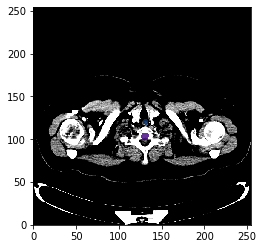

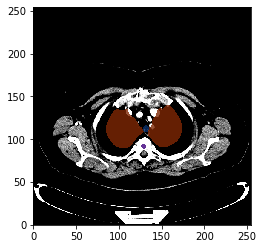

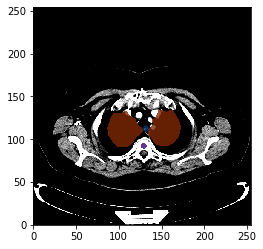

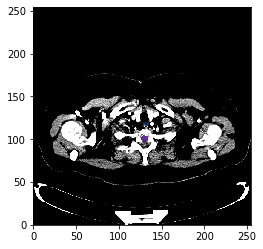

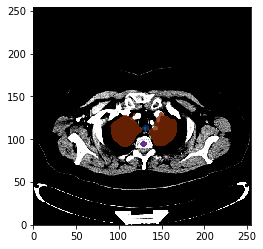

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import ipywidgets as widgets

dx, dy = 1, 1

x = np.arange(0, 255, dx)
y = np.arange(0, 255, dy)
extent = np.min(x), np.max(x), np.min(y), np.max(y)

clear_output(wait=True)

def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

def show_axial_slice(slcNum):
    clear_output(wait=True)
    print('Slice '+str(slcNum))
    if 'fig' in locals():
        fig.remove()
    fig, ax = plt.subplots()
    window_center = 45
    window_width = 125
    windowed_img = window_image(scanArray[:,:,slcNum-1],
                                window_center,window_width)
    im1 = ax.imshow(windowed_img, cmap=plt.cm.gray, alpha=1,
                    interpolation='nearest', extent=extent)
    
    cmaps = [plt.cm.Oranges,plt.cm.Oranges,plt.cm.Blues,plt.cm.Blues, \
             plt.cm.Purples,plt.cm.Greens]

    for maskNum in range(0,6,1):
        mask_cmap = cmaps[maskNum]
        mask_cmap.set_under('k', alpha=0)
        im2 = ax.imshow(maskC[0,maskNum][:,:,slcNum-1], 
                        cmap=mask_cmap, alpha=.8, extent=extent,
                        interpolation='none', clim=[0.5, 1])        
    plt.show()

slice_slider = widgets.IntSlider(min=1,max=79,step=1)
outputSlc = widgets.Output()

display(slice_slider, outputSlc)

def update_slice(change):
    with outputSlc:
        show_axial_slice(change['new'])

slice_slider.observe(update_slice, names='value')


### Run Heart Substructure model

In [ ]:
! wget {condaenv_gz} -O /content/condaenv/heart/CT_Heart_DeepLab_hdl35_linux.tar.gz & 
! wget {heartdeeplab_gz} -O /content/condaenv/heart/CT_Heart_DeepLab.tar.gz

--2021-10-29 20:43:50--  https://www.dropbox.com/s/ddr4swgovjrhj4m/condapack_CT_Heart_DeepLab_hdl35_linux.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.67.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.67.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ddr4swgovjrhj4m/condapack_CT_Heart_DeepLab_hdl35_linux.tar.gz [following]
--2021-10-29 20:43:50--  https://www.dropbox.com/s/raw/ddr4swgovjrhj4m/condapack_CT_Heart_DeepLab_hdl35_linux.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5209617da79bd65eee0fd52fd8.dl.dropboxusercontent.com/cd/0/inline/BY8oX4VsCyFg7c-XwHg-iXgUgbpjKdrLg4Z5fezTs0WCfm4asW1cQWSda9z1ArdijJLHkQm8IZB6sHMk63zv-Fai6bPUqFsacPJhOu6PkvfsGPdymSlM5yeJNwsqYLKwMBxGbgs8fiyrMX3RuIn-E62-/file# [following]
--2021-10-29 20:43:51--  https://uc5209617da79bd65eee0fd52fd8.dl.dropboxusercontent

In [ ]:
%%octave

#planC = createUnionStructure(1,2,planC);
planC = createExpandedStructure2D(6, margin, planC);
planC{indexS.structures}(end).structureName = 'lung_total';

sh: 1: makeinfo: not found

sh: 1: makeinfo: not found

Oct2PyError: ignored

In [ ]:
%%octave
indexS = planC{end};

% Preallocate memory to speed up the function
allAssocScanUID = cell(1,length(planC{indexS.structures}));
scanUID = cell(1,length(planC{indexS.scan}));

In [ ]:
%%octave
planC{indexS.structures}

ans =

  1x0 struct array containing the fields:

    imageNumber

    imageType

    caseNumber

    roiNumber

    patientName

    structureName

    ROIInterpretedType

    numberRepresentation

    structureFormat

    numberOfScans

    maximumNumberScans

    maximumPointsPerSegment

    maximumSegmentsPerScan

    structureEdition

    unitNumber

    writer

    dateWritten

    structureColor

    structureDescription

    roiGenerationAlgorithm

    roiGenerationDescription

    studyNumberOfOrigin

    contour

    rasterSegments

    DSHPoints

    orientationOfStructure

    transferProtocol

    DICOMHeaders

    visible

    associatedScan

    strUID

    assocScanUID

    structSetSopInstanceUID

    rasterized

    referencedFrameOfReferenceUID

    referencedSeriesUID

In [ ]:
%%octave

sessionPath = '/content/session_heart';
cmdFlag = 'condaEnv';
condaEnvName = '/content/condaenv/heart';
algorithm = 'CT_HeartSubStructures_DeepLab';
wrapperFunction = '/content/condaenv/heart/CT_Heart_DeepLab/model_wrapper/CT_HeartSubStructures_DeepLab/runSegHeartSubStructures.py';
batchSize = 1;

[activate_cmd,run_cmd,userOptS,outFile,scanNumV,planC] = prepDataForSeg(planC,sessionPath,algorithm,cmdFlag,condaEnvName, {wrapperFunction});
which prepDataForSeg
[outStrListC,labelMapS] = getAutosegStructnames('',userOptS);

      userInS =

        scalar structure containing the fields:

          strNameToLabelMap =

            1x8 struct array containing the fields:

              structureName

              value

          scan =

            scalar structure containing the fields:

              identifier =

                scalar structure containing the fields:

                  imageType: 1x7 sq_string

              resize =

                scalar structure containing the fields:

                  method: 1x4 sq_string

                  size: 1x2 matrix

              crop =

                1x9 struct array containing the fields:

                  method

                  params

                  operator

          batchSize = 1

          passedScanDim = 2D

          reference = https://w3.aapm.org/meetings/2019AM/programInfo/programAbs.php?sid=8013&aid=45641

      ans = 1

      ans = 1

Pre-processing data...

Cropping to region of interest...

Elapsed time is 0.622898 seconds.

Elapsed time is 0.000133038 seconds.

Writing to H5 format...

'prepDataForSeg' is a function from the file /content/CERR/CERR_core/Contouring/BABS/prepDataForSeg.m

In [ ]:
%%octave
save('lung_planC.mat','planC','-v7')

In [ ]:
%%octave
which writeDataForDL

'writeDataForDL' is a function from the file /content/CERR/CERR_core/DLSegmentationTraining/writeDataForDL.m

In [ ]:
%octave_pull outFile run_cmd

In [ ]:
!chmod 777 {outFile}

In [ ]:
q = subprocess.Popen(outFile,stdout=subprocess.PIPE,stderr=subprocess.PIPE)
s,err=q.communicate()
print(s)
print(err)

b'heart\n'
b'Python 3.5.6 :: Anaconda, Inc.\nTraceback (most recent call last):\n  File "/content/condaenv/heart/CT_Heart_DeepLab/model_wrapper/CT_HeartSubStructures_DeepLab/runSegHeartSubStructures.py", line 137, in <module>\n    main(sys.argv)\n  File "/content/condaenv/heart/CT_Heart_DeepLab/model_wrapper/CT_HeartSubStructures_DeepLab/runSegHeartSubStructures.py", line 128, in main\n    trainer = Trainer(argv)\n  File "/content/condaenv/heart/CT_Heart_DeepLab/model_wrapper/CT_HeartSubStructures_DeepLab/runSegHeartSubStructures.py", line 48, in __init__\n    self.test_loader, self.nclass = make_data_loader(self, **kwargs)\n  File "/content/condaenv/heart/CT_Heart_DeepLab/model_wrapper/CT_HeartSubStructures_DeepLab/dataloaders/__init__.py", line 7, in make_data_loader\n    test_set = heart.HeartSegmentation(args, split=\'test\')\n  File "/content/condaenv/heart/CT_Heart_DeepLab/model_wrapper/CT_HeartSubStructures_DeepLab/dataloaders/datasets/heart.py", line 34, in __init__\n    raise 

In [ ]:
%%octave
planC = processAndImportSeg(planC,1,sessionPath,userOptS);

Visualization

In [ ]:
%%octave

%Get scan array
indexS = planC{end};
scanNum = 1;
ctOffset = planC{indexS.scan}(scanNum).scanInfo(1).CTOffset;
scanArray = single(getScanArray(scanNum,planC)) - ctOffset;

%Get structure labels & masks
numStructs = length(planC{indexS.structures});
structNameC = {planC{indexS.structures}.structureName};
strNameC = outStrListC;
for strNum = 1:length(strNameC)
    strx = strNameC{strNum};
    idx = getMatchingIndex(strx,structNameC,'EXACT');
    mask3M = getStrMask(idx, planC);
    maskC{strNum} = mask3M;
end

In [ ]:
%octave_pull maskC strNameC scanArray

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import ipywidgets as widgets

dx, dy = 1, 1

x = np.arange(0, 255, dx)
y = np.arange(0, 255, dy)
extent = np.min(x), np.max(x), np.min(y), np.max(y)

clear_output(wait=True)

def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

def show_axial_slice(slcNum):
    clear_output(wait=True)
    print('Slice '+str(slcNum))
    if 'fig' in locals():
        fig.remove()
    fig, ax = plt.subplots()
    window_center = 45
    window_width = 125
    windowed_img = window_image(scanArray[:,:,slcNum-1],
                                window_center,window_width)
    im1 = ax.imshow(windowed_img, cmap=plt.cm.gray, alpha=1,
                    interpolation='nearest', extent=extent)
    
    cmaps = [plt.cm.Oranges,plt.cm.Oranges,plt.cm.Blues,plt.cm.Blues, \
             plt.cm.Purples,plt.cm.Greens]

    for maskNum in range(0,6,1):
        mask_cmap = cmaps[maskNum]
        mask_cmap.set_under('k', alpha=0)
        im2 = ax.imshow(maskC[0,maskNum][:,:,slcNum-1], 
                        cmap=mask_cmap, alpha=.8, extent=extent,
                        interpolation='none', clim=[0.5, 1])        
    plt.show()

slice_slider = widgets.IntSlider(min=1,max=79,step=1)
outputSlc = widgets.Output()

display(slice_slider, outputSlc)

def update_slice(change):
    with outputSlc:
        show_axial_slice(change['new'])

slice_slider.observe(update_slice, names='value')
